In [1]:
#import important packages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set_style('darkgrid')

from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='notebook', ticks=True, grid=True)

pd.set_option('display.max_columns', None)

In [2]:
from yellowbrick.classifier import ROCAUC

In [3]:
from sklearn.preprocessing import QuantileTransformer, LabelEncoder, MinMaxScaler, OneHotEncoder

In [4]:
from sklearn.model_selection import cross_validate, train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import r2_score, log_loss, confusion_matrix, classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, make_scorer

In [5]:
from imblearn.over_sampling import SMOTE

In [6]:
from sklearn.feature_selection import RFE, RFECV

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [8]:
SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Data Import

In [9]:
leads = pd.read_csv('Leads.csv')
leads.head()

Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                   0.0  Page Visited on Website   
1                          674                   2.5             Email Opened   
2                         1532                   2.0             Email Opened   
3                          305                   1.0              Unreachable   
4                         1428                   1.0        Converted to Lead   

  Country           Specialization How did you hear about X Education  \
0     NaN                   Select                             Select   
1   India                   Select                             Select   
2   India  Business Administration                             Select   
3   India    Media and Advertising                      Word Of Mouth   
4   India                   Select                              Other   

  What is your current occupation  \
0                      Unemployed   
1                      Unemployed   
2                         Student   
3                      Unemployed   
4                      Unemployed   

  What matters most to you in choosing a course Search Magazine  \
0                       Better Career Prospects     No       No   
1                       Better Career Prospects     No       No   
2                       Better Career Prospects     No       No   
3                       Better Career Prospects     No       No   
4                       Better Career Prospects     No       No   

  Newspaper Article X Education Forums Newspaper Digital Advertisement  \
0                No                 No        No                    No   
1                No                 No        No                    No   
2                No                 No        No                    No   
3                No                 No        No                    No   
4                No                 No        No                    No   

  Through Recommendations Receive More Updates About Our Courses  \
0                      No                                     No   
1                      No                                     No   
2                      No                                     No   
3                      No                                     No   
4                      No                                     No   

                                  Tags      Lead Quality  \
0          Interested in other courses  Low in Relevance   
1                              Ringing               NaN   
2  Will revert after reading the email          Might be   
3                              Ringing          Not Sure   
4  Will revert after reading the email          Might be   

  Update me on Supply Chain Content Get updates on DM Content    Lead Profile  \
0                                No                        No          Select   
1                                No                        No          Select   
2                                No                        No  Potential Lead   
3                            

In [10]:
leads.shape

(9240, 37)

In [11]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
Prospect ID                                      9240 non-null object
Lead Number                                      9240 non-null int64
Lead Origin                                      9240 non-null object
Lead Source                                      9204 non-null object
Do Not Email                                     9240 non-null object
Do Not Call                                      9240 non-null object
Converted                                        9240 non-null int64
TotalVisits                                      9103 non-null float64
Total Time Spent on Website                      9240 non-null int64
Page Views Per Visit                             9103 non-null float64
Last Activity                                    9137 non-null object
Country                                          6779 non-null object
Specialization                                   7802 

## Data Cleaning

In [12]:
def get_missing_report(leads):
    missing_leads = (leads.isnull().sum()/len(leads)).rename_axis('columns').to_frame('missing_perc').reset_index()
    missing_leads['type'] = missing_leads['columns'].apply(lambda col: str(leads[col].dtypes))
    return missing_leads.sort_values(by = 'missing_perc', ascending=False)

### Missing data

In [13]:
missing_leads = get_missing_report(leads)
missing_leads

columns  missing_perc     type
25                                   Lead Quality      0.515909   object
30                    Asymmetrique Activity Index      0.456494   object
33                     Asymmetrique Profile Score      0.456494  float64
32                    Asymmetrique Activity Score      0.456494  float64
31                     Asymmetrique Profile Index      0.456494   object
24                                           Tags      0.362879   object
28                                   Lead Profile      0.293182   object
15  What matters most to you in choosing a course      0.293182   object
14                What is your current occupation      0.291126   object
11                                        Country      0.266342   object
13             How did you hear about X Education      0.238853   object
12                                 Specialization      0.155628   object
29                                           City      0.153680   object
9                            Page Views Per Visit      0.014827  float64
7                                     TotalVisits      0.014827  float64
10                                  Last Activity      0.011147   object
3                                     Lead Source      0.003896   object
23         Receive More Updates About Our Courses      0.000000   object
34       I agree to pay the amount through cheque      0.000000   object
27                      Get updates on DM Content      0.000000   object
26              Update me on Supply Chain Content      0.000000   object
35         A free copy of Mastering The Interview      0.000000   object
0                                     Prospect ID      0.000000   object
18                              Newspaper Article      0.000000   object
22                        Through Recommendations      0.000000   object
21                          Digital Advertisement      0.000000   object
20                                      Newspaper      0.000000   object
19                             X Education Forums      0.000000   object
1                                     Lead Number      0.000000    int64
17                                       Magazine      0.000000   object
16                                         Search      0.000000   object
8                     Total Time Spent on Website      0.000000    int64
6                                       Converted      0.000000    int64
5                                     Do Not Call      0.000000   object
4                                    Do Not Email      0.000000   object
2                                     Lead Origin      0.000000   object
36                          Last Notable Activity      0.000000   object

### Special columns

Prospect ID, Lead Number - ID Columns

Drop - Magazine - All values are same (No)

Drop - Receive More Updates About Our Courses - All values are same (No)

Drop - Update me on Supply Chain Content - All values are same (No)

Drop - Get updates on DM Content - All values are same (No)

Drop - City - Wrong values present (doesnt match with country)

Drop - I agree to pay the amount through cheque - All values are same (No)

In [14]:
cols_to_drop = ['Prospect ID', 'Lead Number', 'Magazine', 'Receive More Updates About Our Courses', 'Update me on Supply Chain Content',
               'Get updates on DM Content', 'City', 'I agree to pay the amount through cheque']

leads.drop(cols_to_drop, axis=1, inplace=True)

In [15]:
len(leads.columns)

29

In [16]:
missing_leads = get_missing_report(leads)
missing_leads

columns  missing_perc     type
21                                   Lead Quality      0.515909   object
26                     Asymmetrique Profile Score      0.456494  float64
25                    Asymmetrique Activity Score      0.456494  float64
24                     Asymmetrique Profile Index      0.456494   object
23                    Asymmetrique Activity Index      0.456494   object
20                                           Tags      0.362879   object
22                                   Lead Profile      0.293182   object
13  What matters most to you in choosing a course      0.293182   object
12                What is your current occupation      0.291126   object
9                                         Country      0.266342   object
11             How did you hear about X Education      0.238853   object
10                                 Specialization      0.155628   object
7                            Page Views Per Visit      0.014827  float64
5                                     TotalVisits      0.014827  float64
8                                   Last Activity      0.011147   object
1                                     Lead Source      0.003896   object
19                        Through Recommendations      0.000000   object
27         A free copy of Mastering The Interview      0.000000   object
0                                     Lead Origin      0.000000   object
14                                         Search      0.000000   object
18                          Digital Advertisement      0.000000   object
17                                      Newspaper      0.000000   object
16                             X Education Forums      0.000000   object
15                              Newspaper Article      0.000000   object
6                     Total Time Spent on Website      0.000000    int64
4                                       Converted      0.000000    int64
3                                     Do Not Call      0.000000   object
2                                    Do Not Email      0.000000   object
28                          Last Notable Activity      0.000000   object

In [17]:
len(leads[leads['Country'] == 'unknown'])/len(leads)

0.0005411255411255411

In [18]:
leads['Country'].value_counts(normalize=True)

India                   0.957663
United States           0.010178
United Arab Emirates    0.007818
Singapore               0.003540
Saudi Arabia            0.003098
United Kingdom          0.002213
Australia               0.001918
Qatar                   0.001475
Hong Kong               0.001033
Bahrain                 0.001033
Oman                    0.000885
France                  0.000885
unknown                 0.000738
Nigeria                 0.000590
Kuwait                  0.000590
South Africa            0.000590
Germany                 0.000590
Canada                  0.000590
Sweden                  0.000443
China                   0.000295
Belgium                 0.000295
Italy                   0.000295
Philippines             0.000295
Asia/Pacific Region     0.000295
Uganda                  0.000295
Netherlands             0.000295
Ghana                   0.000295
Bangladesh              0.000295
Sri Lanka               0.000148
Tanzania                0.000148
Switzerlan

Country - unknown

Specialization - Select

How did you hear about X Education - Select

Lead Profile - Select

## Assign NaN to Select values

In [19]:
country_indices = leads[leads['Country'] == 'unknown'].index
leads.loc[country_indices, 'Country'] = np.nan

In [20]:
spec_indices = leads[leads['Specialization'] == 'Select'].index
leads.loc[spec_indices, 'Specialization'] = np.nan

In [21]:
missing_leads = get_missing_report(leads)
missing_leads

columns  missing_perc     type
21                                   Lead Quality      0.515909   object
26                     Asymmetrique Profile Score      0.456494  float64
25                    Asymmetrique Activity Score      0.456494  float64
24                     Asymmetrique Profile Index      0.456494   object
23                    Asymmetrique Activity Index      0.456494   object
10                                 Specialization      0.365801   object
20                                           Tags      0.362879   object
22                                   Lead Profile      0.293182   object
13  What matters most to you in choosing a course      0.293182   object
12                What is your current occupation      0.291126   object
9                                         Country      0.266883   object
11             How did you hear about X Education      0.238853   object
7                            Page Views Per Visit      0.014827  float64
5                                     TotalVisits      0.014827  float64
8                                   Last Activity      0.011147   object
1                                     Lead Source      0.003896   object
19                        Through Recommendations      0.000000   object
27         A free copy of Mastering The Interview      0.000000   object
0                                     Lead Origin      0.000000   object
14                                         Search      0.000000   object
18                          Digital Advertisement      0.000000   object
17                                      Newspaper      0.000000   object
16                             X Education Forums      0.000000   object
15                              Newspaper Article      0.000000   object
6                     Total Time Spent on Website      0.000000    int64
4                                       Converted      0.000000    int64
3                                     Do Not Call      0.000000   object
2                                    Do Not Email      0.000000   object
28                          Last Notable Activity      0.000000   object

In [22]:
sel_indices = leads[leads['How did you hear about X Education'] == 'Select'].index
leads.loc[sel_indices, 'How did you hear about X Education'] = np.nan

In [23]:
missing_leads = get_missing_report(leads)
missing_leads

columns  missing_perc     type
11             How did you hear about X Education      0.784632   object
21                                   Lead Quality      0.515909   object
26                     Asymmetrique Profile Score      0.456494  float64
25                    Asymmetrique Activity Score      0.456494  float64
24                     Asymmetrique Profile Index      0.456494   object
23                    Asymmetrique Activity Index      0.456494   object
10                                 Specialization      0.365801   object
20                                           Tags      0.362879   object
22                                   Lead Profile      0.293182   object
13  What matters most to you in choosing a course      0.293182   object
12                What is your current occupation      0.291126   object
9                                         Country      0.266883   object
7                            Page Views Per Visit      0.014827  float64
5                                     TotalVisits      0.014827  float64
8                                   Last Activity      0.011147   object
1                                     Lead Source      0.003896   object
19                        Through Recommendations      0.000000   object
27         A free copy of Mastering The Interview      0.000000   object
0                                     Lead Origin      0.000000   object
14                                         Search      0.000000   object
18                          Digital Advertisement      0.000000   object
17                                      Newspaper      0.000000   object
16                             X Education Forums      0.000000   object
15                              Newspaper Article      0.000000   object
6                     Total Time Spent on Website      0.000000    int64
4                                       Converted      0.000000    int64
3                                     Do Not Call      0.000000   object
2                                    Do Not Email      0.000000   object
28                          Last Notable Activity      0.000000   object

In [24]:
sel_indices = leads[leads['Lead Profile'] == 'Select'].index
leads.loc[sel_indices, 'Lead Profile'] = np.nan

In [25]:
missing_leads = get_missing_report(leads)
missing_leads

columns  missing_perc     type
11             How did you hear about X Education      0.784632   object
22                                   Lead Profile      0.741883   object
21                                   Lead Quality      0.515909   object
26                     Asymmetrique Profile Score      0.456494  float64
25                    Asymmetrique Activity Score      0.456494  float64
24                     Asymmetrique Profile Index      0.456494   object
23                    Asymmetrique Activity Index      0.456494   object
10                                 Specialization      0.365801   object
20                                           Tags      0.362879   object
13  What matters most to you in choosing a course      0.293182   object
12                What is your current occupation      0.291126   object
9                                         Country      0.266883   object
7                            Page Views Per Visit      0.014827  float64
5                                     TotalVisits      0.014827  float64
8                                   Last Activity      0.011147   object
1                                     Lead Source      0.003896   object
19                        Through Recommendations      0.000000   object
27         A free copy of Mastering The Interview      0.000000   object
0                                     Lead Origin      0.000000   object
14                                         Search      0.000000   object
18                          Digital Advertisement      0.000000   object
17                                      Newspaper      0.000000   object
16                             X Education Forums      0.000000   object
15                              Newspaper Article      0.000000   object
6                     Total Time Spent on Website      0.000000    int64
4                                       Converted      0.000000    int64
3                                     Do Not Call      0.000000   object
2                                    Do Not Email      0.000000   object
28                          Last Notable Activity      0.000000   object

## Dropping some columns due to high missing values

In [26]:
missing_leads['columns'].values

array(['How did you hear about X Education', 'Lead Profile',
       'Lead Quality', 'Asymmetrique Profile Score',
       'Asymmetrique Activity Score', 'Asymmetrique Profile Index',
       'Asymmetrique Activity Index', 'Specialization', 'Tags',
       'What matters most to you in choosing a course',
       'What is your current occupation', 'Country',
       'Page Views Per Visit', 'TotalVisits', 'Last Activity',
       'Lead Source', 'Through Recommendations',
       'A free copy of Mastering The Interview', 'Lead Origin', 'Search',
       'Digital Advertisement', 'Newspaper', 'X Education Forums',
       'Newspaper Article', 'Total Time Spent on Website', 'Converted',
       'Do Not Call', 'Do Not Email', 'Last Notable Activity'],
      dtype=object)

In [27]:
cols_to_drop = ['How did you hear about X Education', 'Lead Profile',
       'Lead Quality', 'Asymmetrique Profile Score',
       'Asymmetrique Activity Score', 'Asymmetrique Profile Index', 'Asymmetrique Activity Index']

leads.drop(cols_to_drop, axis=1, inplace=True)

In [28]:
missing_leads = get_missing_report(leads)
missing_leads

columns  missing_perc     type
10                                 Specialization      0.365801   object
19                                           Tags      0.362879   object
12  What matters most to you in choosing a course      0.293182   object
11                What is your current occupation      0.291126   object
9                                         Country      0.266883   object
5                                     TotalVisits      0.014827  float64
7                            Page Views Per Visit      0.014827  float64
8                                   Last Activity      0.011147   object
1                                     Lead Source      0.003896   object
15                             X Education Forums      0.000000   object
20         A free copy of Mastering The Interview      0.000000   object
18                        Through Recommendations      0.000000   object
17                          Digital Advertisement      0.000000   object
16                                      Newspaper      0.000000   object
0                                     Lead Origin      0.000000   object
14                              Newspaper Article      0.000000   object
13                                         Search      0.000000   object
6                     Total Time Spent on Website      0.000000    int64
4                                       Converted      0.000000    int64
3                                     Do Not Call      0.000000   object
2                                    Do Not Email      0.000000   object
21                          Last Notable Activity      0.000000   object

In [29]:
numerical_missing_cols = list(missing_leads[(missing_leads['missing_perc'] > 0) & ((missing_leads['type'] == 'float64'))]['columns'])
print(numerical_missing_cols)
non_numerical_missing_cols = list(missing_leads[(missing_leads['missing_perc'] > 0) & ((missing_leads['type'] == 'object'))]['columns'])
print(non_numerical_missing_cols)

['TotalVisits', 'Page Views Per Visit']
['Specialization', 'Tags', 'What matters most to you in choosing a course', 'What is your current occupation', 'Country', 'Last Activity', 'Lead Source']


In [30]:
def plot_distribution(df, cols):
    for col in cols:
        plt.figure(figsize=(8,8))
        plt.title('%s distribution' %col)
        sns.distplot(df[col], bins=30)
        plt.show()

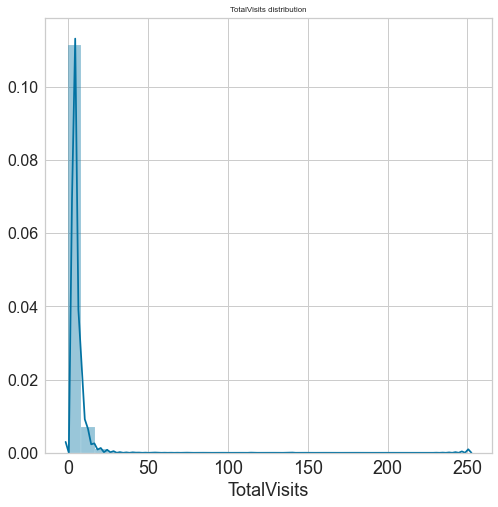

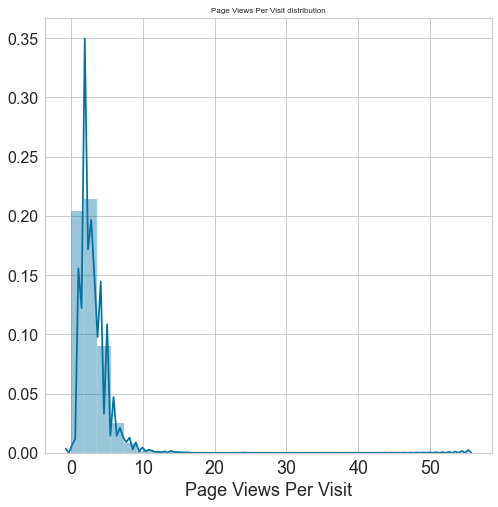

In [31]:
plot_distribution(leads, numerical_missing_cols)

From the distribution we can infer that most of them are skewed

### Filling NA with median

In [32]:
for col in numerical_missing_cols:
    median_val_col = leads[col].median()
    leads[col] = leads[col].fillna(median_val_col)

In [33]:
missing_leads = get_missing_report(leads)
missing_leads

columns  missing_perc     type
10                                 Specialization      0.365801   object
19                                           Tags      0.362879   object
12  What matters most to you in choosing a course      0.293182   object
11                What is your current occupation      0.291126   object
9                                         Country      0.266883   object
8                                   Last Activity      0.011147   object
1                                     Lead Source      0.003896   object
14                              Newspaper Article      0.000000   object
20         A free copy of Mastering The Interview      0.000000   object
18                        Through Recommendations      0.000000   object
17                          Digital Advertisement      0.000000   object
16                                      Newspaper      0.000000   object
15                             X Education Forums      0.000000   object
0                                     Lead Origin      0.000000   object
13                                         Search      0.000000   object
7                            Page Views Per Visit      0.000000  float64
6                     Total Time Spent on Website      0.000000    int64
5                                     TotalVisits      0.000000  float64
4                                       Converted      0.000000    int64
3                                     Do Not Call      0.000000   object
2                                    Do Not Email      0.000000   object
21                          Last Notable Activity      0.000000   object

Separate out numerical and categorical columns

In [34]:
numerical_cols = []
categorical_cols = []

for col in missing_leads['columns']:
    col_type = missing_leads[missing_leads['columns'] == col]['type'].values[0]
    if col_type == 'object':
        categorical_cols.append(col)
    else:
        numerical_cols.append(col)

In [35]:
numerical_cols

['Page Views Per Visit',
 'Total Time Spent on Website',
 'TotalVisits',
 'Converted']

In [36]:
target_col = 'Converted'
numerical_cols.remove(target_col)

In [37]:
numerical_cols

['Page Views Per Visit', 'Total Time Spent on Website', 'TotalVisits']

In [38]:
categorical_cols

['Specialization',
 'Tags',
 'What matters most to you in choosing a course',
 'What is your current occupation',
 'Country',
 'Last Activity',
 'Lead Source',
 'Newspaper Article',
 'A free copy of Mastering The Interview',
 'Through Recommendations',
 'Digital Advertisement',
 'Newspaper',
 'X Education Forums',
 'Lead Origin',
 'Search',
 'Do Not Call',
 'Do Not Email',
 'Last Notable Activity']

## Exploratory Data Analysis

### Check data for imbalance

In [39]:
leads[target_col].value_counts(normalize=True)

0    0.61461
1    0.38539
Name: Converted, dtype: float64

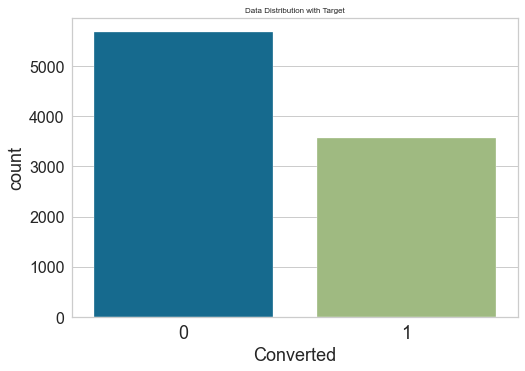

In [40]:
plt.title('Data Distribution with Target')
sns.countplot(leads[target_col])
plt.show()

Data is slightly imbalanced with ~40% of leads converted

In [41]:
def show_combined_plot(col, target_col, df1, df2, figsize=(15,7), tight_layout=False):
    # combined bar plot
    fig, axes = plt.subplots(2,1, figsize = figsize)
    
    # seaborn bar plot
    sns.barplot(x = col, y = target_col, data = df1, ax = axes[0])
    sns.barplot(x = col, y = target_col, data = df2, ax = axes[1])

    flat_axes = axes.flat
    ax1 = flat_axes[0]
    # adding text value
    ax1.set(xlabel=col, ylabel='Percentage Share')
    for index, row in df1.iterrows():
        ax1.text(row.name, row[target_col], str(round(row[target_col],2)) + '%', color='black', ha="center")
    
    # adding text value
    ax2 = flat_axes[1]
    ax2.set(xlabel=col, ylabel='Conversion Rate')
    for index, row in df2.iterrows():
        ax2.text(row.name, row[target_col], str(round(row[target_col],2)) + '%', color='black', ha="center")
    
    if tight_layout:
        ax1.set_xticklabels(df1[col].values, rotation=90)
        ax2.set_xticklabels(df2[col].values, rotation=90)
        
    fig.tight_layout()
    plt.show()

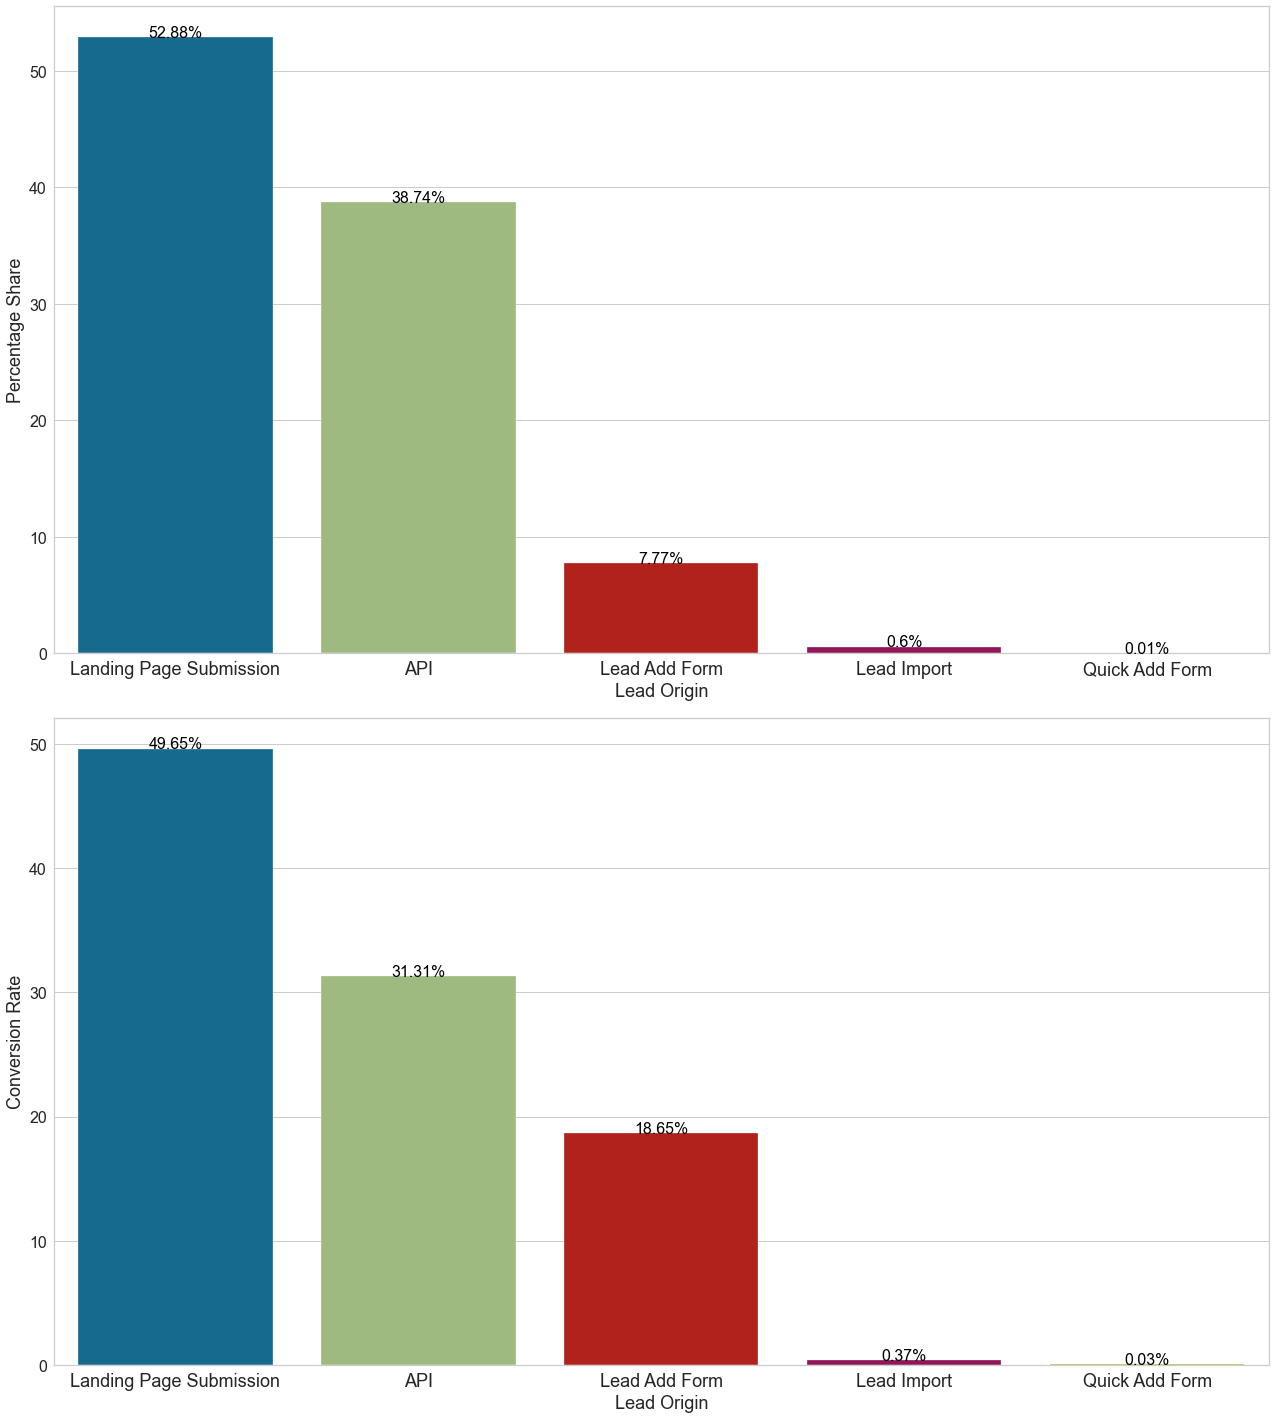

In [42]:
leads_grp_df1 = (leads['Lead Origin'].value_counts(normalize=True) * 100).rename_axis('Lead Origin').to_frame(target_col).reset_index()
leads_grp_df2 = (leads.groupby('Lead Origin')[target_col].sum()/sum(leads[target_col]) * 100).to_frame().sort_values(by=target_col, ascending=False).reset_index()
show_combined_plot('Lead Origin', target_col, leads_grp_df1, leads_grp_df2,figsize=(18,20))

Increase Lead Add Form percentage share in order to get more conversion.

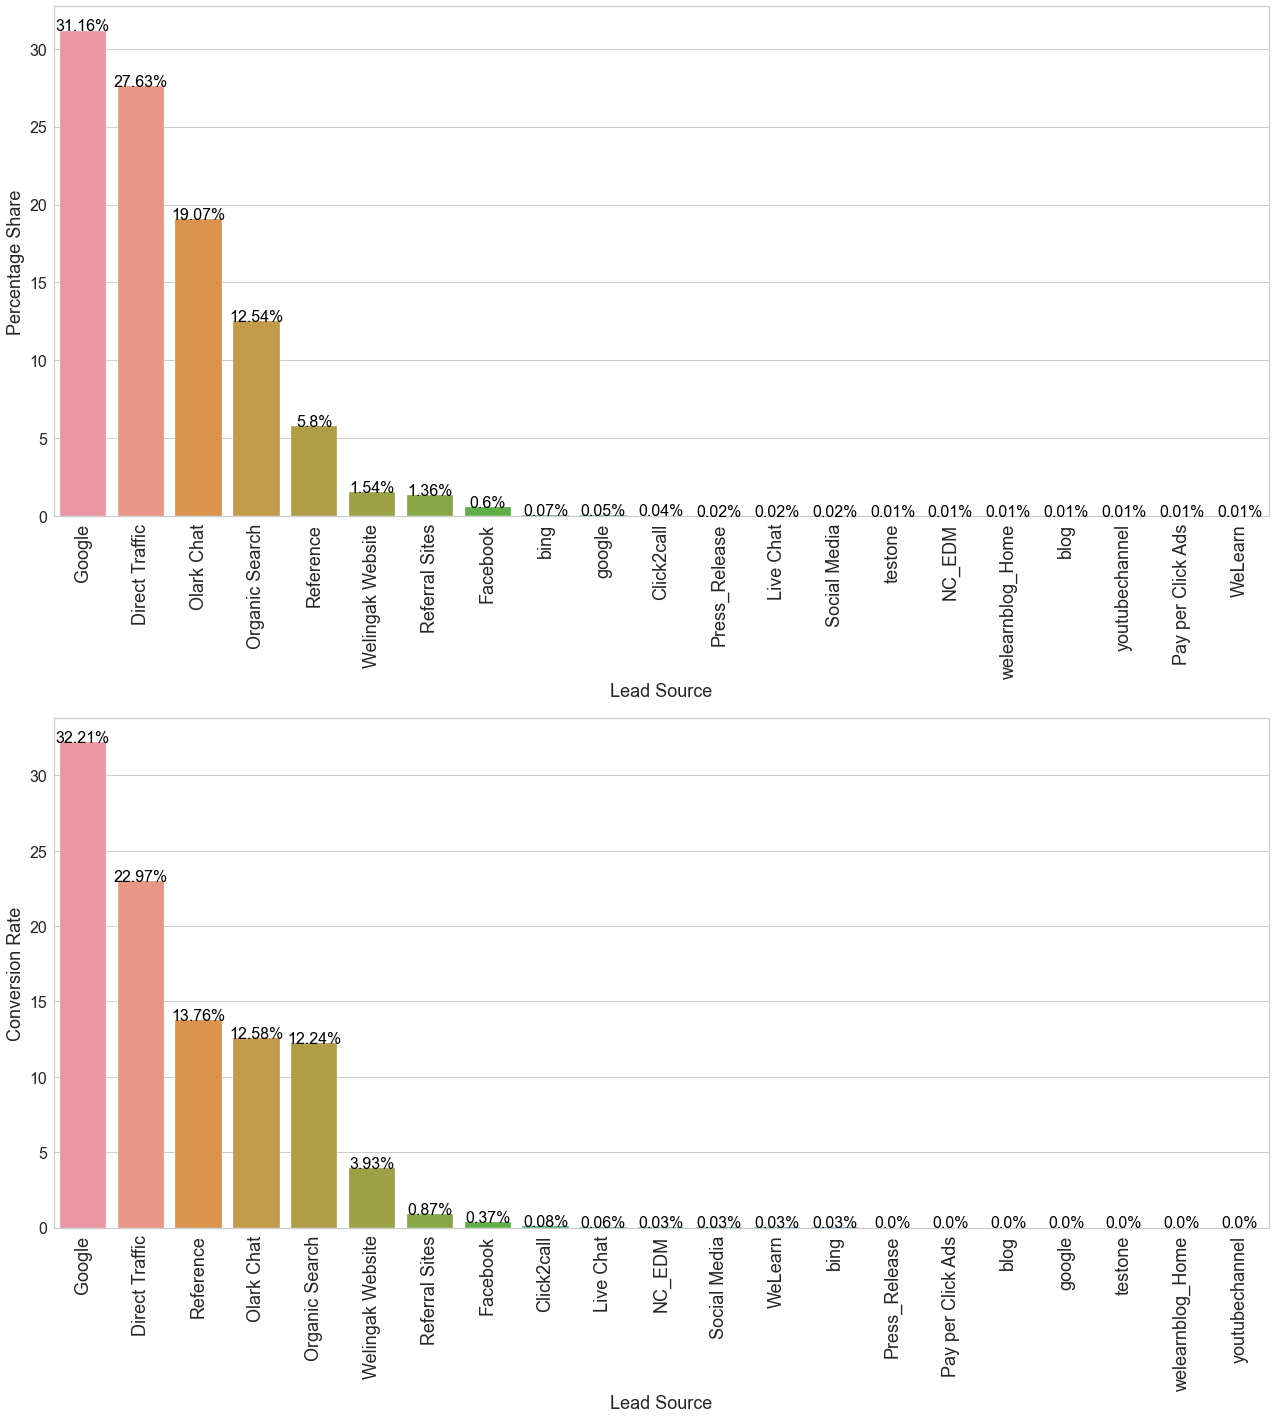

In [43]:
leads_source_grp_df1 = (leads['Lead Source'].value_counts(normalize=True) * 100).rename_axis('Lead Source').to_frame(target_col).reset_index()
leads_source_grp_df2 = (leads.groupby('Lead Source')[target_col].sum()/sum(leads[target_col]) * 100).to_frame().sort_values(by=target_col, ascending=False).reset_index()
show_combined_plot('Lead Source', target_col, leads_source_grp_df1, leads_source_grp_df2, tight_layout=True,figsize=(18,20))

Reference has very low per share but good con rate

Replace google with Google

In [44]:
google_indices = leads[leads['Lead Source'] == 'google'].index
leads.loc[google_indices, 'Lead Source'] = 'Google'

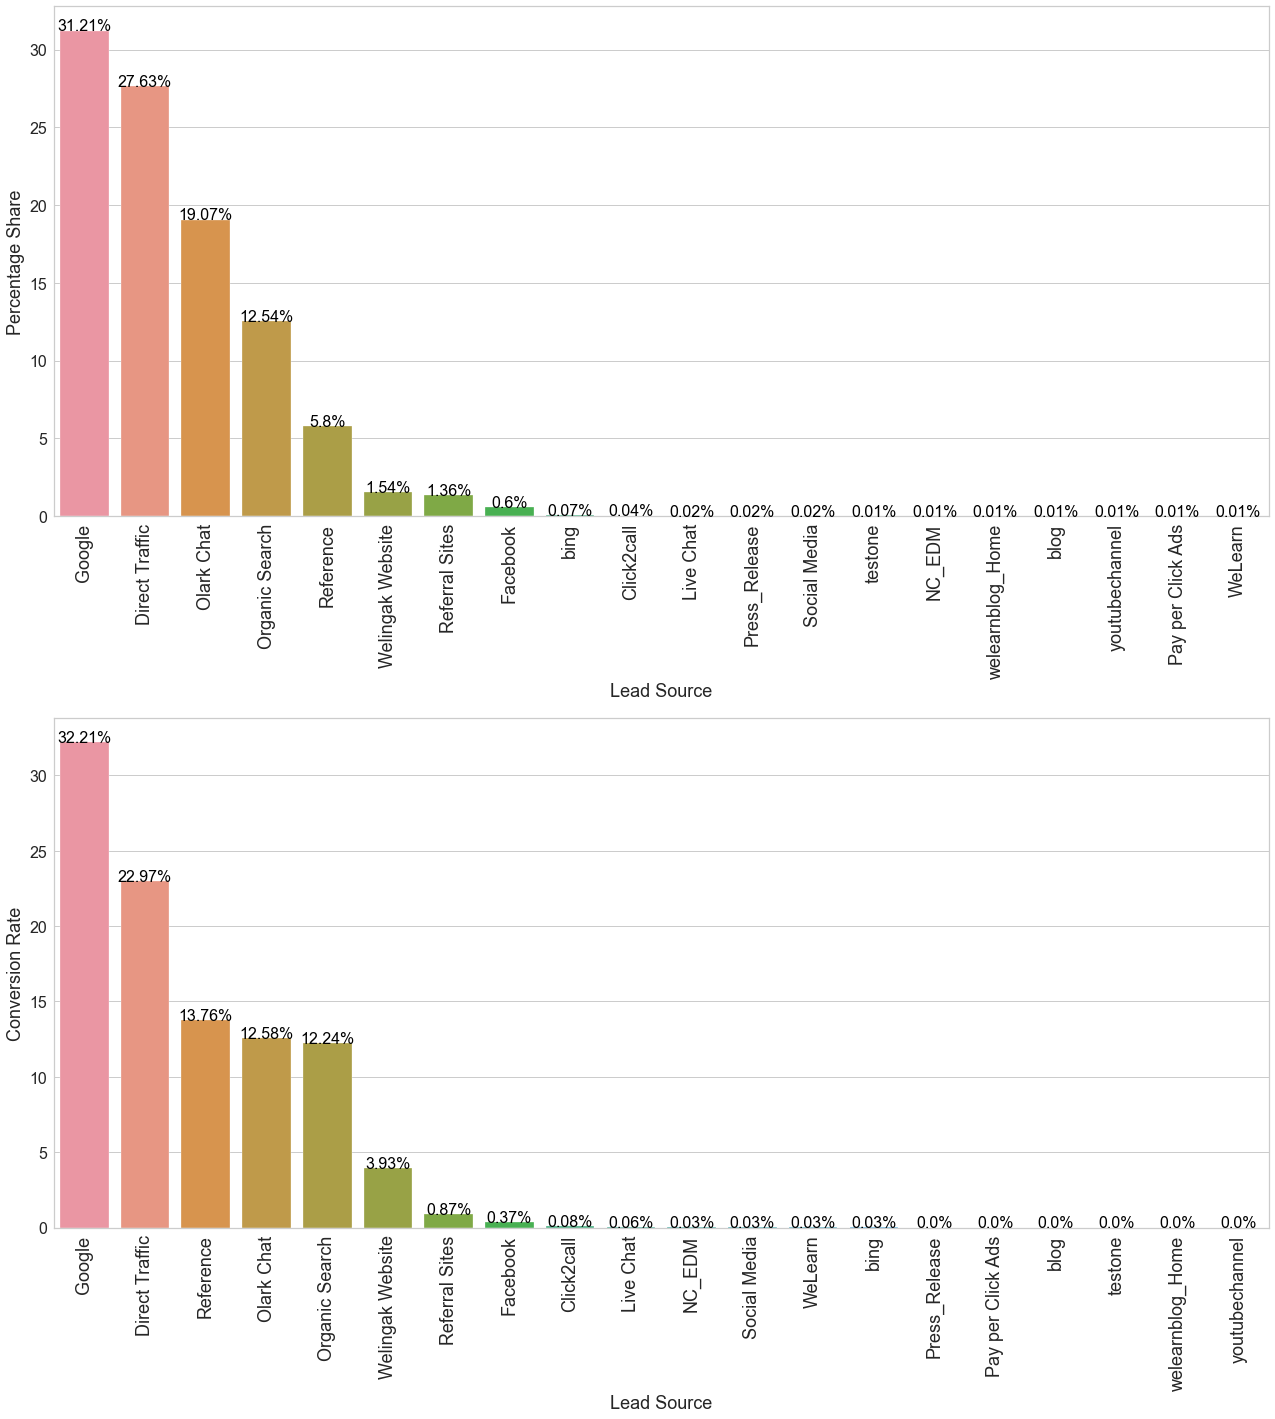

In [45]:
leads_source_grp_df1 = (leads['Lead Source'].value_counts(normalize=True) * 100).rename_axis('Lead Source').to_frame(target_col).reset_index()
leads_source_grp_df2 = (leads.groupby('Lead Source')[target_col].sum()/sum(leads[target_col]) * 100).to_frame().sort_values(by=target_col, ascending=False).reset_index()
show_combined_plot('Lead Source', target_col, leads_source_grp_df1, leads_source_grp_df2, tight_layout=True,figsize=(18,20))

In [46]:
leads['Lead Source'] = leads['Lead Source'].replace(np.nan, 'na_lead_source')

Replace missing values in Lead Source with na_lead_source

Lead source from Direct traffic and Google have high conversion rate

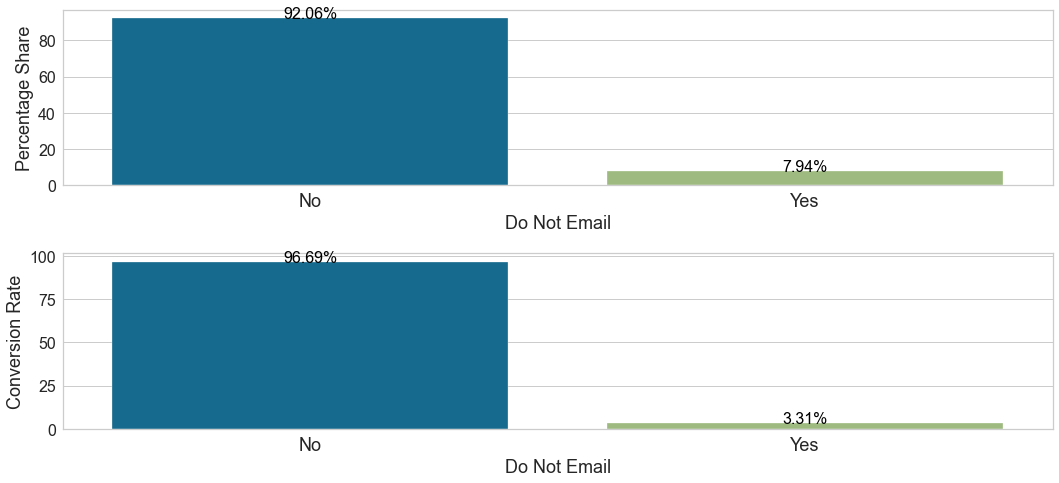

In [47]:
leads_de_grp_df1 = (leads['Do Not Email'].value_counts(normalize=True) * 100).rename_axis('Do Not Email').to_frame(target_col).reset_index()
leads_de_grp_df2 = (leads.groupby('Do Not Email')[target_col].sum()/sum(leads[target_col]) * 100).to_frame().sort_values(by=target_col, ascending=False).reset_index()
show_combined_plot('Do Not Email', target_col, leads_de_grp_df1, leads_de_grp_df2)

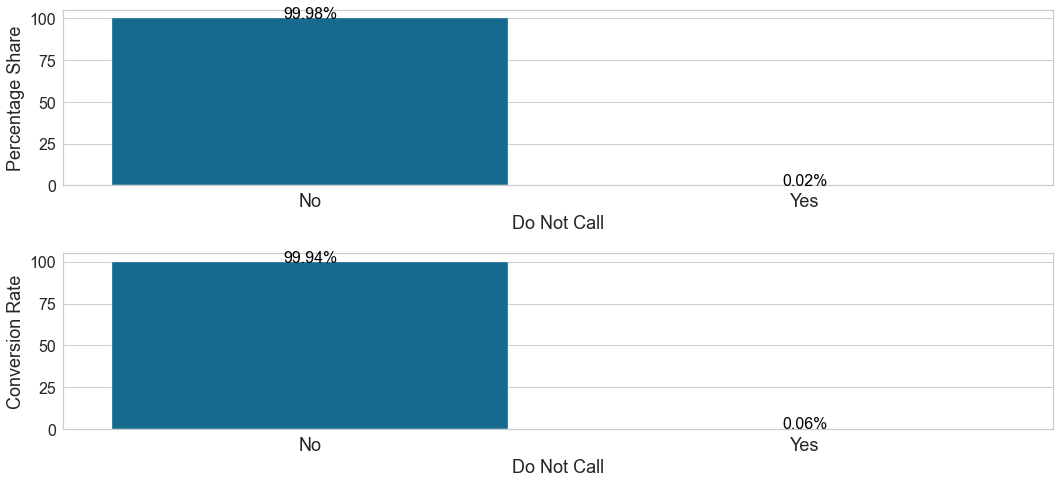

In [48]:
leads_dc_grp_df1 = (leads['Do Not Call'].value_counts(normalize=True) * 100).rename_axis('Do Not Call').to_frame(target_col).reset_index()
leads_dc_grp_df2 = (leads.groupby('Do Not Call')[target_col].sum()/sum(leads[target_col]) * 100).to_frame().sort_values(by=target_col, ascending=False).reset_index()
show_combined_plot('Do Not Call', target_col, leads_dc_grp_df1, leads_dc_grp_df2)

People opting out of Email and Calls have less chance of conversion

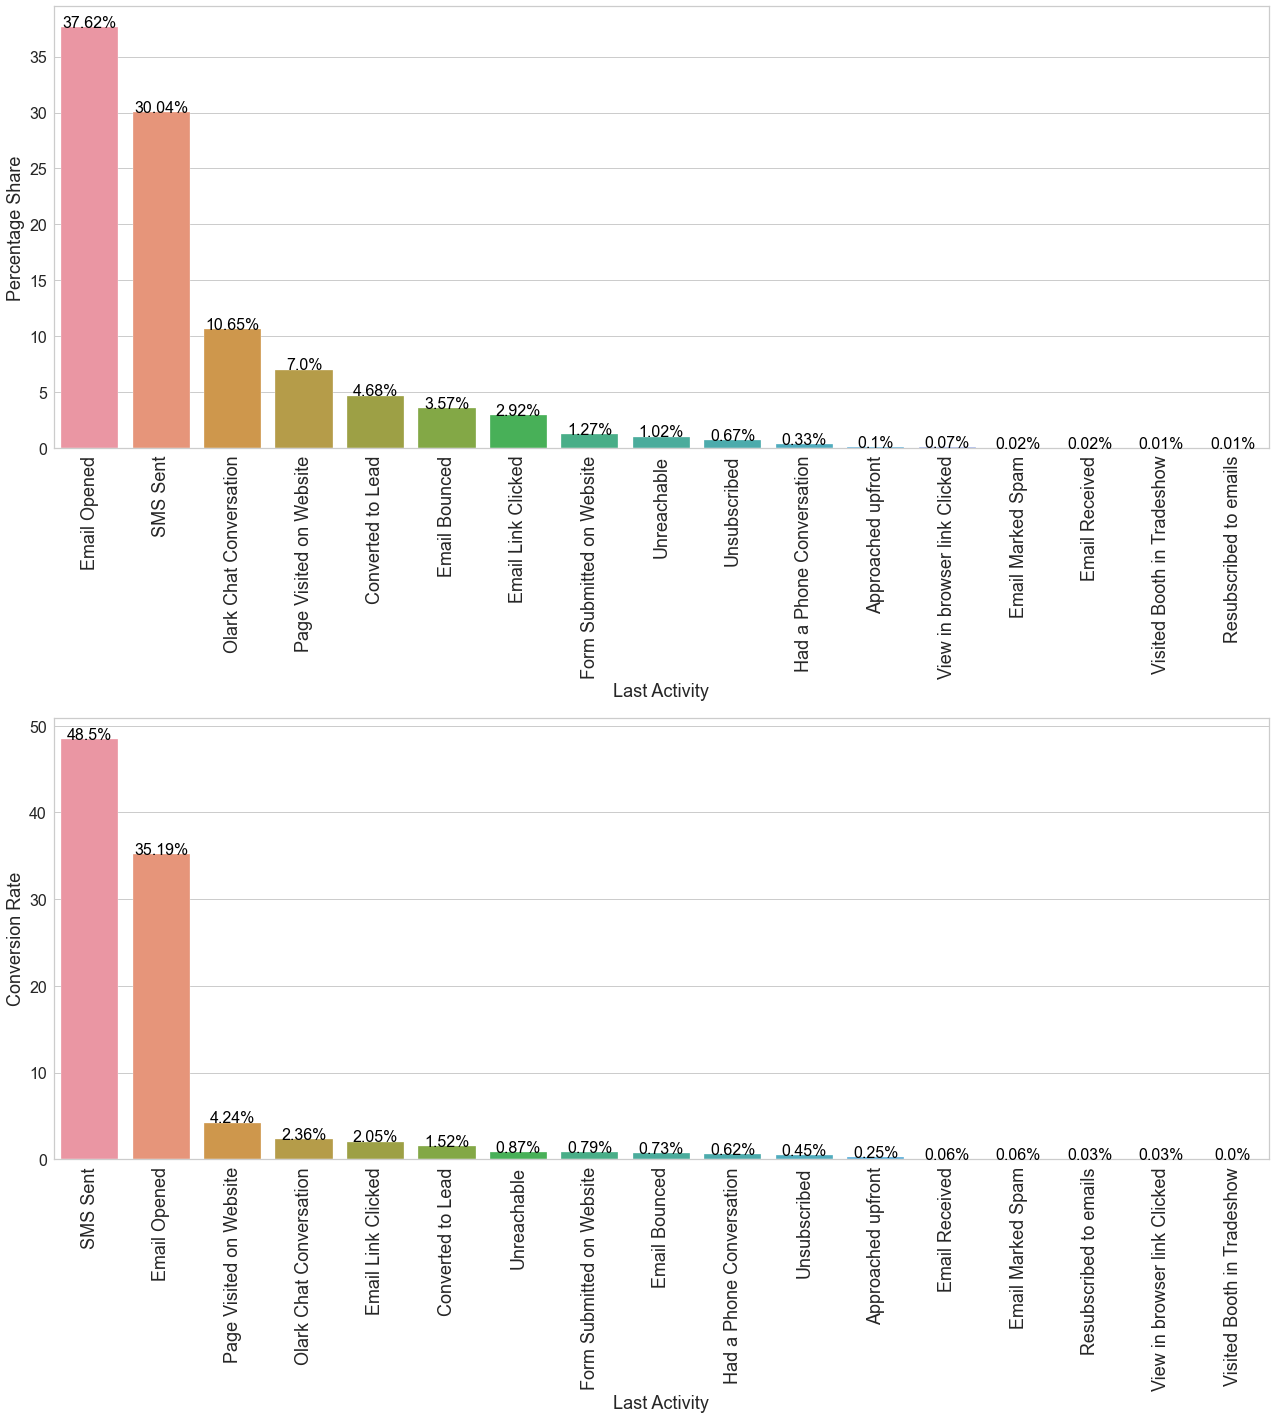

In [49]:
#missing
leads_la_grp_df1 = (leads['Last Activity'].value_counts(normalize=True) * 100).rename_axis('Last Activity').to_frame(target_col).reset_index()
leads_la_grp_df2 = (leads.groupby('Last Activity')[target_col].sum()/sum(leads[target_col]) * 100).to_frame().sort_values(by=target_col, ascending=False).reset_index()
show_combined_plot('Last Activity', target_col, leads_la_grp_df1, leads_la_grp_df2, tight_layout=True,figsize=(18,20))

Trend reverses for SMS sent and Email opened going from pre share to con rate.

In [50]:
leads['Last Activity'] = leads['Last Activity'].replace(np.nan, 'na_last_activity')

Replaced missing vales in Last Activity with na_last_activity

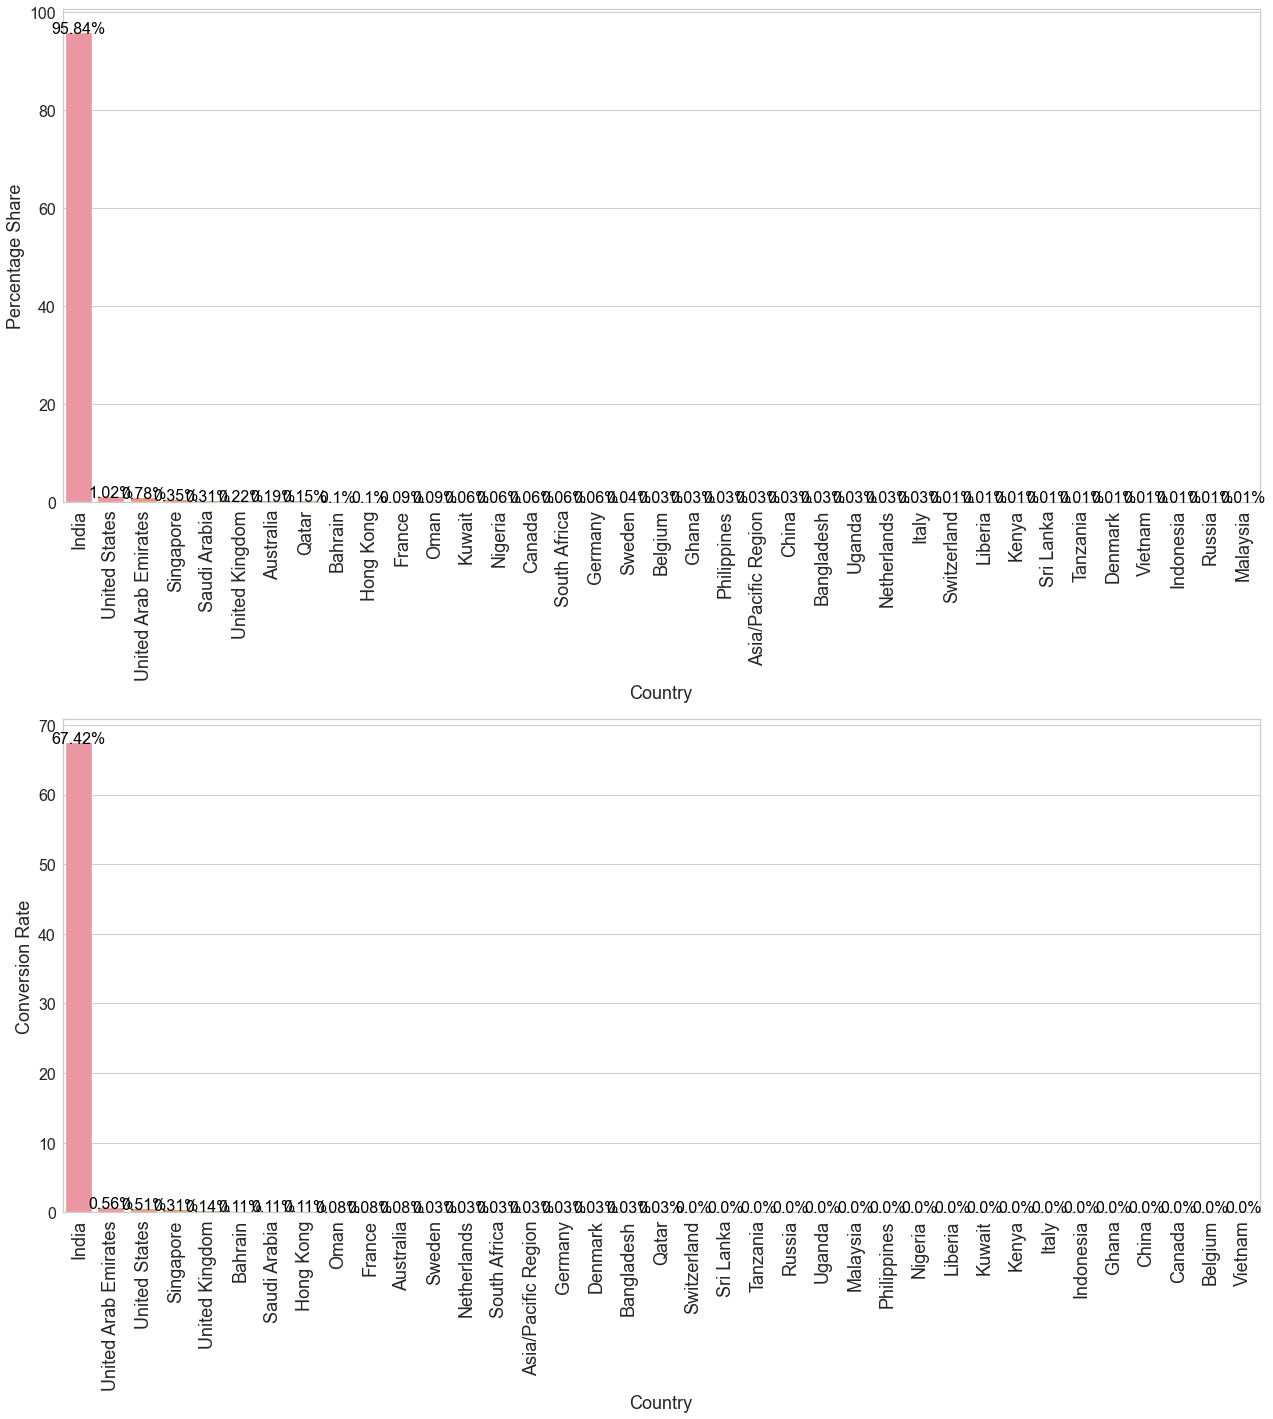

In [51]:
#missing value column
leads_country_grp_df1 = (leads['Country'].value_counts(normalize=True) * 100).rename_axis('Country').to_frame(target_col).reset_index()
leads_country_grp_df2 = (leads.groupby('Country')[target_col].sum()/sum(leads[target_col]) * 100).to_frame().sort_values(by=target_col, ascending=False).reset_index()
show_combined_plot('Country', target_col, leads_country_grp_df1, leads_country_grp_df2, figsize=(18, 20), tight_layout=True)

Majority of the traffic is coming from India

In [52]:
leads['Country'] = leads['Country'].replace(np.nan, 'India')

Replace missing values in country with India

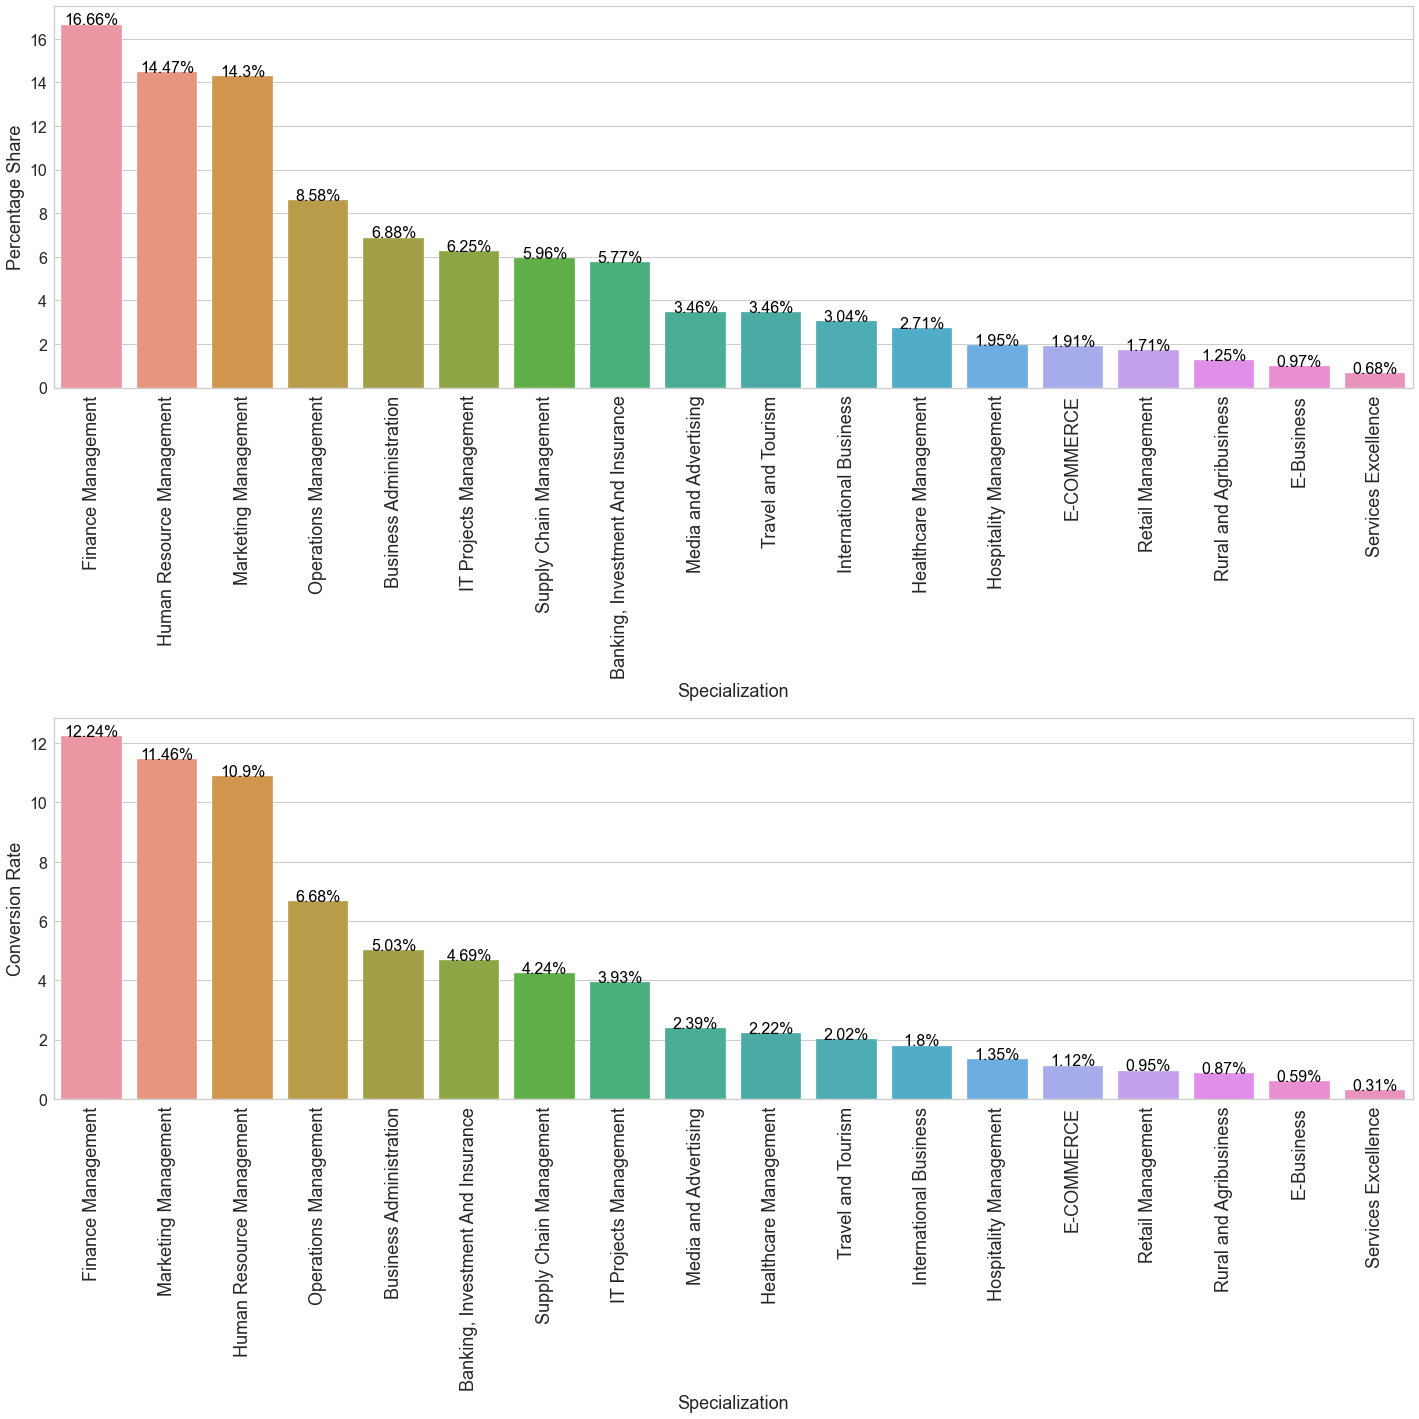

In [53]:
#missing value column
leads_spec_grp_df1 = (leads['Specialization'].value_counts(normalize=True) * 100).rename_axis('Specialization').to_frame(target_col).reset_index()
leads_spec_grp_df2 = (leads.groupby('Specialization')[target_col].sum()/sum(leads[target_col]) * 100).to_frame().sort_values(by=target_col, ascending=False).reset_index()
show_combined_plot('Specialization', target_col, leads_spec_grp_df1, leads_spec_grp_df2, tight_layout=True,figsize=(20,20))

Finance and Marketing Management have very close con. rates

In [54]:
leads['Specialization'] = leads['Specialization'].replace(np.nan, 'na_specialization')

Missing values in specialization are replaces with na_specialization

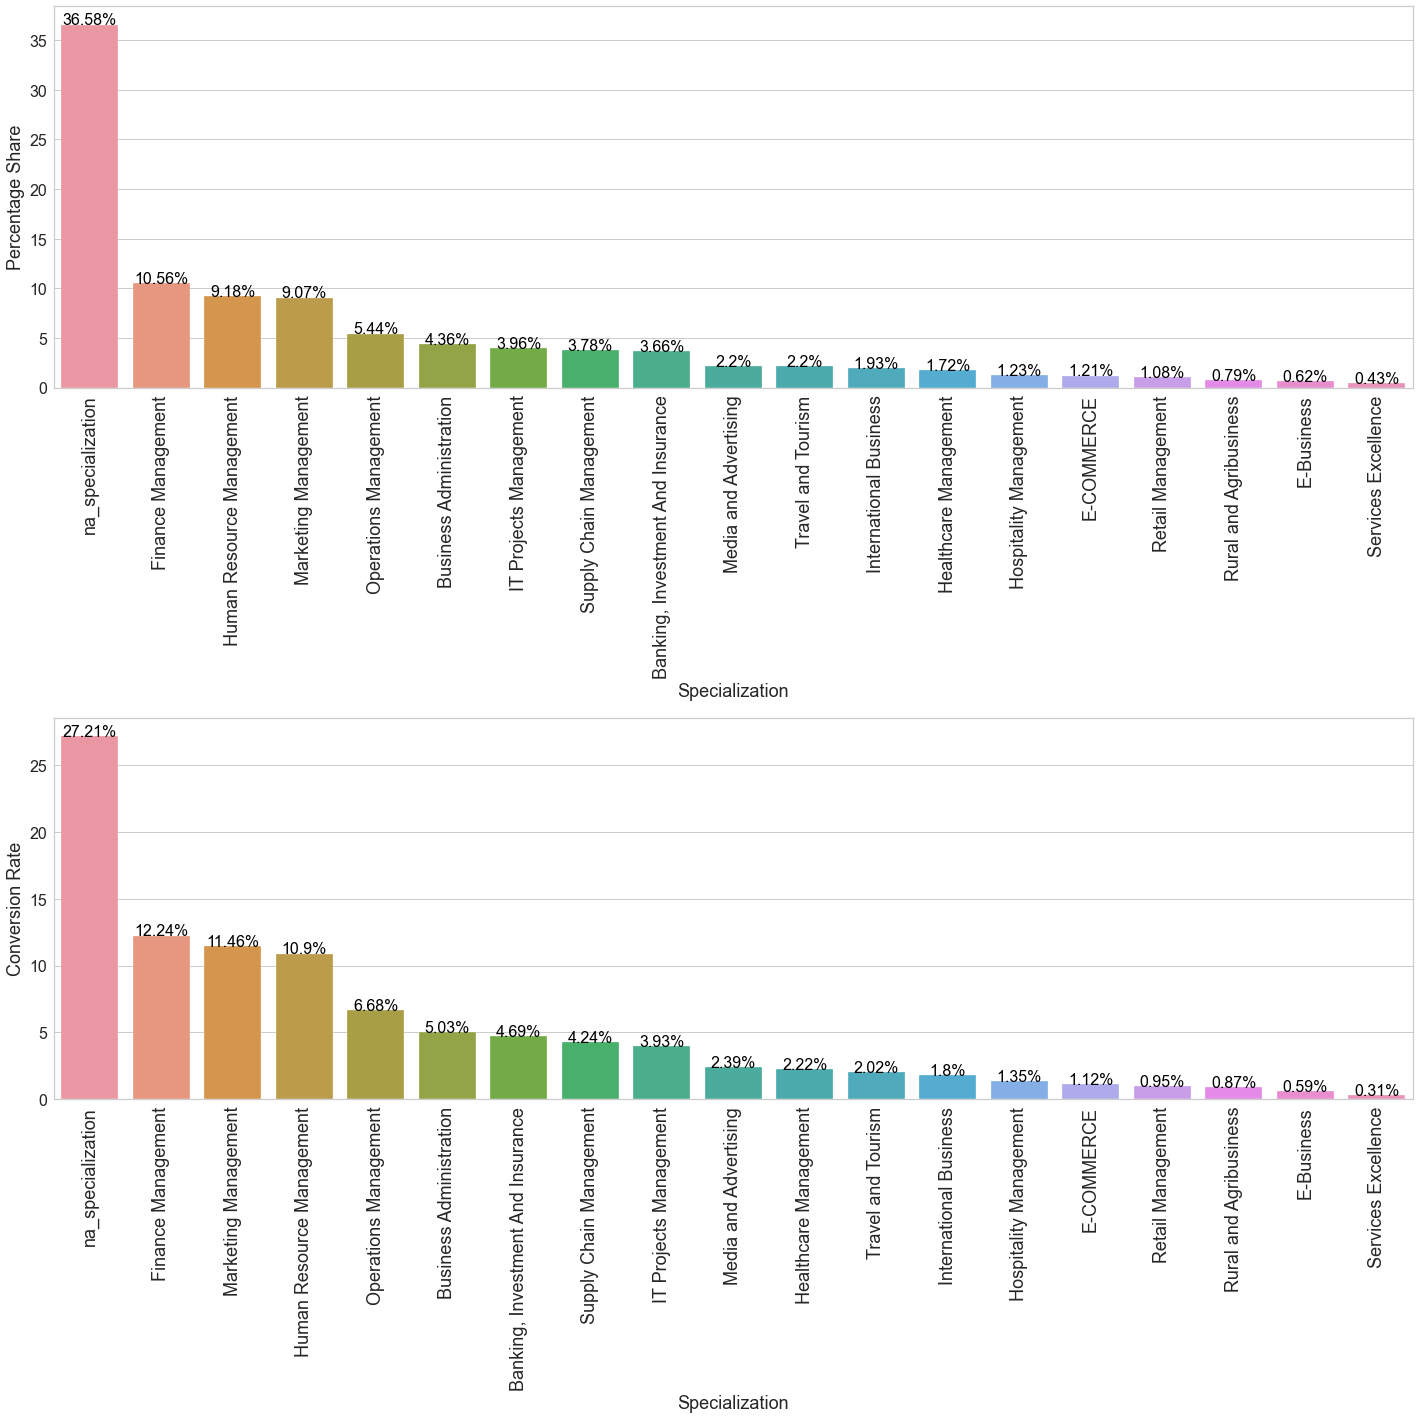

In [55]:
#After imputation
leads_spec_grp_df1 = (leads['Specialization'].value_counts(normalize=True) * 100).rename_axis('Specialization').to_frame(target_col).reset_index()
leads_spec_grp_df2 = (leads.groupby('Specialization')[target_col].sum()/sum(leads[target_col]) * 100).to_frame().sort_values(by=target_col, ascending=False).reset_index()
show_combined_plot('Specialization', target_col, leads_spec_grp_df1, leads_spec_grp_df2, tight_layout=True,figsize=(20,20))

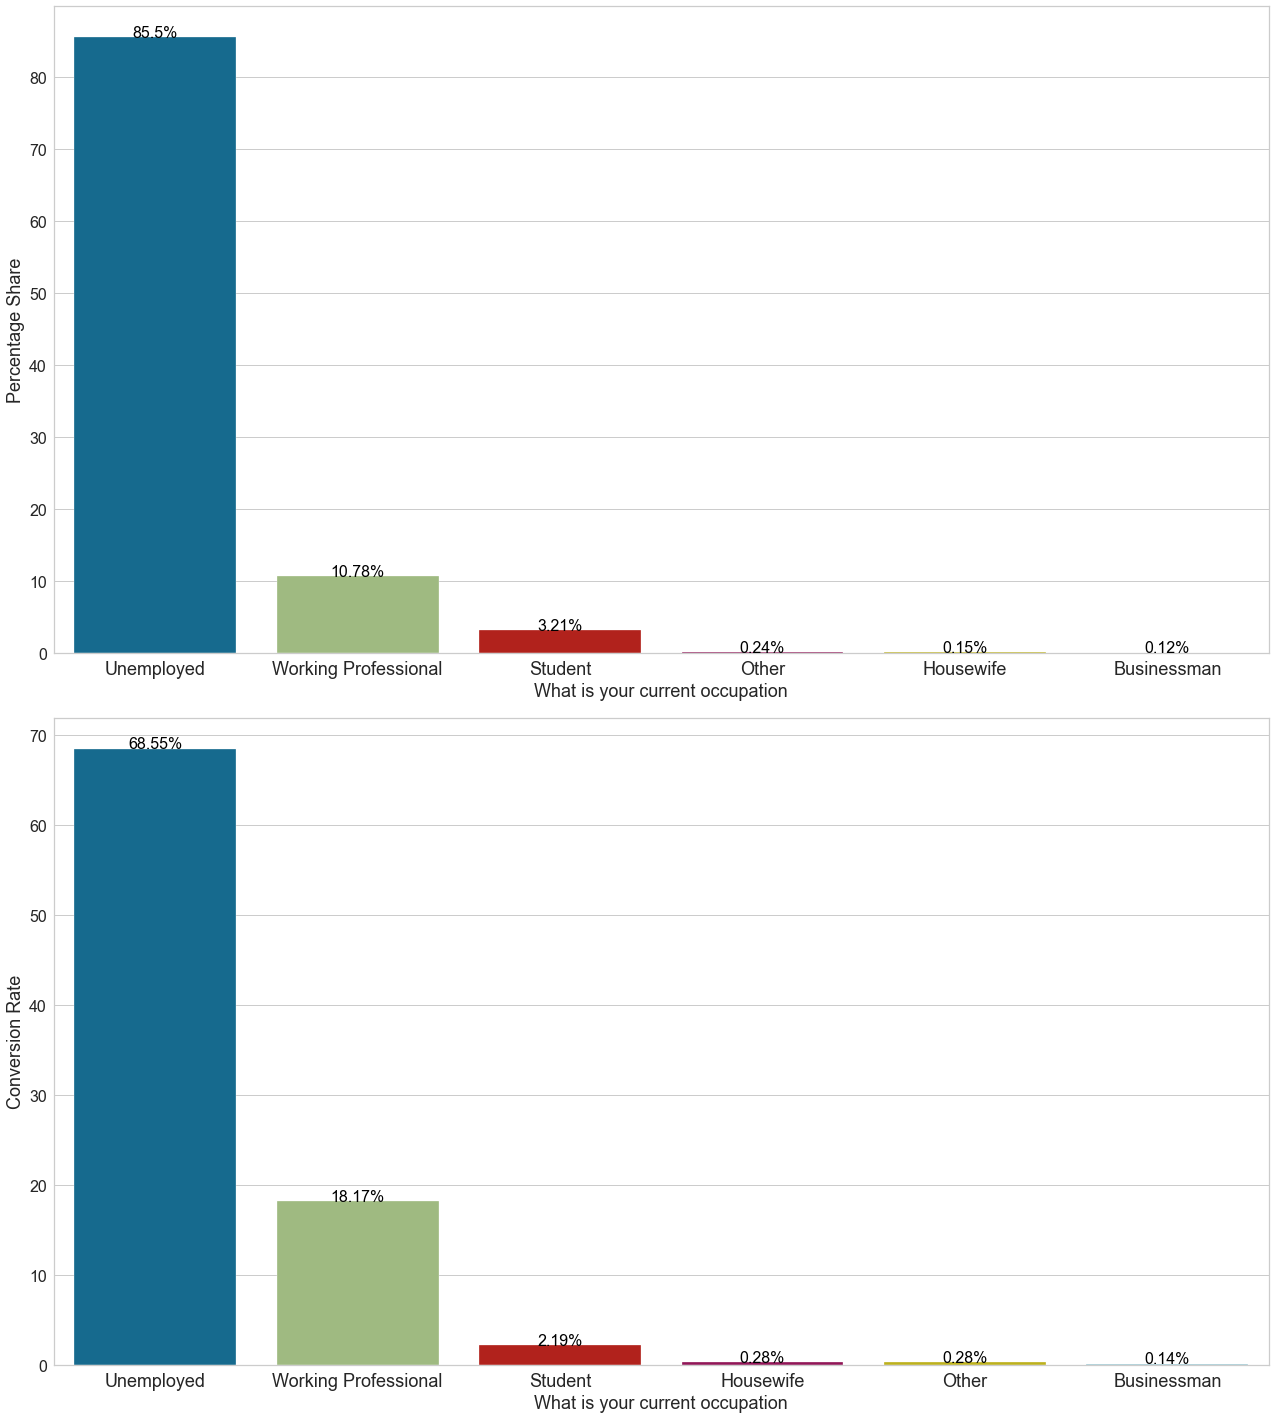

In [56]:
#missing value column
leads_co_grp_df1 = (leads['What is your current occupation'].value_counts(normalize=True) * 100).rename_axis('What is your current occupation').to_frame(target_col).reset_index()
leads_co_grp_df2 = (leads.groupby('What is your current occupation')[target_col].sum()/sum(leads[target_col]) * 100).to_frame().sort_values(by=target_col, ascending=False).reset_index()
show_combined_plot('What is your current occupation', target_col, leads_co_grp_df1, leads_co_grp_df2,figsize=(18,20))

Even though X education is for working professionals. Max. users who are converting are Unemployed

In [57]:
leads['What is your current occupation'] = leads['What is your current occupation'].replace(np.nan, 'Unemployed')

Replaced missing values in What is your current occupation columns wiht Unemployed

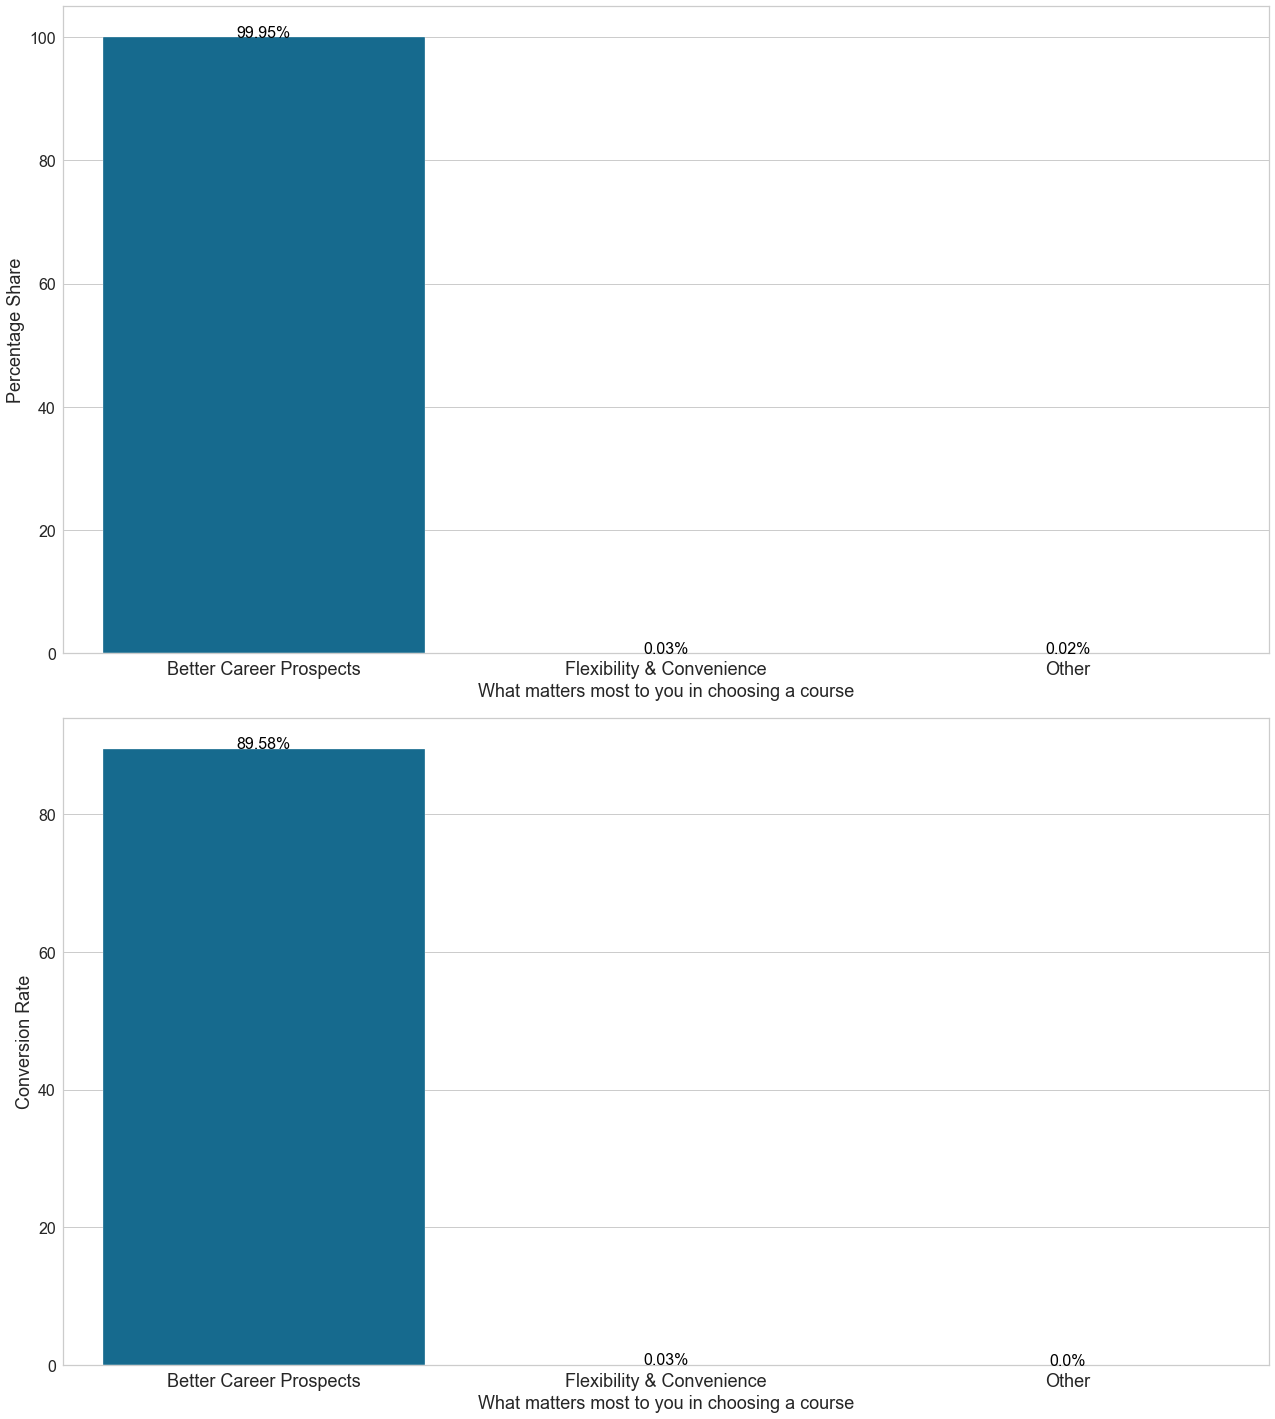

In [58]:
#missing value column
leads_mty_grp_df1 = (leads['What matters most to you in choosing a course'].value_counts(normalize=True) * 100).rename_axis('What matters most to you in choosing a course').to_frame(target_col).reset_index()
leads_mty_grp_df2 = (leads.groupby('What matters most to you in choosing a course')[target_col].sum()/sum(leads[target_col]) * 100).to_frame().sort_values(by=target_col, ascending=False).reset_index()
show_combined_plot('What matters most to you in choosing a course', target_col, leads_mty_grp_df1, leads_mty_grp_df2,figsize=(18,20))

Majority of people are looking for better career prospects

In [59]:
leads['What matters most to you in choosing a course'] = leads['What matters most to you in choosing a course'].replace(np.nan, 'Better Career Prospects')

Replaced missing values in What matters most to you in choosing a course column with Better Career Prospects

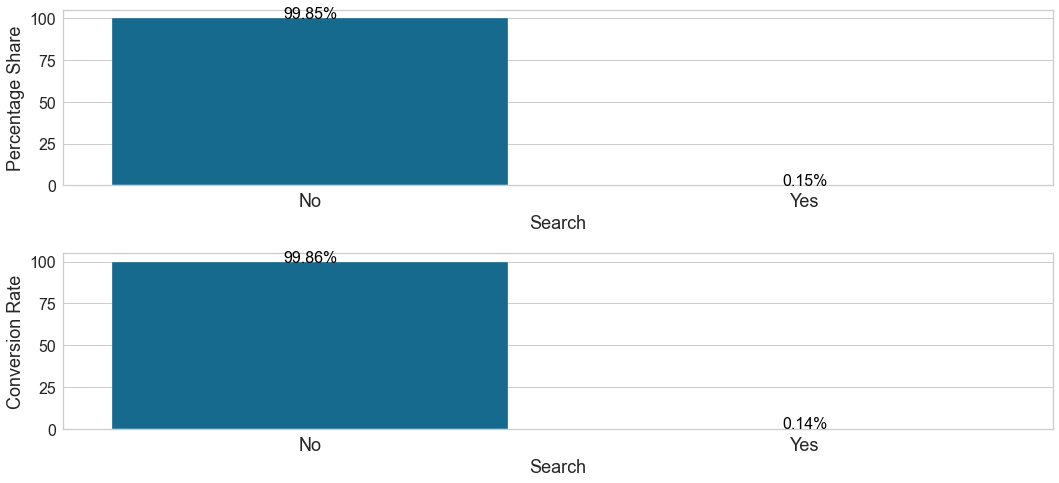

In [60]:
leads_search_grp_df1 = (leads['Search'].value_counts(normalize=True) * 100).rename_axis('Search').to_frame(target_col).reset_index()
leads_search_grp_df2 = (leads.groupby('Search')[target_col].sum()/sum(leads[target_col]) * 100).to_frame().sort_values(by=target_col, ascending=False).reset_index()
show_combined_plot('Search', target_col, leads_search_grp_df1, leads_search_grp_df2)

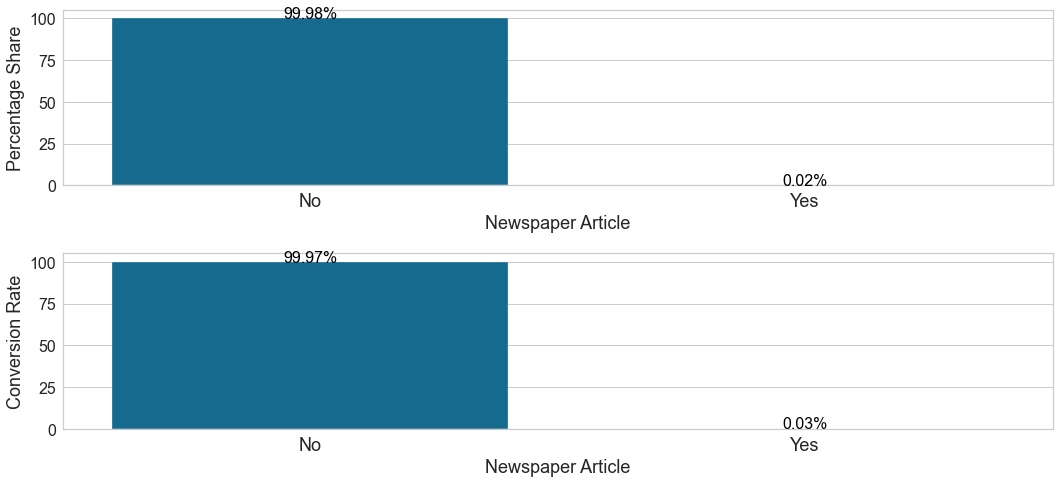

In [61]:
leads_na_grp_df1 = (leads['Newspaper Article'].value_counts(normalize=True) * 100).rename_axis('Newspaper Article').to_frame(target_col).reset_index()
leads_na_grp_df2 = (leads.groupby('Newspaper Article')[target_col].sum()/sum(leads[target_col]) * 100).to_frame().sort_values(by=target_col, ascending=False).reset_index()
show_combined_plot('Newspaper Article', target_col, leads_na_grp_df1, leads_na_grp_df2)

In [62]:
leads[['Search', 'Newspaper Article', 'X Education Forums', 'Newspaper','Digital Advertisement', 'Through Recommendations']].describe()

Search Newspaper Article X Education Forums Newspaper  \
count    9240              9240               9240      9240   
unique      2                 2                  2         2   
top        No                No                 No        No   
freq     9226              9238               9239      9239   

       Digital Advertisement Through Recommendations  
count                   9240                    9240  
unique                     2                       2  
top                       No                      No  
freq                    9236                    9233

Maximum values of these columns have 'No' values

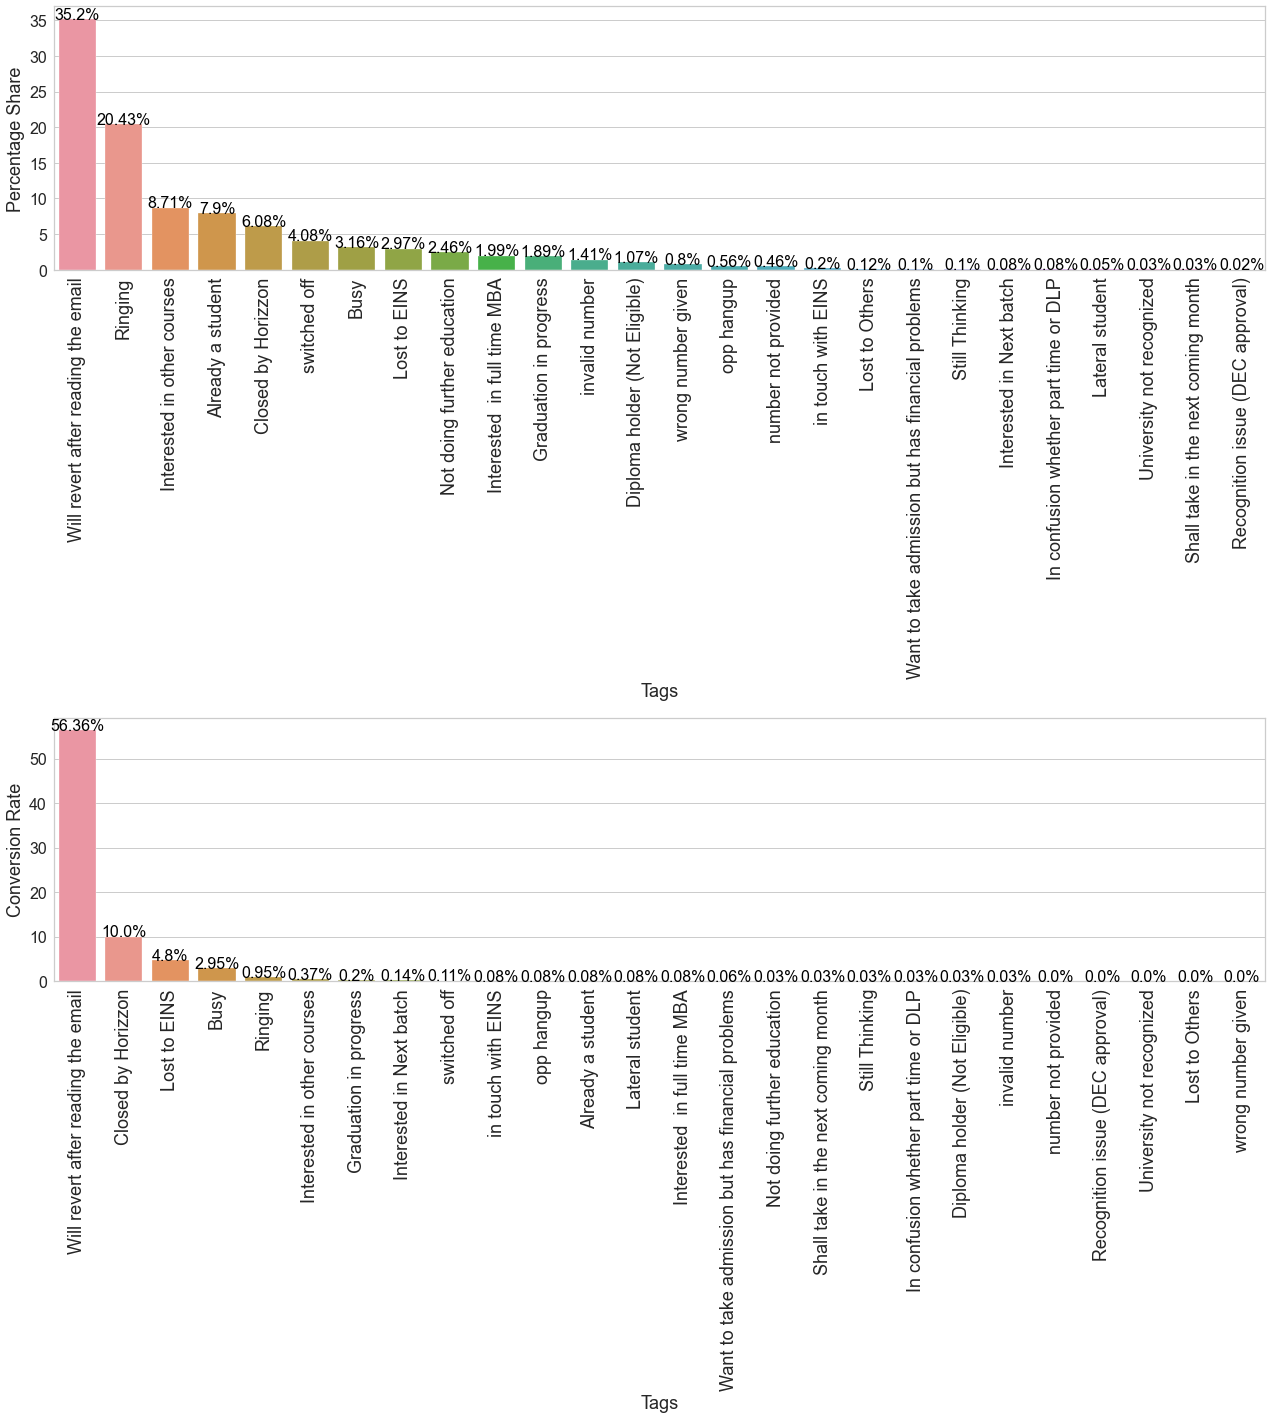

In [63]:
#missing value column
leads_tags_grp_df1 = (leads['Tags'].value_counts(normalize=True) * 100).rename_axis('Tags').to_frame(target_col).reset_index()
leads_tags_grp_df2 = (leads.groupby('Tags')[target_col].sum()/sum(leads[target_col]) * 100).to_frame().sort_values(by=target_col, ascending=False).reset_index()
show_combined_plot('Tags', target_col, leads_tags_grp_df1, leads_tags_grp_df2, tight_layout=True,figsize=(18,20))

Ringing has very high per share but the con rate is very low

In [64]:
leads['Tags'] = leads['Tags'].replace(np.nan, 'na_tags')

Replacing missing values in Tags column with na_tags

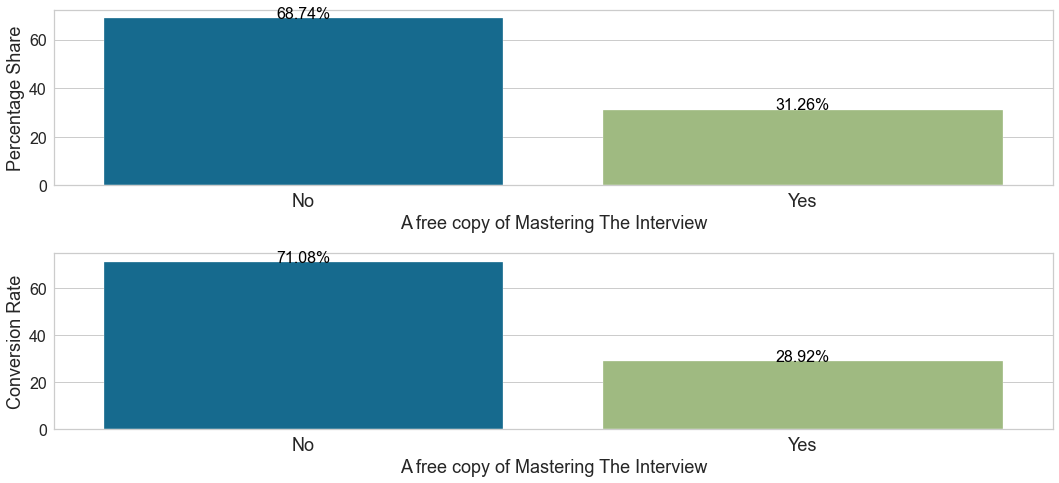

In [65]:
leads_cp_mti_grp_df1 = (leads['A free copy of Mastering The Interview'].value_counts(normalize=True) * 100).rename_axis('A free copy of Mastering The Interview').to_frame(target_col).reset_index()
leads_cp_mti_grp_df2 = (leads.groupby('A free copy of Mastering The Interview')[target_col].sum()/sum(leads[target_col]) * 100).to_frame().sort_values(by=target_col, ascending=False).reset_index()
show_combined_plot('A free copy of Mastering The Interview', target_col, leads_cp_mti_grp_df1, leads_cp_mti_grp_df2)

Whether or not people are opting for a book copy is not relevant in deciding the conversion of the individual

In [66]:
leads.columns

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call',
       'Converted', 'TotalVisits', 'Total Time Spent on Website',
       'Page Views Per Visit', 'Last Activity', 'Country', 'Specialization',
       'What is your current occupation',
       'What matters most to you in choosing a course', 'Search',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations', 'Tags',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

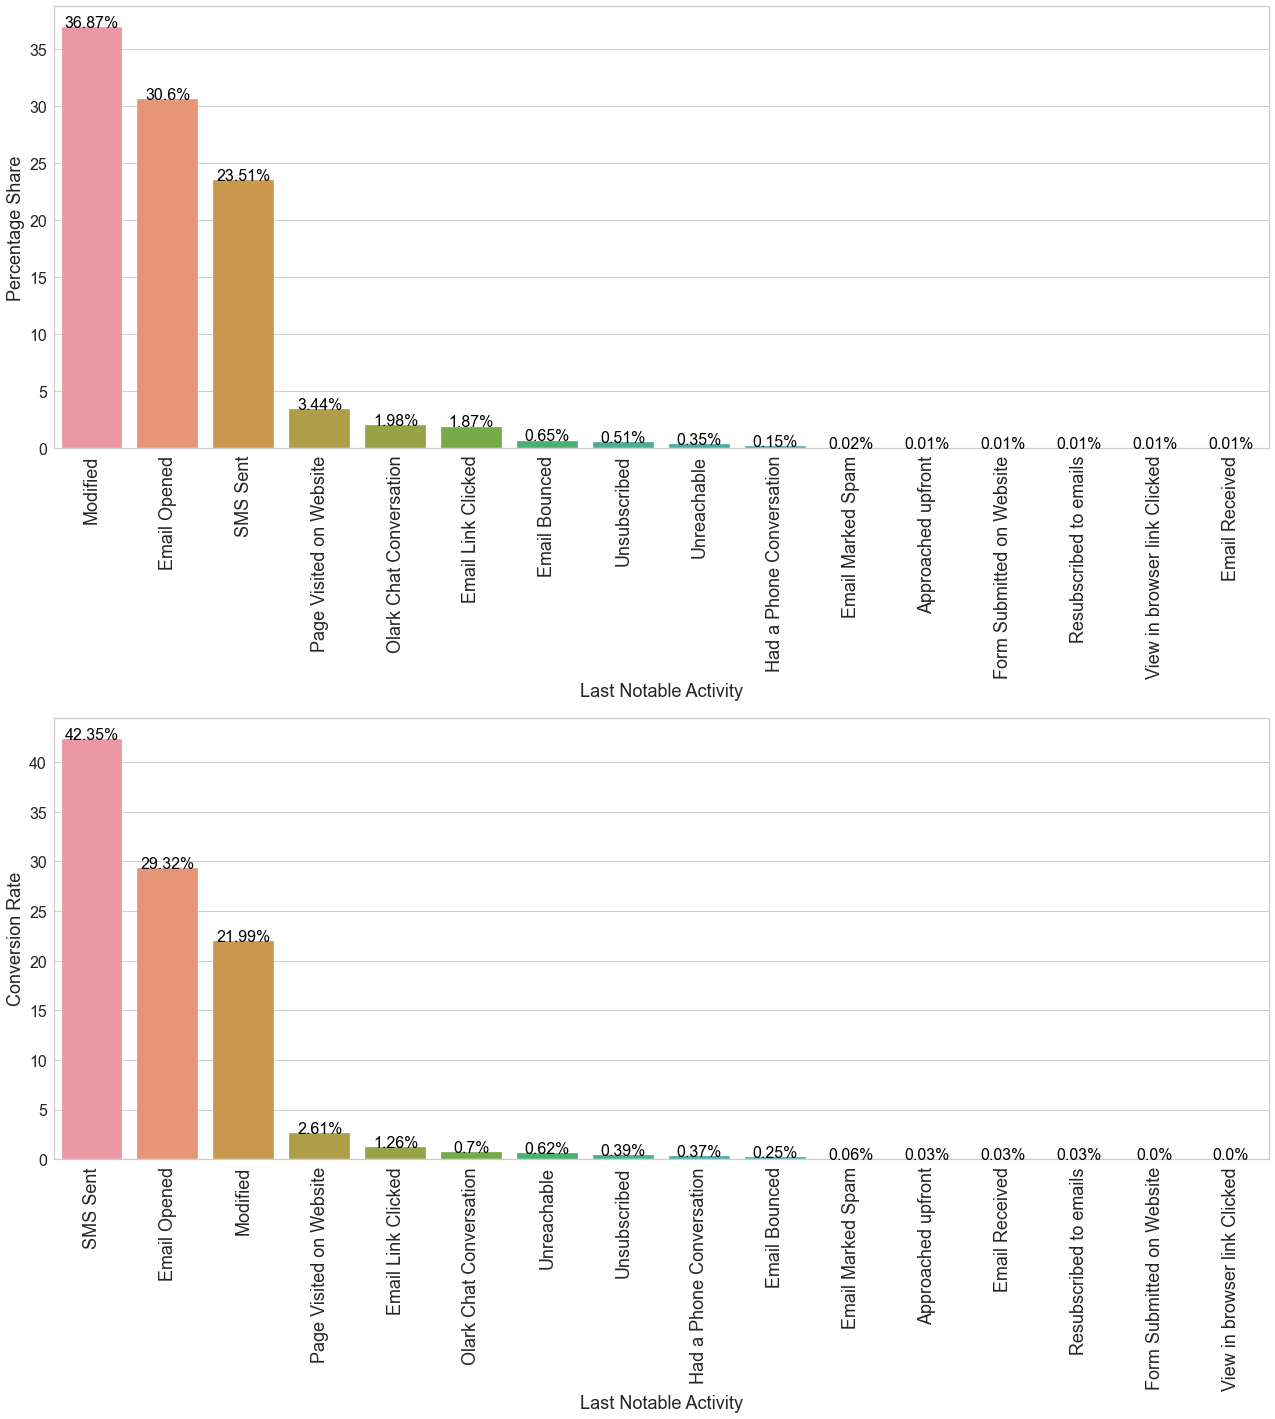

In [67]:
leads_lna_grp_df1 = (leads['Last Notable Activity'].value_counts(normalize=True) * 100).rename_axis('Last Notable Activity').to_frame(target_col).reset_index()
leads_lna_grp_df2 = (leads.groupby('Last Notable Activity')[target_col].sum()/sum(leads[target_col]) * 100).to_frame().sort_values(by=target_col, ascending=False).reset_index()
show_combined_plot('Last Notable Activity', target_col, leads_lna_grp_df1, leads_lna_grp_df2, figsize=(18,20), tight_layout=True)

SMS Sent has the major share

Trend Reverses with Modified con rate being very low but highest per share

In [68]:
numerical_cols

['Page Views Per Visit', 'Total Time Spent on Website', 'TotalVisits']

In [69]:
def plot_boxplot(df, cols, hue=None):
    for col in cols:
        plt.figure(figsize=(10,5))
        plt.title('%s boxplot' %col)
        if hue != None:
            sns.boxplot(y=df[col], x=df[hue])
        else:
            sns.boxplot(x=df[col])
        plt.show()

### Outlier Analysis

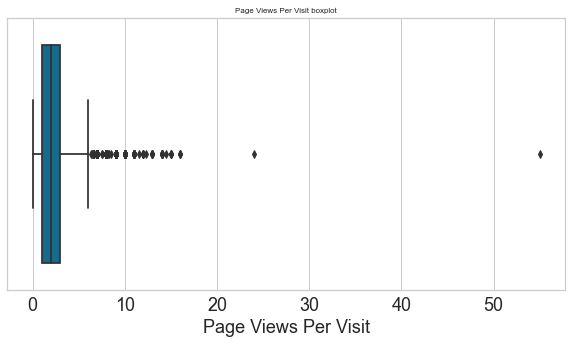

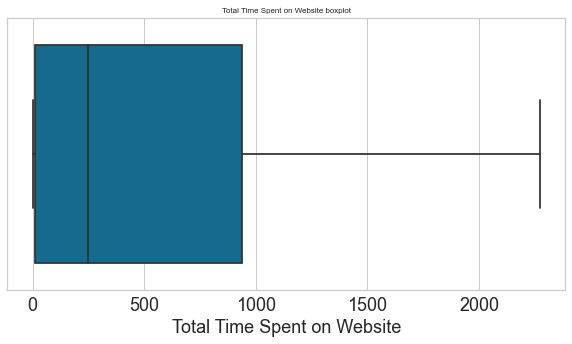

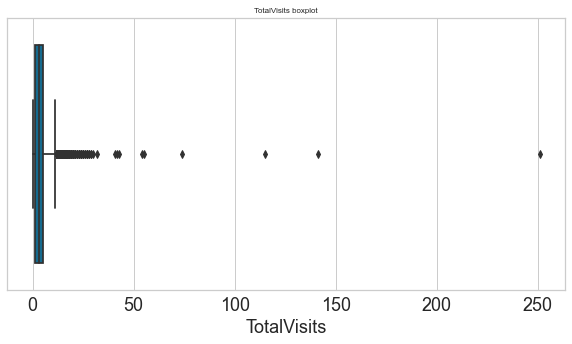

In [70]:
plot_boxplot(leads, numerical_cols)

Outliers exists in Page view per visit and TotalVisits

In [71]:
leads[numerical_cols].describe()

Page Views Per Visit  Total Time Spent on Website  TotalVisits
count           9240.000000                  9240.000000  9240.000000
mean               2.357440                   487.698268     3.438636
std                2.145781                   548.021466     4.819024
min                0.000000                     0.000000     0.000000
25%                1.000000                    12.000000     1.000000
50%                2.000000                   248.000000     3.000000
75%                3.000000                   936.000000     5.000000
max               55.000000                  2272.000000   251.000000

In [72]:
def bar_plot(x, y, data, title, figsize=(10,5), tight_layout=False):
    plt.figure(figsize=figsize)
    plt.title(title)
    sns.barplot(x=x, y=y, data=data)
    plt.tight_layout()
    if tight_layout:
        plt.xticks(rotation=90)
    plt.show()

In [73]:
leads.columns

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call',
       'Converted', 'TotalVisits', 'Total Time Spent on Website',
       'Page Views Per Visit', 'Last Activity', 'Country', 'Specialization',
       'What is your current occupation',
       'What matters most to you in choosing a course', 'Search',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations', 'Tags',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

#### Conversion rate with mean values of numerical columns

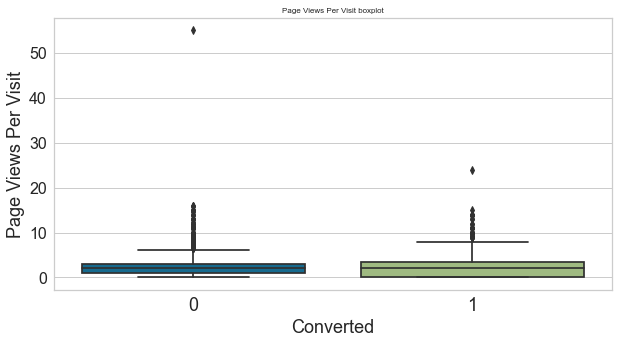

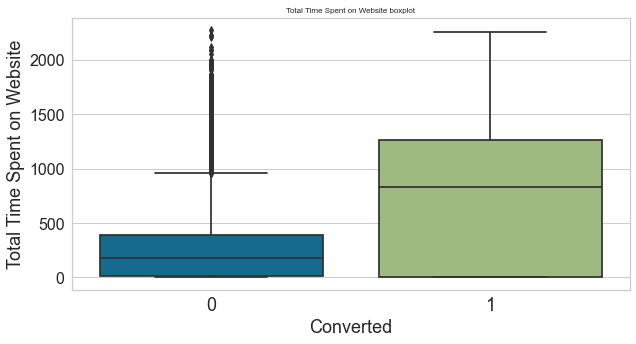

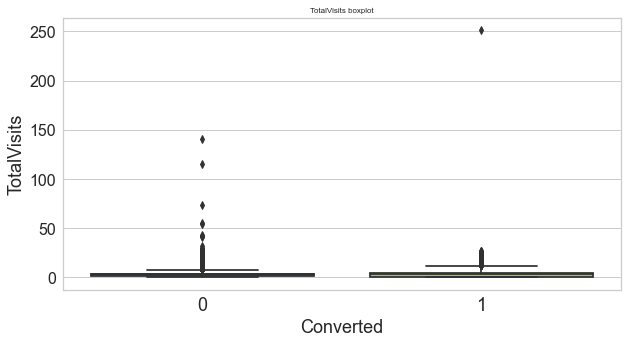

In [74]:
plot_boxplot(leads, numerical_cols, hue=target_col)

In [75]:
converted_df = leads[leads['Converted'] == 1]

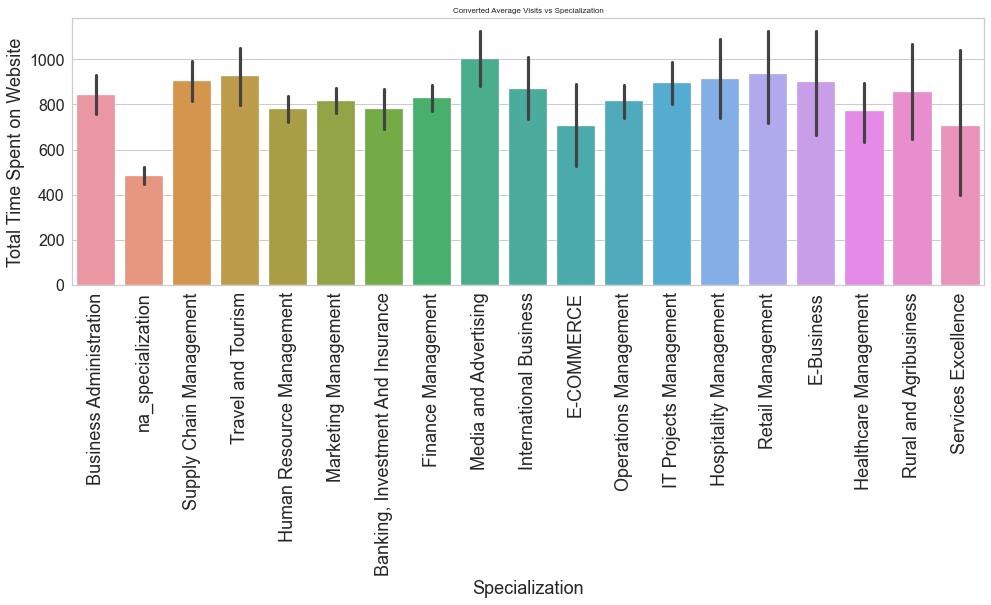

In [76]:
bar_plot('Specialization', 'Total Time Spent on Website', converted_df, 'Converted Average Visits vs Specialization', figsize=(15,5), tight_layout=True)

Average time spent on website varies around 800 across specialization

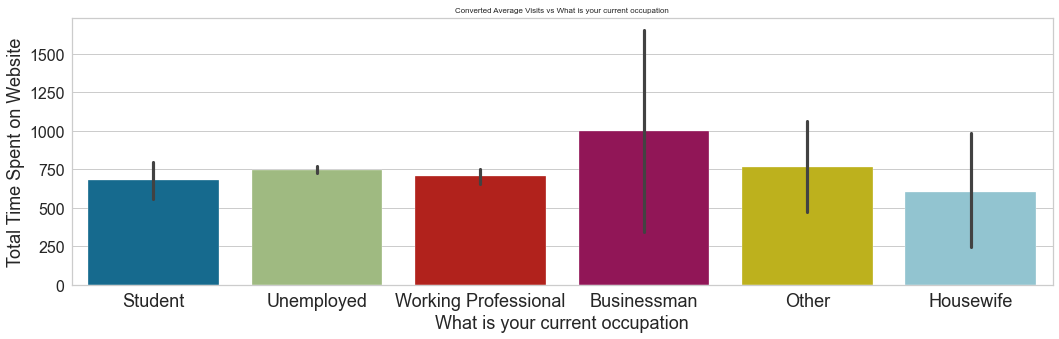

In [77]:
bar_plot('What is your current occupation', 'Total Time Spent on Website', converted_df, 'Converted Average Visits vs What is your current occupation', figsize=(15,5))

Businessman are spending more time on website

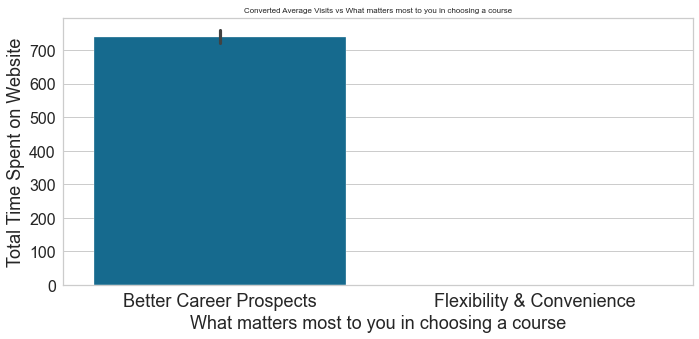

In [78]:
bar_plot('What matters most to you in choosing a course', 'Total Time Spent on Website', converted_df, 'Converted Average Visits vs What matters most to you in choosing a course')

People who are looking for better career prospects are spending more time on the website

In [80]:
missing_leads = get_missing_report(leads)
missing_leads

columns  missing_perc     type
0                                     Lead Origin           0.0   object
1                                     Lead Source           0.0   object
20         A free copy of Mastering The Interview           0.0   object
19                                           Tags           0.0   object
18                        Through Recommendations           0.0   object
17                          Digital Advertisement           0.0   object
16                                      Newspaper           0.0   object
15                             X Education Forums           0.0   object
14                              Newspaper Article           0.0   object
13                                         Search           0.0   object
12  What matters most to you in choosing a course           0.0   object
11                What is your current occupation           0.0   object
10                                 Specialization           0.0   object
9                                         Country           0.0   object
8                                   Last Activity           0.0   object
7                            Page Views Per Visit           0.0  float64
6                     Total Time Spent on Website           0.0    int64
5                                     TotalVisits           0.0  float64
4                                       Converted           0.0    int64
3                                     Do Not Call           0.0   object
2                                    Do Not Email           0.0   object
21                          Last Notable Activity           0.0   object

In [81]:
leads_cleaned = leads.copy()

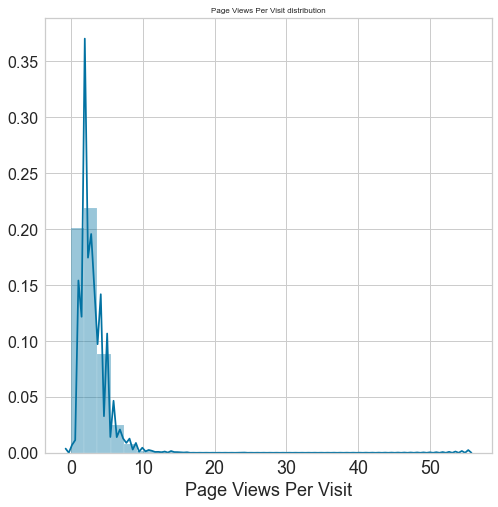

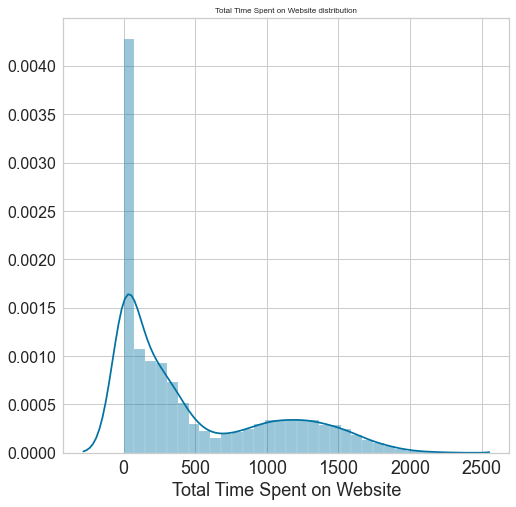

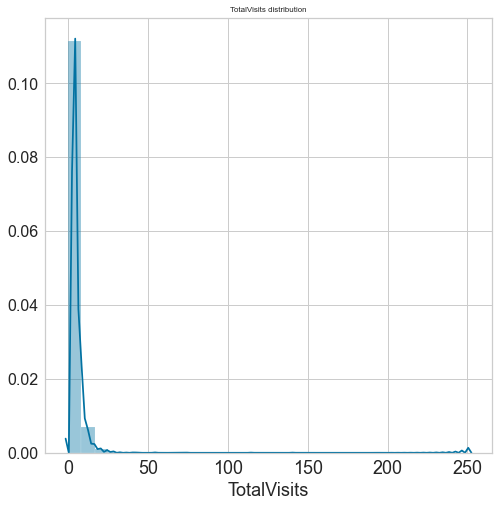

In [82]:
plot_distribution(leads_cleaned, numerical_cols)

In [83]:
leads_cleaned[numerical_cols]

Page Views Per Visit  Total Time Spent on Website  TotalVisits
0                     0.00                            0          0.0
1                     2.50                          674          5.0
2                     2.00                         1532          2.0
3                     1.00                          305          1.0
4                     1.00                         1428          2.0
...                    ...                          ...          ...
9235                  2.67                         1845          8.0
9236                  2.00                          238          2.0
9237                  2.00                          199          2.0
9238                  3.00                          499          3.0
9239                  3.00                         1279          6.0

[9240 rows x 3 columns]

In [84]:
leads_df_copy = leads_cleaned.copy()

#### Scaling numerical data using QuantileTransformer

Correcting outlier with QuantileTransformer

In [85]:
qt_transformer = QuantileTransformer()

In [86]:
qt_num_df = pd.DataFrame(qt_transformer.fit_transform(leads_df_copy[numerical_cols]), columns=numerical_cols)
qt_num_df

Page Views Per Visit  Total Time Spent on Website  TotalVisits
0                 0.000000                     0.000000     0.000000
1                 0.602102                     0.692445     0.781281
2                 0.472472                     0.943187     0.370370
3                 0.271772                     0.549550     0.258258
4                 0.271772                     0.913774     0.370370
...                    ...                          ...          ...
9235              0.619119                     0.990475     0.919419
9236              0.472472                     0.489489     0.370370
9237              0.472472                     0.451451     0.370370
9238              0.689690                     0.656657     0.539540
9239              0.689690                     0.865199     0.848849

[9240 rows x 3 columns]

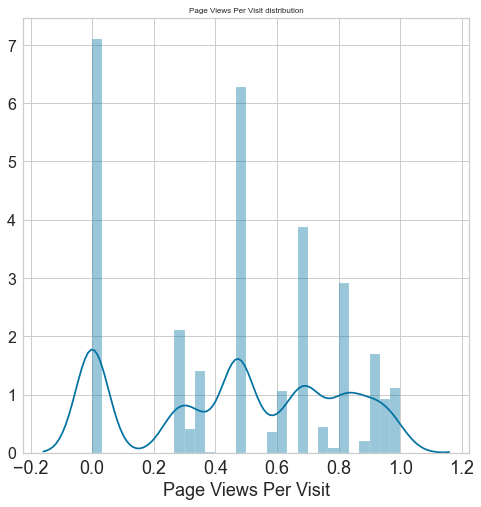

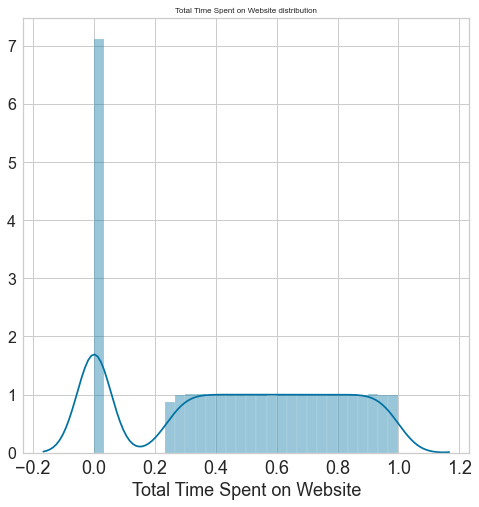

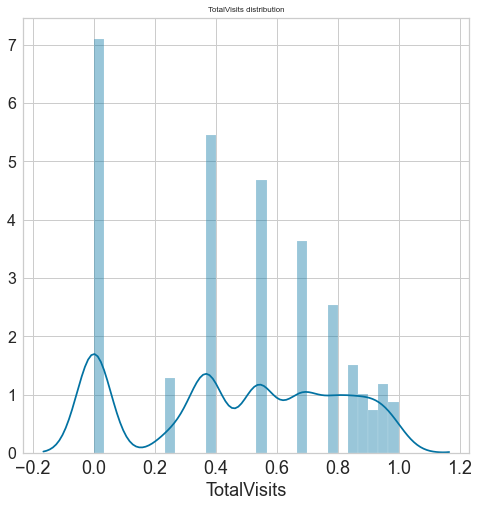

In [87]:
plot_distribution(qt_num_df, numerical_cols)

In [88]:
leads_df_copy[numerical_cols] = qt_num_df[numerical_cols]

In [89]:
corr_cols = []
corr_cols.extend(numerical_cols)
corr_cols.append(target_col)
corr_cols

['Page Views Per Visit',
 'Total Time Spent on Website',
 'TotalVisits',
 'Converted']

### Correlation 

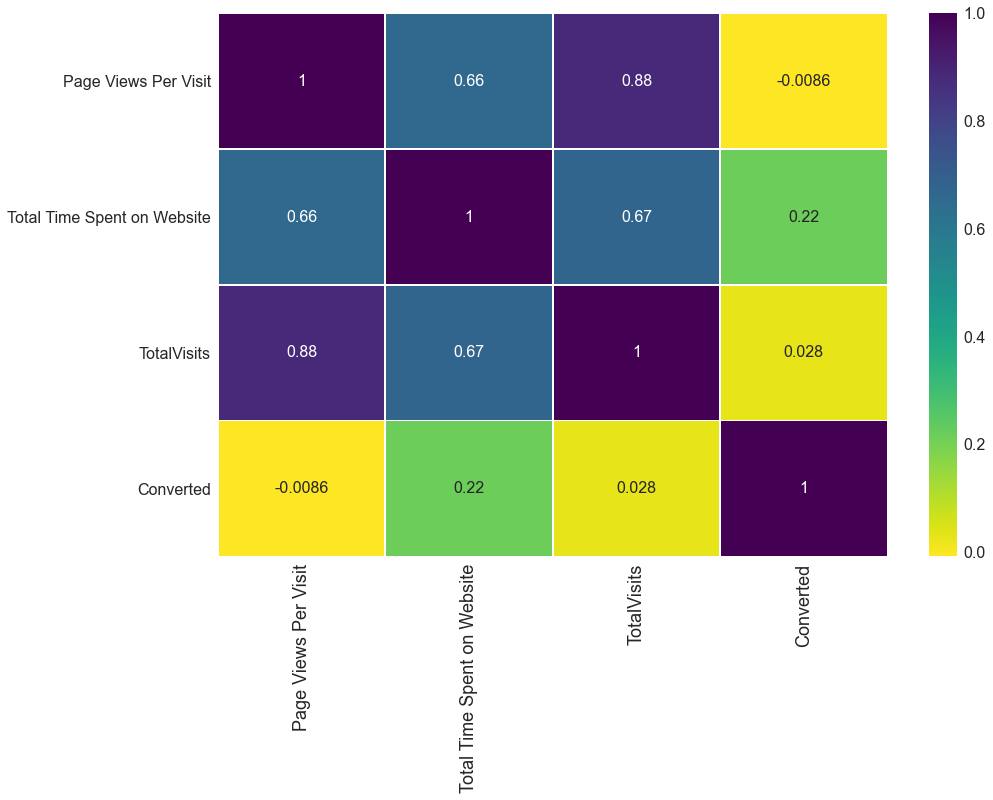

In [90]:
plt.figure(figsize=(15,10))
sns.heatmap(leads_df_copy[corr_cols].corr(), annot=True, linecolor='white', linewidths=0.8, cmap='viridis_r')
plt.show()

In [91]:
leads_df_copy

Lead Origin     Lead Source Do Not Email Do Not Call  \
0                         API      Olark Chat           No          No   
1                         API  Organic Search           No          No   
2     Landing Page Submission  Direct Traffic           No          No   
3     Landing Page Submission  Direct Traffic           No          No   
4     Landing Page Submission          Google           No          No   
...                       ...             ...          ...         ...   
9235  Landing Page Submission  Direct Traffic          Yes          No   
9236  Landing Page Submission  Direct Traffic           No          No   
9237  Landing Page Submission  Direct Traffic          Yes          No   
9238  Landing Page Submission          Google           No          No   
9239  Landing Page Submission  Direct Traffic           No          No   

      Converted  TotalVisits  Total Time Spent on Website  \
0             0     0.000000                     0.000000   
1             0     0.781281                     0.692445   
2             1     0.370370                     0.943187   
3             0     0.258258                     0.549550   
4             1     0.370370                     0.913774   
...         ...          ...                          ...   
9235          1     0.919419                     0.990475   
9236          0     0.370370                     0.489489   
9237          0     0.370370                     0.451451   
9238          1     0.539540                     0.656657   
9239          1     0.848849                     0.865199   

      Page Views Per Visit            Last Activity       Country  \
0                 0.000000  Page Visited on Website         India   
1                 0.602102             Email Opened         India   
2                 0.472472             Email Opened         India   
3                 0.271772              Unreachable         India   
4                 0.271772        Converted to Lead         India   
...                    ...                      ...           ...   
9235              0.619119        Email Marked Spam  Saudi Arabia   
9236              0.472472                 SMS Sent         India   
9237              0.472472                 SMS Sent         India   
9238              0.689690                 SMS Sent         India   
9239              0.689690                 SMS Sent    Bangladesh   

                 Specialization What is your current occupation  \
0             na_specialization                      Unemployed   
1             na_specialization                      Unemployed   
2       Business Administration                         Student   
3         Media and Advertising                      Unemployed   
4             na_specialization                      Unemployed   
...                         ...                             ...   
9235     IT Projects Management                      Unemployed   
9236      Media and Advertising                      Unemployed   
9237    Business Administration                      Unemployed   
9238  Human Resource Management                      Unemployed   
9239    Supply Chain Management                      Unemployed   

     What matters most to you in choosing a course Search Newspaper Article  \
0                          Better Career Prospects     No                No   
1                          Better Career Prospects     No                No   
2                          Better Career Prospects     No                No   
3                          Better Career Prospects     No                No   
4                          Better Career Prospects     No                No   
...                                            ...    ...               ...   
9235                       Better Career Prospects     No                No   
9236                       Better Career Prospects     No                No   
9237                       Better Career Prospects 

In [92]:
leads_df_copy.columns

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call',
       'Converted', 'TotalVisits', 'Total Time Spent on Website',
       'Page Views Per Visit', 'Last Activity', 'Country', 'Specialization',
       'What is your current occupation',
       'What matters most to you in choosing a course', 'Search',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations', 'Tags',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

# Model Training

#### Using some numerical columns

In [93]:
selected_cols = ['TotalVisits', 'Total Time Spent on Website']

In [94]:
data_for_model = leads_df_copy[selected_cols]
target_data = leads_df_copy[target_col]

In [95]:
data_for_model

TotalVisits  Total Time Spent on Website
0        0.000000                     0.000000
1        0.781281                     0.692445
2        0.370370                     0.943187
3        0.258258                     0.549550
4        0.370370                     0.913774
...           ...                          ...
9235     0.919419                     0.990475
9236     0.370370                     0.489489
9237     0.370370                     0.451451
9238     0.539540                     0.656657
9239     0.848849                     0.865199

[9240 rows x 2 columns]

#### Train test split

In [96]:
X_train, X_test, y_train, y_test = train_test_split(data_for_model, target_data, test_size=0.2, random_state=101)

#### Train Logistic Regression with Cross Validation

In [97]:
def train_cv(X_train, y_train):
    cv = cross_validate(estimator=LogisticRegression(), X=X_train, y=y_train, return_estimator=True, 
                          verbose=1, scoring={'auc': make_scorer(roc_auc_score), 'accuracy': make_scorer(accuracy_score)})
    return cv

In [98]:
cv = train_cv(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [99]:
cv

{'fit_time': array([0.0130055 , 0.00900054, 0.00899577, 0.00799155, 0.01000571]),
 'score_time': array([0.00399017, 0.00500751, 0.00400352, 0.0049932 , 0.00300193]),
 'estimator': (LogisticRegression(),
  LogisticRegression(),
  LogisticRegression(),
  LogisticRegression(),
  LogisticRegression()),
 'test_auc': array([0.59963127, 0.59337653, 0.6084085 , 0.59947303, 0.58009209]),
 'test_accuracy': array([0.66193374, 0.65382015, 0.6691475 , 0.66305819, 0.64343708])}

In [100]:
trained_logit_model = cv['estimator'][2]
y_test_pred = trained_logit_model.predict(X_test)
y_test_pred_prob = trained_logit_model.predict_proba(X_test)

In [101]:
def show_model_summary(model_name, y_true, y_pred, y_pred_prob):
        
        print('\n\n===========================================\n\n')
        
        print('%s model summary' %model_name)
        print('Classification Report: ')
        print(classification_report(y_true, y_pred))
        print('Confusion Matrix: ')
        print(confusion_matrix(y_true, y_pred))
        print('Logloss: ', log_loss(y_true, y_pred_prob[:, 1]))
        
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)        
        auc_score = roc_auc_score(y_true, y_pred_prob[:, 1])
        print('auc: ', auc_score)
        
        matrix = confusion_matrix(y_true, y_pred).ravel()
        tn, fp, fn, tp = matrix
        sensitivity = tp / (tp + fn)
        print('sensitivity: ', sensitivity)
        
        print('\n\n===========================================\n\n')

#### Checking model summary

In [102]:
show_model_summary('Logit Model-1', y_test, y_test_pred, y_test_pred_prob)





Logit Model-1 model summary
Classification Report: 
              precision    recall  f1-score   support

           0       0.67      0.90      0.77      1125
           1       0.67      0.32      0.43       723

    accuracy                           0.67      1848
   macro avg       0.67      0.61      0.60      1848
weighted avg       0.67      0.67      0.64      1848

Confusion Matrix: 
[[1013  112]
 [ 493  230]]
Logloss:  0.6248556455571694
auc:  0.6653855847548793
sensitivity:  0.318118948824343






#### Plot ROC-AUC Curve

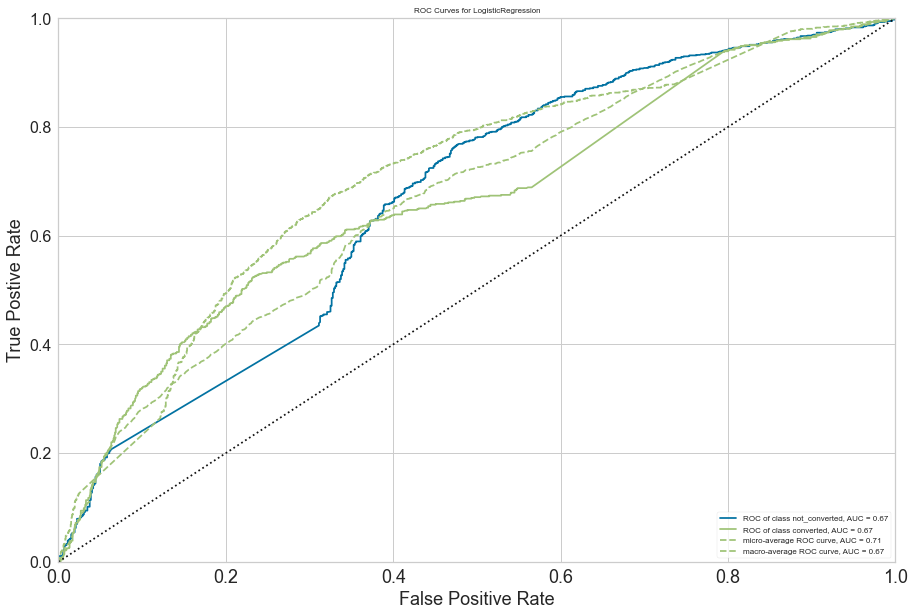

In [103]:
plt.figure(figsize=(15,10))
visualizer = ROCAUC(trained_logit_model, classes=["not_converted", "converted"])
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()       
plt.show()

#### Oversampling

We have slighlty imbalanced data. Making it balanced

In [104]:
smote  = SMOTE()
X_train, y_train = smote.fit_sample(X_train, y_train)

#### Running cross validation in Logistic Regression with new oversampled data

In [105]:
cv = cross_validate(estimator=LogisticRegression(), X=X_train, y=y_train, return_estimator=True, verbose=1, 
                    scoring={'auc': make_scorer(roc_auc_score), 'accuracy': make_scorer(accuracy_score)})
cv

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


{'fit_time': array([0.0100019 , 0.01200438, 0.01096082, 0.00899696, 0.01100945]),
 'score_time': array([0.00599408, 0.00413609, 0.00399995, 0.00400162, 0.0039916 ]),
 'estimator': (LogisticRegression(),
  LogisticRegression(),
  LogisticRegression(),
  LogisticRegression(),
  LogisticRegression()),
 'test_auc': array([0.61251372, 0.62403952, 0.60757409, 0.59798072, 0.61068745]),
 'test_accuracy': array([0.61251372, 0.62403952, 0.60757409, 0.59802306, 0.61065349])}

#### Check summary

In [106]:
trained_logit_model = cv['estimator'][1]
y_test_pred = trained_logit_model.predict(X_test)
y_test_pred_prob = trained_logit_model.predict_proba(X_test)

show_model_summary('Logit Model-1_SMT', y_test, y_test_pred, y_test_pred_prob)





Logit Model-1_SMT model summary
Classification Report: 
              precision    recall  f1-score   support

           0       0.71      0.69      0.70      1125
           1       0.54      0.57      0.55       723

    accuracy                           0.64      1848
   macro avg       0.63      0.63      0.63      1848
weighted avg       0.65      0.64      0.64      1848

Confusion Matrix: 
[[775 350]
 [312 411]]
Logloss:  0.6450812097270305
auc:  0.6657913016751191
sensitivity:  0.5684647302904564






After oversampling. Sensitivity of the model increased.

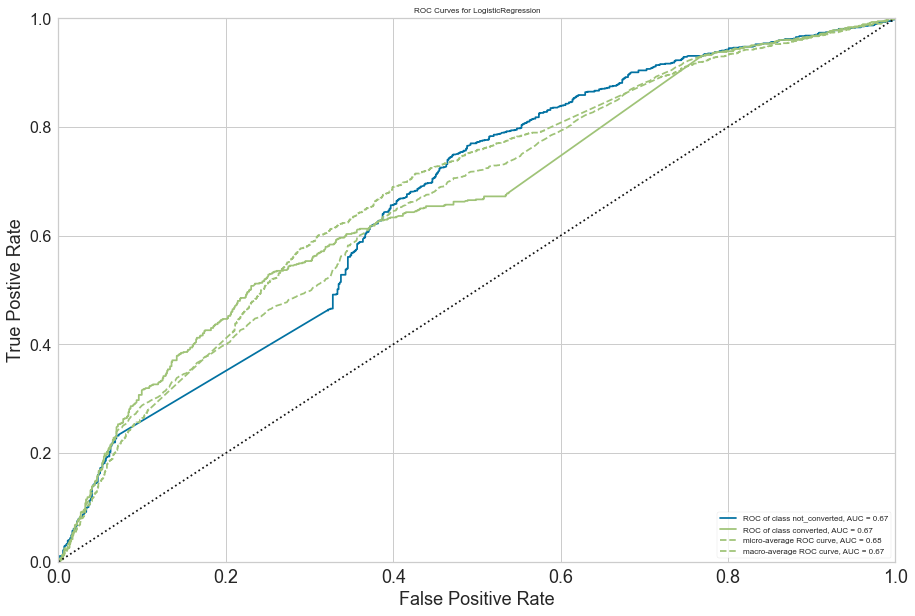

In [107]:
plt.figure(figsize=(15,10))
visualizer = ROCAUC(trained_logit_model, classes=["not_converted", "converted"])
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()       
plt.show()

## Adding some categorical features

In [108]:
leads_cleaned.columns

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call',
       'Converted', 'TotalVisits', 'Total Time Spent on Website',
       'Page Views Per Visit', 'Last Activity', 'Country', 'Specialization',
       'What is your current occupation',
       'What matters most to you in choosing a course', 'Search',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations', 'Tags',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

In [109]:
# 'Lead Origin', 'Specialization', 'What is your current occupation', 'What matters most to you in choosing a course'

In [110]:
def get_low_contribution_columns(grouped_df):
    # fetching list of values which have contribution less that 5%
    return list(grouped_df[grouped_df < 0.05].keys())

In [111]:
leads_data_prep = leads_cleaned.copy()

In [112]:
low_contrib_values = get_low_contribution_columns(leads_data_prep['Lead Origin'].value_counts(normalize=True))
low_contrib_values

['Lead Import', 'Quick Add Form']

Here we are combining some values which have less than 5% share

In [113]:
# combining low contribution columns to Others
sel_indices = leads_data_prep[leads_data_prep['Lead Origin'].isin(low_contrib_values)].index
leads_data_prep.loc[sel_indices, 'Lead Origin'] = 'Others'

leads_data_prep['Lead Origin'].value_counts()

Landing Page Submission    4886
API                        3580
Lead Add Form               718
Others                       56
Name: Lead Origin, dtype: int64

In [114]:
leads_data_prep.rename(columns={'What is your current occupation': 'CurrentOccupation'}, inplace=True)

In [115]:
low_contrib_values = get_low_contribution_columns(leads_data_prep['CurrentOccupation'].value_counts(normalize=True))
low_contrib_values

['Student', 'Other', 'Housewife', 'Businessman']

In [116]:
sel_indices = leads_data_prep[leads_data_prep['CurrentOccupation'].isin(low_contrib_values)].index
leads_data_prep.loc[sel_indices, 'CurrentOccupation'] = 'Others'

leads_data_prep['CurrentOccupation'].value_counts()

Unemployed              8290
Working Professional     706
Others                   244
Name: CurrentOccupation, dtype: int64

In [117]:
low_contrib_values = get_low_contribution_columns(leads_data_prep['Specialization'].value_counts(normalize=True))
low_contrib_values

['Business Administration',
 'IT Projects Management',
 'Supply Chain Management',
 'Banking, Investment And Insurance',
 'Media and Advertising',
 'Travel and Tourism',
 'International Business',
 'Healthcare Management',
 'Hospitality Management',
 'E-COMMERCE',
 'Retail Management',
 'Rural and Agribusiness',
 'E-Business',
 'Services Excellence']

In [118]:
sel_indices = leads_data_prep[leads_data_prep['Specialization'].isin(low_contrib_values)].index
leads_data_prep.loc[sel_indices, 'Specialization'] = 'Others'

leads_data_prep['Specialization'].value_counts()

na_specialization            3380
Others                       2695
Finance Management            976
Human Resource Management     848
Marketing Management          838
Operations Management         503
Name: Specialization, dtype: int64

In [119]:
leads_data_prep.columns

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call',
       'Converted', 'TotalVisits', 'Total Time Spent on Website',
       'Page Views Per Visit', 'Last Activity', 'Country', 'Specialization',
       'CurrentOccupation', 'What matters most to you in choosing a course',
       'Search', 'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations', 'Tags',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

In [120]:
numerical_features = ['TotalVisits', 'Total Time Spent on Website']
categorical_features = ['Lead Origin', 'CurrentOccupation', 'Specialization']

### Feature Scaling

In [121]:
num_df = pd.DataFrame(MinMaxScaler().fit_transform(leads_data_prep[numerical_features]), columns=numerical_features)
num_df

TotalVisits  Total Time Spent on Website
0        0.000000                     0.000000
1        0.019920                     0.296655
2        0.007968                     0.674296
3        0.003984                     0.134243
4        0.007968                     0.628521
...           ...                          ...
9235     0.031873                     0.812060
9236     0.007968                     0.104754
9237     0.007968                     0.087588
9238     0.011952                     0.219630
9239     0.023904                     0.562940

[9240 rows x 2 columns]

### One hot encode

In [122]:
ohe = OneHotEncoder(drop='first')
enc_arr = ohe.fit_transform(leads_data_prep[categorical_features]).toarray()

In [123]:
ohe_features = ohe.get_feature_names()

In [124]:
cat_df = pd.DataFrame(enc_arr, columns=ohe_features)
cat_df

x0_Landing Page Submission  x0_Lead Add Form  x0_Others  x1_Unemployed  \
0                            0.0               0.0        0.0            1.0   
1                            0.0               0.0        0.0            1.0   
2                            1.0               0.0        0.0            0.0   
3                            1.0               0.0        0.0            1.0   
4                            1.0               0.0        0.0            1.0   
...                          ...               ...        ...            ...   
9235                         1.0               0.0        0.0            1.0   
9236                         1.0               0.0        0.0            1.0   
9237                         1.0               0.0        0.0            1.0   
9238                         1.0               0.0        0.0            1.0   
9239                         1.0               0.0        0.0            1.0   

      x1_Working Professional  x2_Human Resource Management  \
0                         0.0                           0.0   
1                         0.0                           0.0   
2                         0.0                           0.0   
3                         0.0                           0.0   
4                         0.0                           0.0   
...                       ...                           ...   
9235                      0.0                           0.0   
9236                      0.0                           0.0   
9237                      0.0                           0.0   
9238                      0.0                           1.0   
9239                      0.0                           0.0   

      x2_Marketing Management  x2_Operations Management  x2_Others  \
0                         0.0                       0.0        0.0   
1                         0.0                       0.0        0.0   
2                         0.0                       0.0        1.0   
3                         0.0                       0.0        1.0   
4                         0.0                       0.0        0.0   
...                       ...                       ...        ...   
9235                      0.0                       0.0        1.0   
9236                      0.0                       0.0        1.0   
9237                      0.0                       0.0        1.0   
9238                      0.0                       0.0        0.0   
9239                      0.0                       0.0        1.0   

      x2_na_specialization  
0                      1.0  
1                      1.0  
2                      0.0  
3                      0.0  
4                      1.0  
...                    ...  
9235                   0.0  
9236                   0.0  
9237                   0.0  
9238                   0.0  
9239                   0.0  

[9240 rows x 10 columns]

In [125]:
scaled_df = pd.concat([num_df, cat_df], axis=1)
scaled_df

TotalVisits  Total Time Spent on Website  x0_Landing Page Submission  \
0        0.000000                     0.000000                         0.0   
1        0.019920                     0.296655                         0.0   
2        0.007968                     0.674296                         1.0   
3        0.003984                     0.134243                         1.0   
4        0.007968                     0.628521                         1.0   
...           ...                          ...                         ...   
9235     0.031873                     0.812060                         1.0   
9236     0.007968                     0.104754                         1.0   
9237     0.007968                     0.087588                         1.0   
9238     0.011952                     0.219630                         1.0   
9239     0.023904                     0.562940                         1.0   

      x0_Lead Add Form  x0_Others  x1_Unemployed  x1_Working Professional  \
0                  0.0        0.0            1.0                      0.0   
1                  0.0        0.0            1.0                      0.0   
2                  0.0        0.0            0.0                      0.0   
3                  0.0        0.0            1.0                      0.0   
4                  0.0        0.0            1.0                      0.0   
...                ...        ...            ...                      ...   
9235               0.0        0.0            1.0                      0.0   
9236               0.0        0.0            1.0                      0.0   
9237               0.0        0.0            1.0                      0.0   
9238               0.0        0.0            1.0                      0.0   
9239               0.0        0.0            1.0                      0.0   

      x2_Human Resource Management  x2_Marketing Management  \
0                              0.0                      0.0   
1                              0.0                      0.0   
2                              0.0                      0.0   
3                              0.0                      0.0   
4                              0.0                      0.0   
...                            ...                      ...   
9235                           0.0                      0.0   
9236                           0.0                      0.0   
9237                           0.0                      0.0   
9238                           1.0                      0.0   
9239                           0.0                      0.0   

      x2_Operations Management  x2_Others  x2_na_specialization  
0                          0.0        0.0                   1.0  
1                          0.0        0.0                   1.0  
2                          0.0        1.0                   0.0  
3                          0.0        1.0                   0.0  
4                          0.0        0.0                   1.0  
...                        ...        ...                   ...  
9235                       0.0        1.0                   0.0  
9236                       0.0        1.0                   0.0  
9237                       0.0        1.0                   0.0  
9238                       0.0        0.0                   0.0  
9239                       0.0        1.0                   0.0  

[9240 rows x 12 columns]

In [126]:
scaled_df[target_col] = LabelEncoder().fit_transform(leads_data_prep[target_col])

In [127]:
scaled_df

TotalVisits  Total Time Spent on Website  x0_Landing Page Submission  \
0        0.000000                     0.000000                         0.0   
1        0.019920                     0.296655                         0.0   
2        0.007968                     0.674296                         1.0   
3        0.003984                     0.134243                         1.0   
4        0.007968                     0.628521                         1.0   
...           ...                          ...                         ...   
9235     0.031873                     0.812060                         1.0   
9236     0.007968                     0.104754                         1.0   
9237     0.007968                     0.087588                         1.0   
9238     0.011952                     0.219630                         1.0   
9239     0.023904                     0.562940                         1.0   

      x0_Lead Add Form  x0_Others  x1_Unemployed  x1_Working Professional  \
0                  0.0        0.0            1.0                      0.0   
1                  0.0        0.0            1.0                      0.0   
2                  0.0        0.0            0.0                      0.0   
3                  0.0        0.0            1.0                      0.0   
4                  0.0        0.0            1.0                      0.0   
...                ...        ...            ...                      ...   
9235               0.0        0.0            1.0                      0.0   
9236               0.0        0.0            1.0                      0.0   
9237               0.0        0.0            1.0                      0.0   
9238               0.0        0.0            1.0                      0.0   
9239               0.0        0.0            1.0                      0.0   

      x2_Human Resource Management  x2_Marketing Management  \
0                              0.0                      0.0   
1                              0.0                      0.0   
2                              0.0                      0.0   
3                              0.0                      0.0   
4                              0.0                      0.0   
...                            ...                      ...   
9235                           0.0                      0.0   
9236                           0.0                      0.0   
9237                           0.0                      0.0   
9238                           1.0                      0.0   
9239                           0.0                      0.0   

      x2_Operations Management  x2_Others  x2_na_specialization  Converted  
0                          0.0        0.0                   1.0          0  
1                          0.0        0.0                   1.0          0  
2                          0.0        1.0                   0.0          1  
3                          0.0        1.0                   0.0          0  
4                          0.0        0.0                   1.0          1  
...                        ...        ...                   ...        ...  
9235                       0.0        1.0                   0.0          1  
9236                       0.0        1.0                   0.0          0  
9237                       0.0        1.0                   0.0          0  
9238                       0.0        0.0                   0.0          1  
9239                       0.0        1.0                   0.0          1  

[9240 rows x 13 columns]

#### Train test split

In [128]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df.drop(target_col, axis=1), scaled_df[target_col], test_size=0.2, random_state=101)

#### Running cross validation on Logistic Regression

In [129]:
cv = train_cv(X_train, y_train)

cv

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


{'fit_time': array([0.02898932, 0.0340085 , 0.03700089, 0.02300382, 0.03100801]),
 'score_time': array([0.00399375, 0.00400233, 0.00498962, 0.00400352, 0.00399923]),
 'estimator': (LogisticRegression(),
  LogisticRegression(),
  LogisticRegression(),
  LogisticRegression(),
  LogisticRegression()),
 'test_auc': array([0.74421488, 0.74575803, 0.76049731, 0.7573833 , 0.7257642 ]),
 'test_accuracy': array([0.77349561, 0.77417174, 0.78890392, 0.78958051, 0.76048714])}

Fetching best estimator (AUC)

In [130]:
trained_model = cv['estimator'][2]

In [131]:
y_test_pred = trained_model.predict(X_test)
y_test_pred_prob = trained_model.predict_proba(X_test)

#### Check summary

In [132]:
show_model_summary('Logit Model-2', y_test, y_test_pred, y_test_pred_prob)





Logit Model-2 model summary
Classification Report: 
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1125
           1       0.81      0.63      0.71       723

    accuracy                           0.80      1848
   macro avg       0.80      0.77      0.78      1848
weighted avg       0.80      0.80      0.79      1848

Confusion Matrix: 
[[1015  110]
 [ 267  456]]
Logloss:  0.4622347091752232
auc:  0.8381865683110497
sensitivity:  0.6307053941908713






Model accuracy is 80%, sensitivity is 63%

#### ROC-AUC Curve

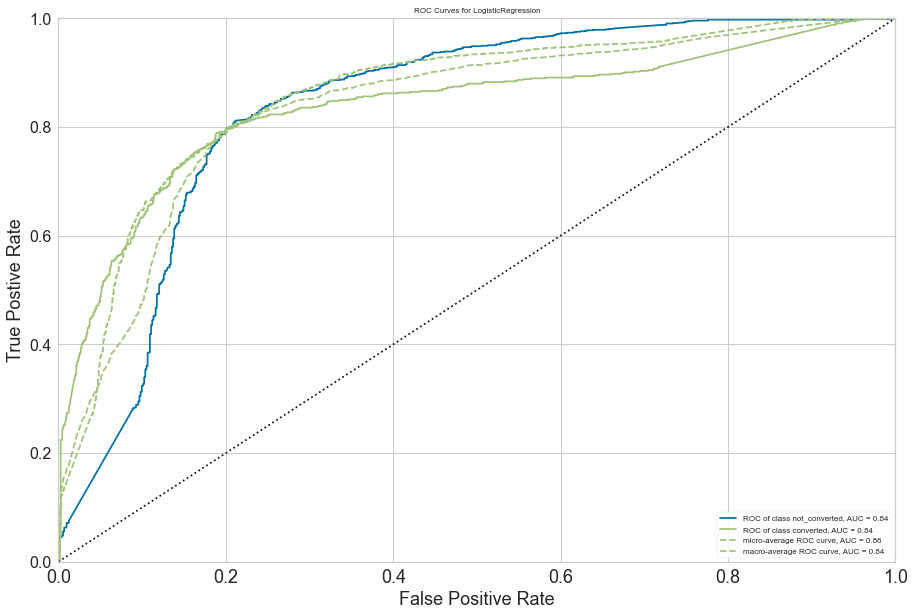

In [133]:
plt.figure(figsize=(15,10))
visualizer = ROCAUC(trained_model, classes=["not_converted", "converted"])
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show() 
plt.show()

In [134]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df.drop(target_col, axis=1), scaled_df[target_col], test_size=0.2, random_state=101)

#### Oversampling

In [135]:
smote = SMOTE()

In [136]:
X_train, y_train = smote.fit_sample(X_train, y_train)

#### Cross validation

In [137]:
cv = train_cv(X_train, y_train)

cv

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


{'fit_time': array([0.04399037, 0.02700686, 0.03000021, 0.02499986, 0.03000665]),
 'score_time': array([0.00300026, 0.00399399, 0.00399971, 0.00400043, 0.00399423]),
 'estimator': (LogisticRegression(),
  LogisticRegression(),
  LogisticRegression(),
  LogisticRegression(),
  LogisticRegression()),
 'test_auc': array([0.78046103, 0.77552141, 0.76673985, 0.78085065, 0.777063  ]),
 'test_accuracy': array([0.78046103, 0.77552141, 0.76673985, 0.78088962, 0.77704558])}

#### Best Estimator (AUC)

In [138]:
trained_model = cv['estimator'][3]

In [139]:
y_test_pred = trained_model.predict(X_test)
y_test_pred_prob = trained_model.predict_proba(X_test)

show_model_summary('Logit Model-2_SM', y_test, y_test_pred, y_test_pred_prob)





Logit Model-2_SM model summary
Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1125
           1       0.76      0.73      0.74       723

    accuracy                           0.80      1848
   macro avg       0.79      0.79      0.79      1848
weighted avg       0.80      0.80      0.80      1848

Confusion Matrix: 
[[955 170]
 [193 530]]
Logloss:  0.4750343802258977
auc:  0.83663254956201
sensitivity:  0.7330567081604425






After oversampling. Sensitivity increased.

#### ROC-AUC Curve

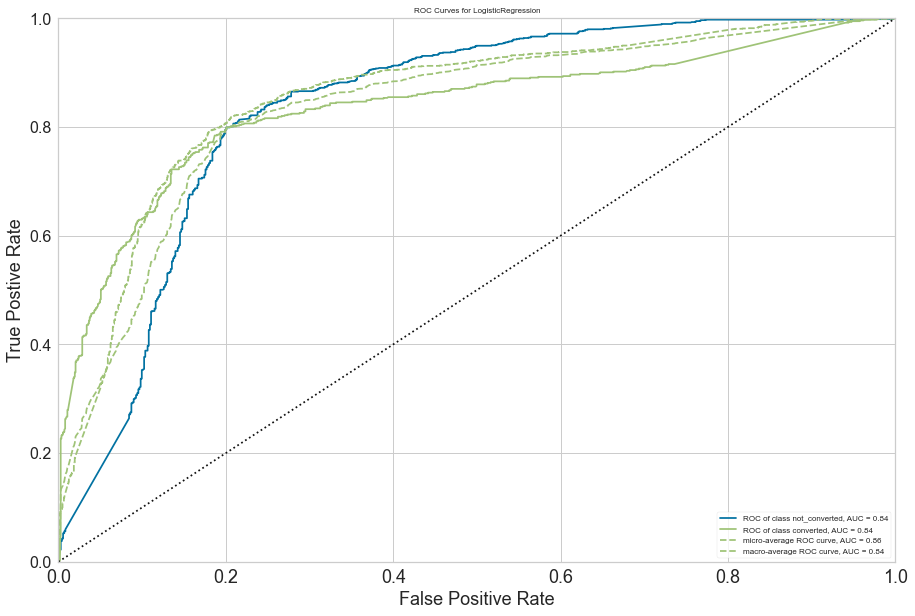

In [140]:
plt.figure(figsize=(15,10))
visualizer = ROCAUC(trained_model, classes=["not_converted", "converted"])
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show() 
plt.show()

In [141]:
def get_importance(features, importances):
    feature_importance_df = pd.DataFrame({'features': features, 'importances': importances})

    plt.figure(figsize=(25,5))
    plt.bar(features, importances)
    plt.tight_layout()
    plt.xticks(rotation=90)
    plt.show()
    
    return feature_importance_df

#### Feature importance plot

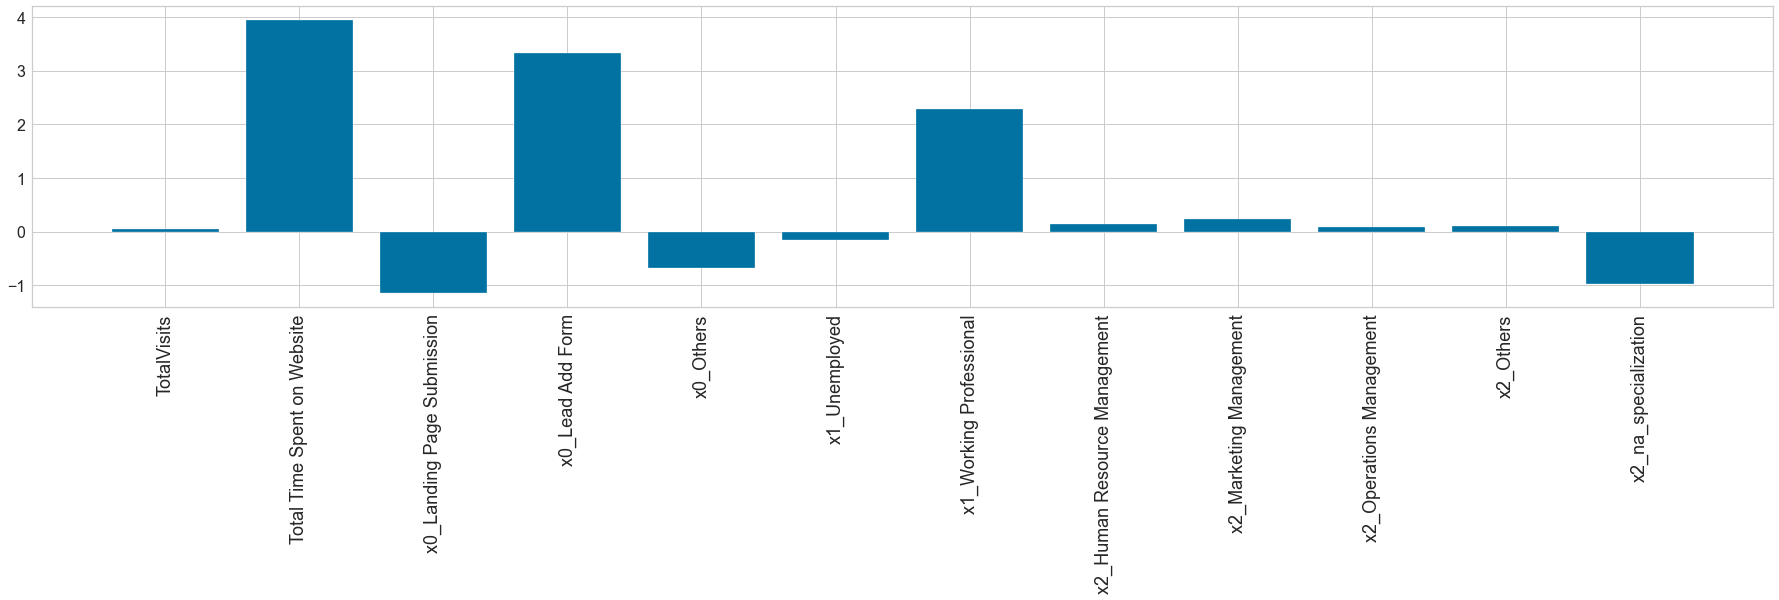

features  importances
0                    TotalVisits     0.054991
1    Total Time Spent on Website     3.942891
2     x0_Landing Page Submission    -1.140775
3               x0_Lead Add Form     3.321441
4                      x0_Others    -0.681976
5                  x1_Unemployed    -0.164283
6        x1_Working Professional     2.280943
7   x2_Human Resource Management     0.149487
8        x2_Marketing Management     0.231470
9       x2_Operations Management     0.084295
10                     x2_Others     0.108309
11          x2_na_specialization    -0.966094

In [142]:
get_importance(X_train.columns, trained_model.coef_[0])

### Adding Lead Source

In [143]:
leads_data_prep.columns

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call',
       'Converted', 'TotalVisits', 'Total Time Spent on Website',
       'Page Views Per Visit', 'Last Activity', 'Country', 'Specialization',
       'CurrentOccupation', 'What matters most to you in choosing a course',
       'Search', 'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations', 'Tags',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

Combining values which have less than 5% share

In [144]:
low_contrib_values = get_low_contribution_columns(leads_data_prep['Lead Source'].value_counts(normalize=True))
low_contrib_values

['Welingak Website',
 'Referral Sites',
 'Facebook',
 'na_lead_source',
 'bing',
 'Click2call',
 'Live Chat',
 'Press_Release',
 'Social Media',
 'testone',
 'NC_EDM',
 'welearnblog_Home',
 'blog',
 'youtubechannel',
 'Pay per Click Ads',
 'WeLearn']

In [145]:
sel_indices = leads_data_prep[leads_data_prep['Lead Source'].isin(low_contrib_values)].index
leads_data_prep.loc[sel_indices, 'Lead Source'] = 'Others'

leads_data_prep['Lead Source'].value_counts()

Google            2873
Direct Traffic    2543
Olark Chat        1755
Organic Search    1154
Reference          534
Others             381
Name: Lead Source, dtype: int64

#### New Features

In [146]:
numerical_features

['TotalVisits', 'Total Time Spent on Website']

In [147]:
categorical_features.append('Lead Source')
categorical_features

['Lead Origin', 'CurrentOccupation', 'Specialization', 'Lead Source']

#### Feature Scaling

In [148]:
num_df = pd.DataFrame(MinMaxScaler().fit_transform(leads_data_prep[numerical_features]), columns=numerical_features)
num_df

TotalVisits  Total Time Spent on Website
0        0.000000                     0.000000
1        0.019920                     0.296655
2        0.007968                     0.674296
3        0.003984                     0.134243
4        0.007968                     0.628521
...           ...                          ...
9235     0.031873                     0.812060
9236     0.007968                     0.104754
9237     0.007968                     0.087588
9238     0.011952                     0.219630
9239     0.023904                     0.562940

[9240 rows x 2 columns]

#### One hot encode

In [149]:
ohe = OneHotEncoder(drop='first')

In [150]:
enc_arr = ohe.fit_transform(leads_data_prep[categorical_features]).toarray()

In [151]:
feature_names = ohe.get_feature_names()

In [152]:
cat_df = pd.DataFrame(enc_arr, columns=feature_names)
cat_df

x0_Landing Page Submission  x0_Lead Add Form  x0_Others  x1_Unemployed  \
0                            0.0               0.0        0.0            1.0   
1                            0.0               0.0        0.0            1.0   
2                            1.0               0.0        0.0            0.0   
3                            1.0               0.0        0.0            1.0   
4                            1.0               0.0        0.0            1.0   
...                          ...               ...        ...            ...   
9235                         1.0               0.0        0.0            1.0   
9236                         1.0               0.0        0.0            1.0   
9237                         1.0               0.0        0.0            1.0   
9238                         1.0               0.0        0.0            1.0   
9239                         1.0               0.0        0.0            1.0   

      x1_Working Professional  x2_Human Resource Management  \
0                         0.0                           0.0   
1                         0.0                           0.0   
2                         0.0                           0.0   
3                         0.0                           0.0   
4                         0.0                           0.0   
...                       ...                           ...   
9235                      0.0                           0.0   
9236                      0.0                           0.0   
9237                      0.0                           0.0   
9238                      0.0                           1.0   
9239                      0.0                           0.0   

      x2_Marketing Management  x2_Operations Management  x2_Others  \
0                         0.0                       0.0        0.0   
1                         0.0                       0.0        0.0   
2                         0.0                       0.0        1.0   
3                         0.0                       0.0        1.0   
4                         0.0                       0.0        0.0   
...                       ...                       ...        ...   
9235                      0.0                       0.0        1.0   
9236                      0.0                       0.0        1.0   
9237                      0.0                       0.0        1.0   
9238                      0.0                       0.0        0.0   
9239                      0.0                       0.0        1.0   

      x2_na_specialization  x3_Google  x3_Olark Chat  x3_Organic Search  \
0                      1.0        0.0            1.0                0.0   
1                      1.0        0.0            0.0                1.0   
2                      0.0        0.0            0.0                0.0   
3                      0.0        0.0            0.0                0.0   
4                      1.0        1.0            0.0                0.0   
...                    ...        ...            ...                ...   
9235                   0.0        0.0            0.0                0.0   
9236                   0.0        0.0            0.0                0.0   
9237                   0.0        0.0            0.0                0.0   
9238                   0.0        1.0            0.0                0.0   
9239                   0.0        0.0            0.0                0.0   

      x3_Others  x3_Reference  
0           0.0           0.0  
1           0.0           0.0  
2           0.0           0.0  
3           0.0           0.0  
4           0.0           0.0  
...         ...           ...  
9235        0.0           0.0  
9236        0.0           0.0  
9237        0.0           0.0  
9238        0.0           0.0  
9239        0.0           0.0  

[9240 rows x 15 columns]

In [153]:
scaled_df = pd.concat([num_df, cat_df], axis=1)
scaled_df

TotalVisits  Total Time Spent on Website  x0_Landing Page Submission  \
0        0.000000                     0.000000                         0.0   
1        0.019920                     0.296655                         0.0   
2        0.007968                     0.674296                         1.0   
3        0.003984                     0.134243                         1.0   
4        0.007968                     0.628521                         1.0   
...           ...                          ...                         ...   
9235     0.031873                     0.812060                         1.0   
9236     0.007968                     0.104754                         1.0   
9237     0.007968                     0.087588                         1.0   
9238     0.011952                     0.219630                         1.0   
9239     0.023904                     0.562940                         1.0   

      x0_Lead Add Form  x0_Others  x1_Unemployed  x1_Working Professional  \
0                  0.0        0.0            1.0                      0.0   
1                  0.0        0.0            1.0                      0.0   
2                  0.0        0.0            0.0                      0.0   
3                  0.0        0.0            1.0                      0.0   
4                  0.0        0.0            1.0                      0.0   
...                ...        ...            ...                      ...   
9235               0.0        0.0            1.0                      0.0   
9236               0.0        0.0            1.0                      0.0   
9237               0.0        0.0            1.0                      0.0   
9238               0.0        0.0            1.0                      0.0   
9239               0.0        0.0            1.0                      0.0   

      x2_Human Resource Management  x2_Marketing Management  \
0                              0.0                      0.0   
1                              0.0                      0.0   
2                              0.0                      0.0   
3                              0.0                      0.0   
4                              0.0                      0.0   
...                            ...                      ...   
9235                           0.0                      0.0   
9236                           0.0                      0.0   
9237                           0.0                      0.0   
9238                           1.0                      0.0   
9239                           0.0                      0.0   

      x2_Operations Management  x2_Others  x2_na_specialization  x3_Google  \
0                          0.0        0.0                   1.0        0.0   
1                          0.0        0.0                   1.0        0.0   
2                          0.0        1.0                   0.0        0.0   
3                          0.0        1.0                   0.0        0.0   
4                          0.0        0.0                   1.0        1.0   
...                        ...        ...                   ...        ...   
9235                       0.0        1.0                   0.0        0.0   
9236                       0.0        1.0                   0.0        0.0   
9237                       0.0        1.0                   0.0        0.0   
9238                       0.0        0.0                   0.0        1.0   
9239                       0.0        1.0                   0.0        0.0   

      x3_Olark Chat  x3_Organic Search  x3_Others  x3_Reference  
0               1.0                0.0        0.0           0.0  
1               0.0                1.0        0.0           0.0  
2               0.0                0.0        0.0           0.0  
3               0.0                0.0        0.0           0.0  
4               0.0                0.0        0.0           0.0  
...             ...                ...        ...     

In [154]:
scaled_df[target_col] = LabelEncoder().fit_transform(leads_data_prep[target_col])

#### Train test split

In [155]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df.drop(target_col, axis=1), scaled_df[target_col], test_size=0.2, random_state=101)

#### Cross validate

In [156]:
cv = train_cv(X_train, y_train)

cv

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


{'fit_time': array([0.05300379, 0.05000901, 0.04100394, 0.05699253, 0.03899574]),
 'score_time': array([0.00399685, 0.00498915, 0.00400138, 0.004004  , 0.00599933]),
 'estimator': (LogisticRegression(),
  LogisticRegression(),
  LogisticRegression(),
  LogisticRegression(),
  LogisticRegression()),
 'test_auc': array([0.74411149, 0.75389798, 0.75467585, 0.75275827, 0.72906671]),
 'test_accuracy': array([0.77214334, 0.78093306, 0.78213802, 0.78552097, 0.76251691])}

#### Best estimator (AUC)

In [157]:
trained_model = cv['estimator'][2]

#### Check summary

In [158]:
y_test_pred = trained_model.predict(X_test)
y_test_pred_prob = trained_model.predict_proba(X_test)

show_model_summary('Logit Model-3', y_test, y_test_pred, y_test_pred_prob)





Logit Model-3 model summary
Classification Report: 
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1125
           1       0.81      0.62      0.70       723

    accuracy                           0.79      1848
   macro avg       0.80      0.76      0.77      1848
weighted avg       0.80      0.79      0.79      1848

Confusion Matrix: 
[[1018  107]
 [ 275  448]]
Logloss:  0.45830424841934025
auc:  0.854482864607346
sensitivity:  0.6196403872752421






In [159]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df.drop(target_col, axis=1), scaled_df[target_col], test_size=0.2, random_state=101)

#### Oversampling

In [160]:
smote = SMOTE()

X_train, y_train = smote.fit_sample(X_train, y_train)

#### Cross validate

In [161]:
cv = train_cv(X_train, y_train)
cv

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


{'fit_time': array([0.06499529, 0.05599523, 0.05499053, 0.06500983, 0.07099605]),
 'score_time': array([0.00501251, 0.00399971, 0.00399923, 0.00400329, 0.00698733]),
 'estimator': (LogisticRegression(),
  LogisticRegression(),
  LogisticRegression(),
  LogisticRegression(),
  LogisticRegression()),
 'test_auc': array([0.79253568, 0.78869374, 0.76893524, 0.78579812, 0.76993583]),
 'test_accuracy': array([0.79253568, 0.78869374, 0.76893524, 0.78583196, 0.76990664])}

#### Best estimator

In [162]:
trained_model = cv['estimator'][3]

#### Check summary

In [163]:
y_test_pred = trained_model.predict(X_test)
y_test_pred_prob = trained_model.predict_proba(X_test)

show_model_summary('Logit Model-3_SM', y_test, y_test_pred, y_test_pred_prob)





Logit Model-3_SM model summary
Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1125
           1       0.76      0.74      0.75       723

    accuracy                           0.81      1848
   macro avg       0.80      0.80      0.80      1848
weighted avg       0.81      0.81      0.81      1848

Confusion Matrix: 
[[957 168]
 [188 535]]
Logloss:  0.47160130522067395
auc:  0.8518100507146149
sensitivity:  0.739972337482711






Sensitivity is 74%. AUC is 85%

#### ROC Curve

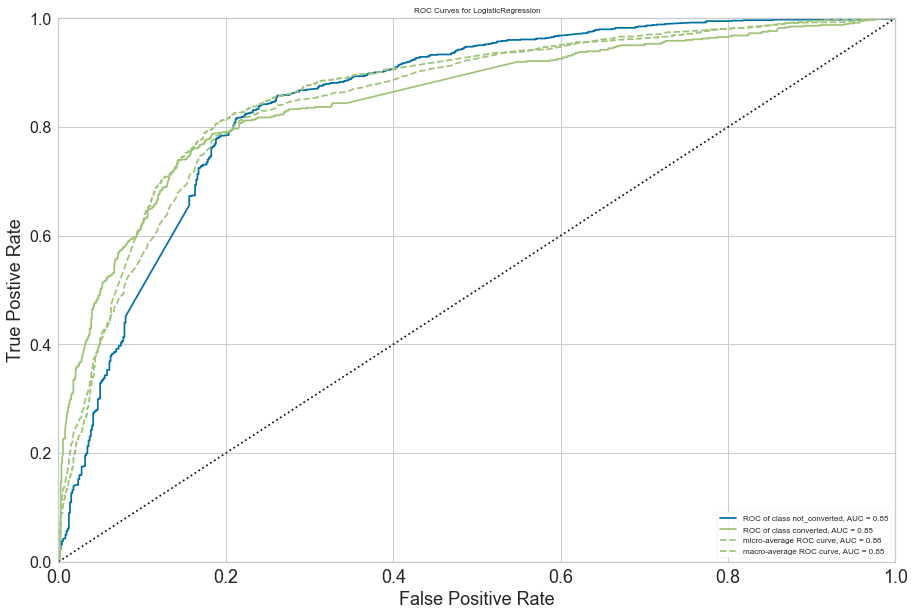

In [164]:
plt.figure(figsize=(15,10))
visualizer = ROCAUC(trained_model, classes=["not_converted", "converted"])
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show() 
plt.show()

#### Feature Importance

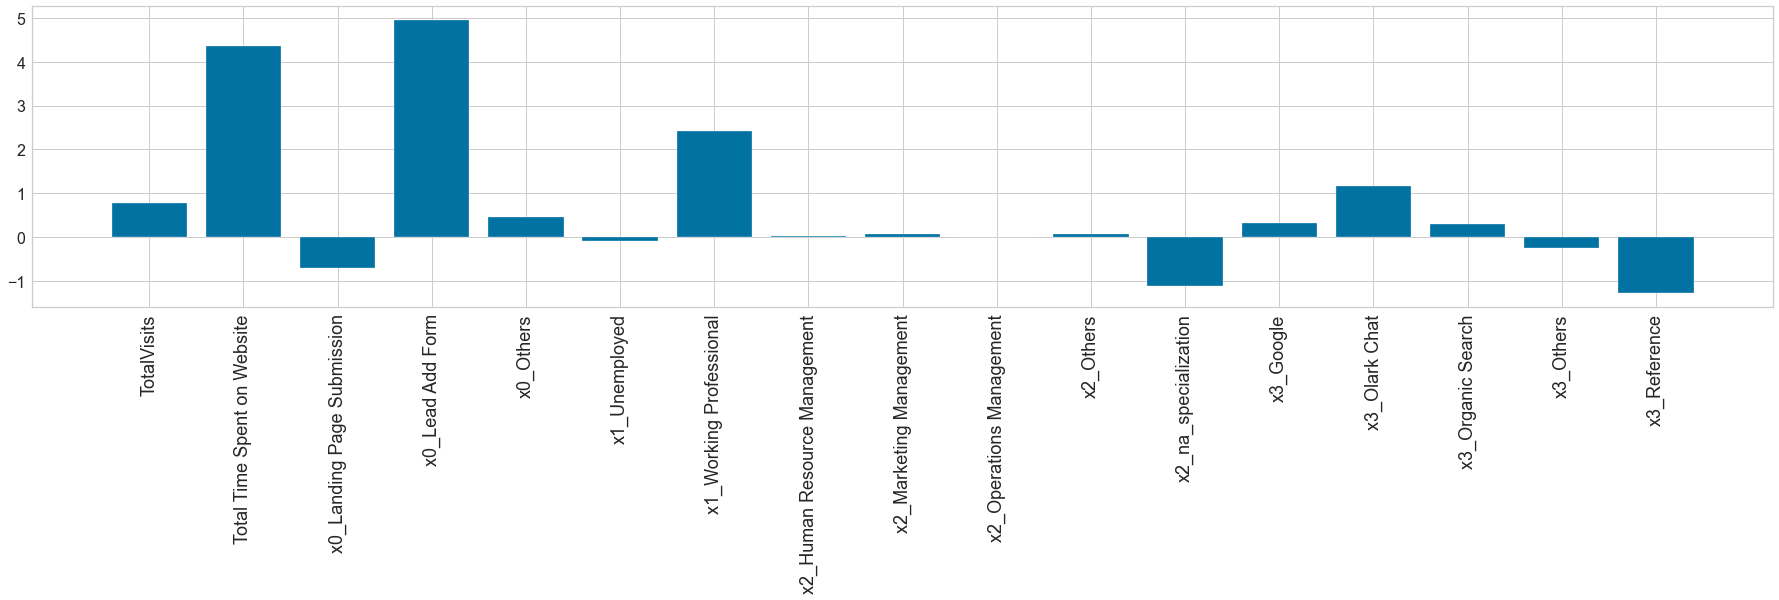

features  importances
0                    TotalVisits     0.786810
1    Total Time Spent on Website     4.347430
2     x0_Landing Page Submission    -0.713390
3               x0_Lead Add Form     4.951230
4                      x0_Others     0.446588
5                  x1_Unemployed    -0.098999
6        x1_Working Professional     2.415331
7   x2_Human Resource Management     0.020306
8        x2_Marketing Management     0.077513
9       x2_Operations Management    -0.011132
10                     x2_Others     0.057495
11          x2_na_specialization    -1.107640
12                     x3_Google     0.315590
13                 x3_Olark Chat     1.167079
14             x3_Organic Search     0.290996
15                     x3_Others    -0.252130
16                  x3_Reference    -1.276203

In [165]:
get_importance(X_train.columns, trained_model.coef_[0])

## Data Prep for RFE

Selecting most of the features and applying RFE

In [166]:
leads_data_prep.columns

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call',
       'Converted', 'TotalVisits', 'Total Time Spent on Website',
       'Page Views Per Visit', 'Last Activity', 'Country', 'Specialization',
       'CurrentOccupation', 'What matters most to you in choosing a course',
       'Search', 'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations', 'Tags',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

In [167]:
numerical_features

['TotalVisits', 'Total Time Spent on Website']

In [168]:
numerical_features.append('Page Views Per Visit')
numerical_features

['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']

In [169]:
categorical_features

['Lead Origin', 'CurrentOccupation', 'Specialization', 'Lead Source']

In [170]:
# Tags, Last Notable Activity, Do Not Email, Do Not Call, Last Activity

In [171]:
low_contrib_values = get_low_contribution_columns(leads_data_prep['Tags'].value_counts(normalize=True))
low_contrib_values

['Closed by Horizzon',
 'switched off',
 'Busy',
 'Lost to EINS',
 'Not doing further education',
 'Interested  in full time MBA',
 'Graduation in progress',
 'invalid number',
 'Diploma holder (Not Eligible)',
 'wrong number given',
 'opp hangup',
 'number not provided',
 'in touch with EINS',
 'Lost to Others',
 'Want to take admission but has financial problems',
 'Still Thinking',
 'Interested in Next batch',
 'In confusion whether part time or DLP',
 'Lateral student',
 'University not recognized',
 'Shall take in the next coming month',
 'Recognition issue (DEC approval)']

In [172]:
sel_indices = leads_data_prep[leads_data_prep['Tags'].isin(low_contrib_values)].index
leads_data_prep.loc[sel_indices, 'Tags'] = 'Others'

leads_data_prep['Tags'].value_counts()

na_tags                                3353
Will revert after reading the email    2072
Others                                 1634
Ringing                                1203
Interested in other courses             513
Already a student                       465
Name: Tags, dtype: int64

In [173]:
low_contrib_values = get_low_contribution_columns(leads_data_prep['Last Notable Activity'].value_counts(normalize=True))
low_contrib_values

['Page Visited on Website',
 'Olark Chat Conversation',
 'Email Link Clicked',
 'Email Bounced',
 'Unsubscribed',
 'Unreachable',
 'Had a Phone Conversation',
 'Email Marked Spam',
 'Approached upfront',
 'Form Submitted on Website',
 'Resubscribed to emails',
 'View in browser link Clicked',
 'Email Received']

In [174]:
sel_indices = leads_data_prep[leads_data_prep['Last Notable Activity'].isin(low_contrib_values)].index
leads_data_prep.loc[sel_indices, 'Last Notable Activity'] = 'Others'

leads_data_prep['Last Notable Activity'].value_counts()

Modified        3407
Email Opened    2827
SMS Sent        2172
Others           834
Name: Last Notable Activity, dtype: int64

In [175]:
low_contrib_values = get_low_contribution_columns(leads_data_prep['Last Activity'].value_counts(normalize=True))
low_contrib_values

['Converted to Lead',
 'Email Bounced',
 'Email Link Clicked',
 'Form Submitted on Website',
 'na_last_activity',
 'Unreachable',
 'Unsubscribed',
 'Had a Phone Conversation',
 'Approached upfront',
 'View in browser link Clicked',
 'Email Marked Spam',
 'Email Received',
 'Visited Booth in Tradeshow',
 'Resubscribed to emails']

In [176]:
sel_indices = leads_data_prep[leads_data_prep['Last Activity'].isin(low_contrib_values)].index
leads_data_prep.loc[sel_indices, 'Last Activity'] = 'Others'

leads_data_prep['Last Activity'].value_counts()

Email Opened               3437
SMS Sent                   2745
Others                     1445
Olark Chat Conversation     973
Page Visited on Website     640
Name: Last Activity, dtype: int64

In [177]:
leads_data_prep.columns

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call',
       'Converted', 'TotalVisits', 'Total Time Spent on Website',
       'Page Views Per Visit', 'Last Activity', 'Country', 'Specialization',
       'CurrentOccupation', 'What matters most to you in choosing a course',
       'Search', 'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations', 'Tags',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

In [178]:
categorical_features.extend(['Do Not Email', 'Do Not Call', 'Last Activity', 'Last Notable Activity', 'Tags'])
categorical_features

['Lead Origin',
 'CurrentOccupation',
 'Specialization',
 'Lead Source',
 'Do Not Email',
 'Do Not Call',
 'Last Activity',
 'Last Notable Activity',
 'Tags']

#### Feature Scaling

In [179]:
num_df = pd.DataFrame(MinMaxScaler().fit_transform(leads_data_prep[numerical_features]), columns=numerical_features)
num_df

TotalVisits  Total Time Spent on Website  Page Views Per Visit
0        0.000000                     0.000000              0.000000
1        0.019920                     0.296655              0.045455
2        0.007968                     0.674296              0.036364
3        0.003984                     0.134243              0.018182
4        0.007968                     0.628521              0.018182
...           ...                          ...                   ...
9235     0.031873                     0.812060              0.048545
9236     0.007968                     0.104754              0.036364
9237     0.007968                     0.087588              0.036364
9238     0.011952                     0.219630              0.054545
9239     0.023904                     0.562940              0.054545

[9240 rows x 3 columns]

#### One hot encode

In [180]:
ohe = OneHotEncoder(drop='first')

In [181]:
enc_arr = ohe.fit_transform(leads_data_prep[categorical_features]).toarray()

In [182]:
feature_names = ohe.get_feature_names()

In [183]:
cat_df = pd.DataFrame(enc_arr, columns=feature_names)
cat_df

x0_Landing Page Submission  x0_Lead Add Form  x0_Others  x1_Unemployed  \
0                            0.0               0.0        0.0            1.0   
1                            0.0               0.0        0.0            1.0   
2                            1.0               0.0        0.0            0.0   
3                            1.0               0.0        0.0            1.0   
4                            1.0               0.0        0.0            1.0   
...                          ...               ...        ...            ...   
9235                         1.0               0.0        0.0            1.0   
9236                         1.0               0.0        0.0            1.0   
9237                         1.0               0.0        0.0            1.0   
9238                         1.0               0.0        0.0            1.0   
9239                         1.0               0.0        0.0            1.0   

      x1_Working Professional  x2_Human Resource Management  \
0                         0.0                           0.0   
1                         0.0                           0.0   
2                         0.0                           0.0   
3                         0.0                           0.0   
4                         0.0                           0.0   
...                       ...                           ...   
9235                      0.0                           0.0   
9236                      0.0                           0.0   
9237                      0.0                           0.0   
9238                      0.0                           1.0   
9239                      0.0                           0.0   

      x2_Marketing Management  x2_Operations Management  x2_Others  \
0                         0.0                       0.0        0.0   
1                         0.0                       0.0        0.0   
2                         0.0                       0.0        1.0   
3                         0.0                       0.0        1.0   
4                         0.0                       0.0        0.0   
...                       ...                       ...        ...   
9235                      0.0                       0.0        1.0   
9236                      0.0                       0.0        1.0   
9237                      0.0                       0.0        1.0   
9238                      0.0                       0.0        0.0   
9239                      0.0                       0.0        1.0   

      x2_na_specialization  x3_Google  x3_Olark Chat  x3_Organic Search  \
0                      1.0        0.0            1.0                0.0   
1                      1.0        0.0            0.0                1.0   
2                      0.0        0.0            0.0                0.0   
3                      0.0        0.0            0.0                0.0   
4                      1.0        1.0            0.0                0.0   
...                    ...        ...            ...                ...   
9235                   0.0        0.0            0.0                0.0   
9236                   0.0        0.0            0.0                0.0   
9237                   0.0        0.0            0.0                0.0   
9238                   0.0        1.0            0.0                0.0   
9239                   0.0        0.0            0.0                0.0   

      x3_Others  x3_Reference  x4_Yes  x5_Yes  x6_Olark Chat Conversation  \
0           0.0           0.0     0.0     0.0                         0.0   
1           0.0           0.0     0.0     0.0                         0.0   
2           0.0           0.0     0.0     0.0                         0.0   
3           0.0           0.0     0.0     0.0                         0.0   
4           0.0           0.0     0.0     0.0                         0.0   
...         ...           ...     ...     ...                         ...   
9235   

In [184]:
scaled_df = pd.concat([num_df, cat_df], axis=1)
scaled_df

TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0        0.000000                     0.000000              0.000000   
1        0.019920                     0.296655              0.045455   
2        0.007968                     0.674296              0.036364   
3        0.003984                     0.134243              0.018182   
4        0.007968                     0.628521              0.018182   
...           ...                          ...                   ...   
9235     0.031873                     0.812060              0.048545   
9236     0.007968                     0.104754              0.036364   
9237     0.007968                     0.087588              0.036364   
9238     0.011952                     0.219630              0.054545   
9239     0.023904                     0.562940              0.054545   

      x0_Landing Page Submission  x0_Lead Add Form  x0_Others  x1_Unemployed  \
0                            0.0               0.0        0.0            1.0   
1                            0.0               0.0        0.0            1.0   
2                            1.0               0.0        0.0            0.0   
3                            1.0               0.0        0.0            1.0   
4                            1.0               0.0        0.0            1.0   
...                          ...               ...        ...            ...   
9235                         1.0               0.0        0.0            1.0   
9236                         1.0               0.0        0.0            1.0   
9237                         1.0               0.0        0.0            1.0   
9238                         1.0               0.0        0.0            1.0   
9239                         1.0               0.0        0.0            1.0   

      x1_Working Professional  x2_Human Resource Management  \
0                         0.0                           0.0   
1                         0.0                           0.0   
2                         0.0                           0.0   
3                         0.0                           0.0   
4                         0.0                           0.0   
...                       ...                           ...   
9235                      0.0                           0.0   
9236                      0.0                           0.0   
9237                      0.0                           0.0   
9238                      0.0                           1.0   
9239                      0.0                           0.0   

      x2_Marketing Management  x2_Operations Management  x2_Others  \
0                         0.0                       0.0        0.0   
1                         0.0                       0.0        0.0   
2                         0.0                       0.0        1.0   
3                         0.0                       0.0        1.0   
4                         0.0                       0.0        0.0   
...                       ...                       ...        ...   
9235                      0.0                       0.0        1.0   
9236                      0.0                       0.0        1.0   
9237                      0.0                       0.0        1.0   
9238                      0.0                       0.0        0.0   
9239                      0.0                       0.0        1.0   

      x2_na_specialization  x3_Google  x3_Olark Chat  x3_Organic Search  \
0                      1.0        0.0            1.0                0.0   
1                      1.0        0.0            0.0                1.0   
2                      0.0        0.0            0.0                0.0   
3                      0.0        0.0            0.0                0.0   
4                      1.0        1.0            0.0                0.0   
...                    ...        ...            ...                ...   
9235                   0.0        0.0            0.0     

In [185]:
scaled_df[target_col] = LabelEncoder().fit_transform(leads_data_prep[target_col])

In [186]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df.drop(target_col, axis=1), scaled_df[target_col], test_size=0.2, random_state=101)

#### Oversampling

In [187]:
smote = SMOTE()
X_train, y_train = smote.fit_sample(X_train, y_train)

## Feature selection with RFE

Selecting 15 features initially

In [188]:
rfe = RFE(LogisticRegression(), n_features_to_select=15, verbose=1)

In [189]:
rfe.fit(X_train, y_train)

Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.


RFE(estimator=LogisticRegression(), n_features_to_select=15, verbose=1)

In [190]:
rfe_supports = list(zip(X_train.columns, rfe.support_))
rfe_supports

[('TotalVisits', True),
 ('Total Time Spent on Website', True),
 ('Page Views Per Visit', True),
 ('x0_Landing Page Submission', False),
 ('x0_Lead Add Form', True),
 ('x0_Others', False),
 ('x1_Unemployed', False),
 ('x1_Working Professional', True),
 ('x2_Human Resource Management', False),
 ('x2_Marketing Management', False),
 ('x2_Operations Management', False),
 ('x2_Others', False),
 ('x2_na_specialization', False),
 ('x3_Google', False),
 ('x3_Olark Chat', True),
 ('x3_Organic Search', False),
 ('x3_Others', False),
 ('x3_Reference', True),
 ('x4_Yes', True),
 ('x5_Yes', False),
 ('x6_Olark Chat Conversation', True),
 ('x6_Others', True),
 ('x6_Page Visited on Website', True),
 ('x6_SMS Sent', False),
 ('x7_Modified', False),
 ('x7_Others', False),
 ('x7_SMS Sent', True),
 ('x8_Interested in other courses', False),
 ('x8_Others', True),
 ('x8_Ringing', False),
 ('x8_Will revert after reading the email', True),
 ('x8_na_tags', True)]

#### Selected features from RFE

In [191]:
rfe_features = [x for x,y in rfe_supports if y == True]
rfe_features

['TotalVisits',
 'Total Time Spent on Website',
 'Page Views Per Visit',
 'x0_Lead Add Form',
 'x1_Working Professional',
 'x3_Olark Chat',
 'x3_Reference',
 'x4_Yes',
 'x6_Olark Chat Conversation',
 'x6_Others',
 'x6_Page Visited on Website',
 'x7_SMS Sent',
 'x8_Others',
 'x8_Will revert after reading the email',
 'x8_na_tags']

In [192]:
X_train = X_train[rfe_features]
X_test = X_test[rfe_features]

#### Cross validate

In [193]:
cv = train_cv(X_train, y_train)
cv

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


{'fit_time': array([0.04600453, 0.05000854, 0.04500747, 0.06700516, 0.04600883]),
 'score_time': array([0.00399137, 0.00299668, 0.00399184, 0.0039916 , 0.00399303]),
 'estimator': (LogisticRegression(),
  LogisticRegression(),
  LogisticRegression(),
  LogisticRegression(),
  LogisticRegression()),
 'test_auc': array([0.87980241, 0.89242591, 0.88748628, 0.89125222, 0.88248755]),
 'test_accuracy': array([0.87980241, 0.89242591, 0.88748628, 0.89126853, 0.88248215])}

#### Best Estimator (AUC)

In [194]:
trained_model = cv['estimator'][3]

y_test_pred = trained_model.predict(X_test)
y_test_pred_prob = trained_model.predict_proba(X_test)

show_model_summary('Logit Model - RFE1', y_test, y_test_pred, y_test_pred_prob)





Logit Model - RFE1 model summary
Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1125
           1       0.87      0.87      0.87       723

    accuracy                           0.90      1848
   macro avg       0.89      0.89      0.89      1848
weighted avg       0.90      0.90      0.90      1848

Confusion Matrix: 
[[1030   95]
 [  94  629]]
Logloss:  0.2558702449043133
auc:  0.9601801137236822
sensitivity:  0.8699861687413555






Accuracy is 90%. sensitivity is 87%

#### Feature Importance

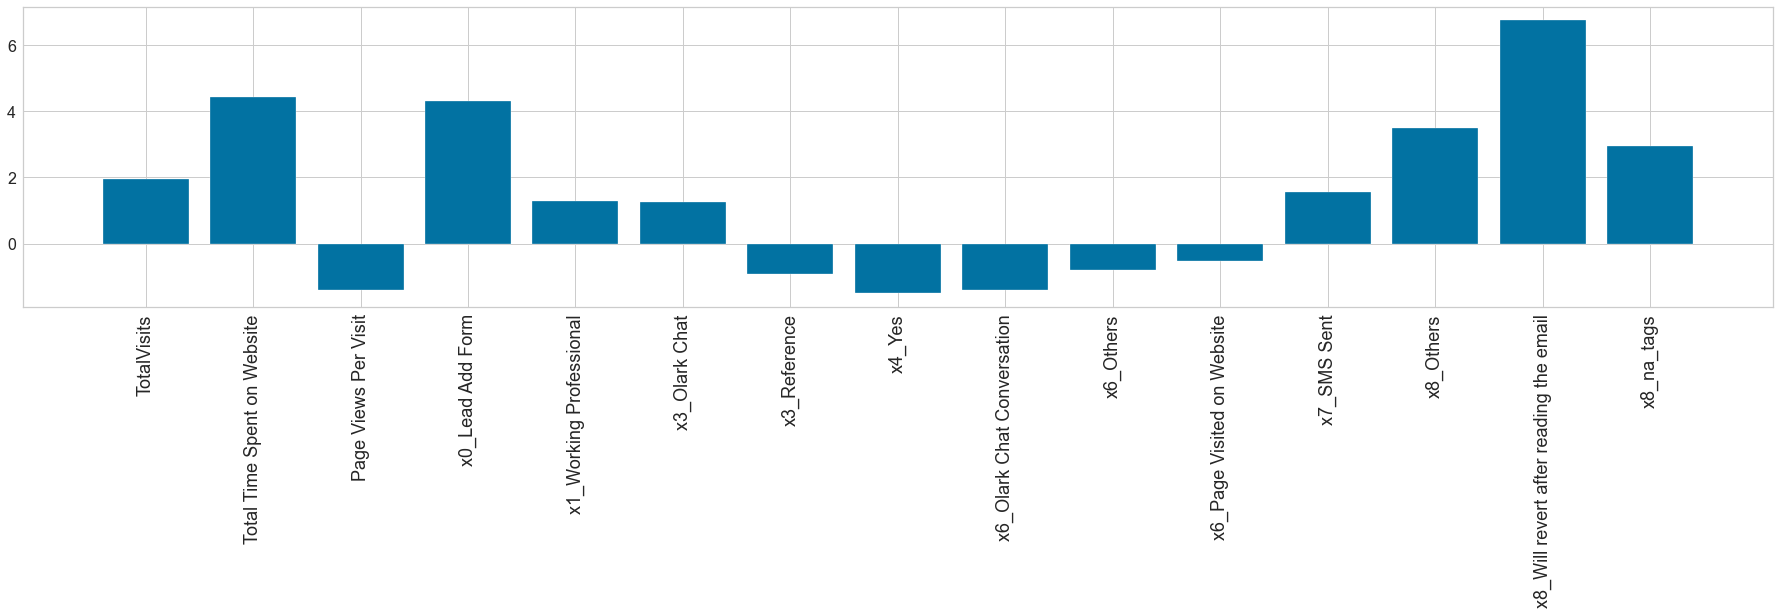

features  importances
0                              TotalVisits     1.962266
1              Total Time Spent on Website     4.435649
2                     Page Views Per Visit    -1.399323
3                         x0_Lead Add Form     4.321074
4                  x1_Working Professional     1.286027
5                            x3_Olark Chat     1.243683
6                             x3_Reference    -0.906359
7                                   x4_Yes    -1.502584
8               x6_Olark Chat Conversation    -1.404850
9                                x6_Others    -0.797462
10              x6_Page Visited on Website    -0.522300
11                             x7_SMS Sent     1.555921
12                               x8_Others     3.503420
13  x8_Will revert after reading the email     6.752124
14                              x8_na_tags     2.956569

In [195]:
get_importance(X_train.columns, trained_model.coef_[0])

### Multi-colinearity - Variance Inflation Factor

In [196]:
def get_vif(X_train):
    # get variance inflation factor report
    vif = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
    features = X_train.columns
    vif_df = pd.DataFrame(dict(zip(['features', 'vif'], [features, vif])))
    vif_df = vif_df.sort_values(by='vif', ascending=False)
    return vif_df

In [197]:
get_vif(X_train)

features       vif
3                         x0_Lead Add Form  4.265625
6                             x3_Reference  4.042830
2                     Page Views Per Visit  3.329751
13  x8_Will revert after reading the email  2.689874
1              Total Time Spent on Website  2.533894
0                              TotalVisits  2.236396
14                              x8_na_tags  2.165563
5                            x3_Olark Chat  1.805975
11                             x7_SMS Sent  1.691450
12                               x8_Others  1.687650
9                                x6_Others  1.387427
8               x6_Olark Chat Conversation  1.363852
4                  x1_Working Professional  1.345190
7                                   x4_Yes  1.210290
10              x6_Page Visited on Website  1.203604

### Fixing Multicolinearity

In [198]:
# final data for train
X_train_new = X_train.drop('x0_Lead Add Form', axis=1)
get_vif(X_train_new)

features       vif
2                     Page Views Per Visit  3.269029
12  x8_Will revert after reading the email  2.626655
1              Total Time Spent on Website  2.504210
0                              TotalVisits  2.235625
13                              x8_na_tags  2.029668
4                            x3_Olark Chat  1.754255
10                             x7_SMS Sent  1.659295
11                               x8_Others  1.636985
8                                x6_Others  1.385579
5                             x3_Reference  1.369951
7               x6_Olark Chat Conversation  1.363721
3                  x1_Working Professional  1.343917
6                                   x4_Yes  1.208606
9               x6_Page Visited on Website  1.203024

In [199]:
# final data for test
X_test_new = X_test[X_train_new.columns]

### Final Cross Validation

In [200]:
cv = train_cv(X_train_new, y_train)
cv

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


{'fit_time': array([0.05799437, 0.04399729, 0.0500052 , 0.04400539, 0.04800367]),
 'score_time': array([0.00599599, 0.00399923, 0.00400162, 0.00299859, 0.00399971]),
 'estimator': (LogisticRegression(),
  LogisticRegression(),
  LogisticRegression(),
  LogisticRegression(),
  LogisticRegression()),
 'test_auc': array([0.87047201, 0.8830955 , 0.87705818, 0.88136753, 0.86711499]),
 'test_accuracy': array([0.87047201, 0.8830955 , 0.87705818, 0.88138386, 0.86710599])}

## Final Model Analysis

In [201]:
# final model object
trained_model = cv['estimator'][1]

y_test_pred = trained_model.predict(X_test_new)
y_test_pred_prob = trained_model.predict_proba(X_test_new)

show_model_summary('Logit Model - RFE2', y_test, y_test_pred, y_test_pred_prob)





Logit Model - RFE2 model summary
Classification Report: 
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1125
           1       0.86      0.86      0.86       723

    accuracy                           0.89      1848
   macro avg       0.88      0.89      0.88      1848
weighted avg       0.89      0.89      0.89      1848

Confusion Matrix: 
[[1022  103]
 [ 100  623]]
Logloss:  0.28052383833206057
auc:  0.9508437067773167
sensitivity:  0.8616874135546335






Final model accuracy is 89%. AUC is 95%

### ROC Curve

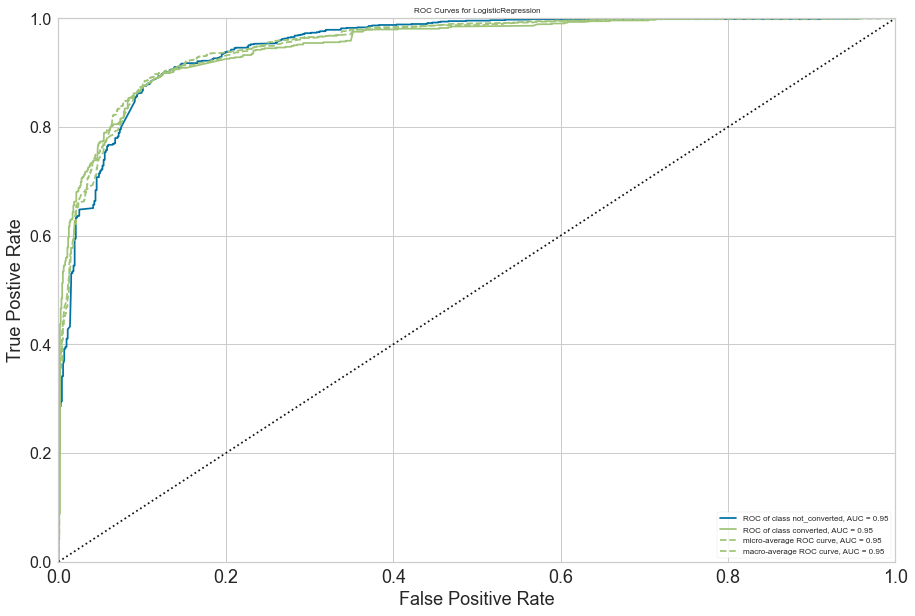

In [202]:
plt.figure(figsize=(15,10))
visualizer = ROCAUC(trained_model, classes=["not_converted", "converted"])
visualizer.score(X_test_new, y_test)       # Evaluate the model on the test data
visualizer.show()
plt.show()

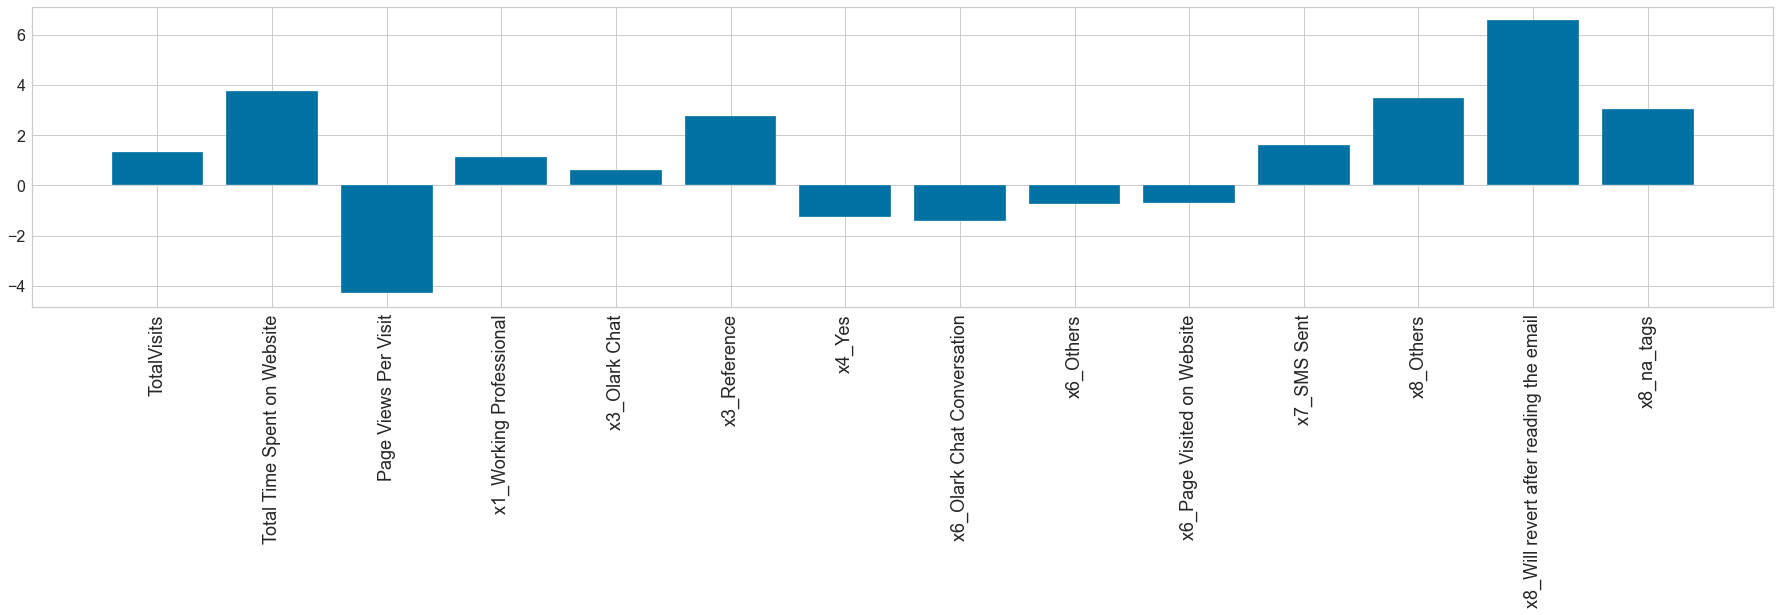

features  importances
0                              TotalVisits     1.336255
1              Total Time Spent on Website     3.762874
2                     Page Views Per Visit    -4.301955
3                  x1_Working Professional     1.114571
4                            x3_Olark Chat     0.619641
5                             x3_Reference     2.761631
6                                   x4_Yes    -1.258111
7               x6_Olark Chat Conversation    -1.415590
8                                x6_Others    -0.734594
9               x6_Page Visited on Website    -0.691319
10                             x7_SMS Sent     1.592412
11                               x8_Others     3.475668
12  x8_Will revert after reading the email     6.569813
13                              x8_na_tags     3.028872

In [203]:
get_importance(X_train_new.columns, trained_model.coef_[0])

In [204]:
categorical_features

['Lead Origin',
 'CurrentOccupation',
 'Specialization',
 'Lead Source',
 'Do Not Email',
 'Do Not Call',
 'Last Activity',
 'Last Notable Activity',
 'Tags']

### Original important features

In [222]:
# final used features
original_features = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'CurrentOccupation_Working Professional', 
                             'Lead Source_Olark Chat', 'Lead Source_Reference', 'Do Not Email_Yes', 'Last Activity_Olark Chat Conversation', 
                             'Last Activity_Others', 'Last Activity_Page Visited on Website', 'Last Notable Activity_SMS Sent', 'Tags_Others', 'Tags_Will revert after reading the email',
                             'Tags_na_tags']

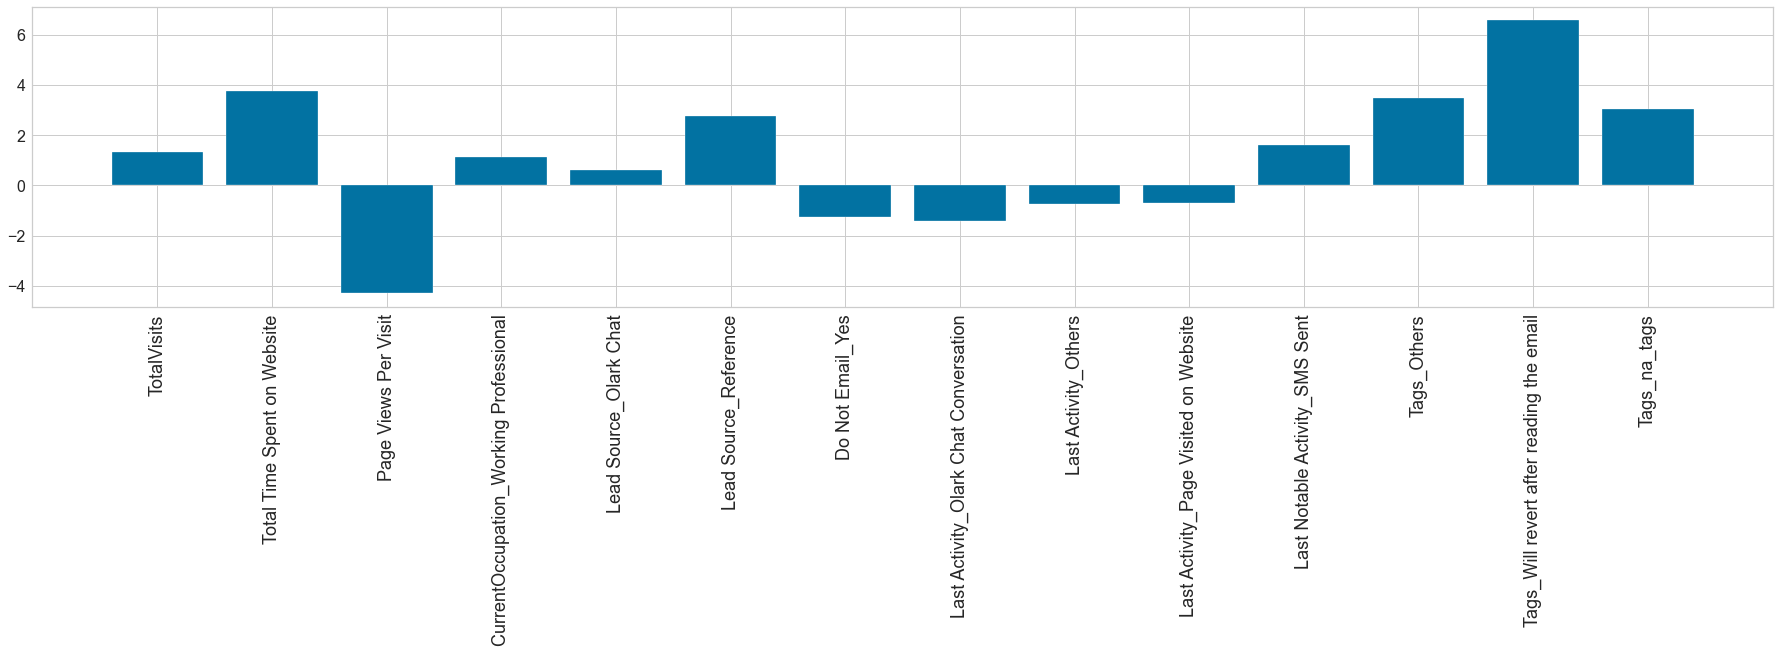

features  importances
0                                TotalVisits     1.336255
1                Total Time Spent on Website     3.762874
2                       Page Views Per Visit    -4.301955
3     CurrentOccupation_Working Professional     1.114571
4                     Lead Source_Olark Chat     0.619641
5                      Lead Source_Reference     2.761631
6                           Do Not Email_Yes    -1.258111
7      Last Activity_Olark Chat Conversation    -1.415590
8                       Last Activity_Others    -0.734594
9      Last Activity_Page Visited on Website    -0.691319
10            Last Notable Activity_SMS Sent     1.592412
11                               Tags_Others     3.475668
12  Tags_Will revert after reading the email     6.569813
13                              Tags_na_tags     3.028872

In [223]:
get_importance(original_features, trained_model.coef_[0])

In [224]:
print('Original Features: ')
[col for col in original_features]

Original Features: 


['TotalVisits',
 'Total Time Spent on Website',
 'Page Views Per Visit',
 'CurrentOccupation_Working Professional',
 'Lead Source_Olark Chat',
 'Lead Source_Reference',
 'Do Not Email_Yes',
 'Last Activity_Olark Chat Conversation',
 'Last Activity_Others',
 'Last Activity_Page Visited on Website',
 'Last Notable Activity_SMS Sent',
 'Tags_Others',
 'Tags_Will revert after reading the email',
 'Tags_na_tags']

### Finding optimal threshold

In [208]:
# final predicted classes
y_test_pred

array([0, 1, 0, ..., 1, 0, 0], dtype=int64)

In [209]:
# final probabilities
y_test_pred_prob

array([[0.85054329, 0.14945671],
       [0.00617557, 0.99382443],
       [0.5846877 , 0.4153123 ],
       ...,
       [0.05198391, 0.94801609],
       [0.72627107, 0.27372893],
       [0.92689145, 0.07310855]])

In [210]:
lead_score = pd.DataFrame()

In [211]:
lead_score['score'] = [x[1] for x in y_test_pred_prob]
lead_score['actual'] = y_test.values
lead_score['pred'] = y_test_pred

In [212]:
for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    lead_score[i] = lead_score['score'].map(lambda x: 1 if x > i else 0)

In [213]:
lead_score

score  actual  pred  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
0     0.149457       0     0    1    0    0    0    0    0    0    0    0
1     0.993824       1     1    1    1    1    1    1    1    1    1    1
2     0.415312       0     0    1    1    1    1    0    0    0    0    0
3     0.005055       0     0    0    0    0    0    0    0    0    0    0
4     0.446423       0     0    1    1    1    1    0    0    0    0    0
...        ...     ...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
1843  0.626030       0     1    1    1    1    1    1    1    0    0    0
1844  0.033165       0     0    0    0    0    0    0    0    0    0    0
1845  0.948016       1     1    1    1    1    1    1    1    1    1    1
1846  0.273729       0     0    1    1    0    0    0    0    0    0    0
1847  0.073109       0     0    0    0    0    0    0    0    0    0    0

[1848 rows x 12 columns]

In [214]:
def get_sensitivity(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred).ravel()
    tn, fp, fn, tp = matrix
    sensitivity = tp / (tp + fn)
    return sensitivity

def get_specificity(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred).ravel()
    tn, fp, fn, tp = matrix
    sensitivity = tn / (tn + fp)
    return sensitivity

In [215]:
probs = []
accs = []
sens = []
specs = []

# looping through probablity threshold
for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    probs.append(i)
    lead_score_pred = lead_score[i]
    y_true = lead_score['actual']
    
    accs.append(accuracy_score(y_true, lead_score_pred))
    sens.append(get_sensitivity(y_true, lead_score_pred))
    specs.append(get_specificity(y_true, lead_score_pred))
    

prob_metrics_df = pd.DataFrame()
prob_metrics_df['prob'] = probs
prob_metrics_df['accuracy'] = accs
prob_metrics_df['sensitivity'] = sens
prob_metrics_df['specificity'] = specs

prob_metrics_df

prob  accuracy  sensitivity  specificity
0   0.1  0.702381     0.984786     0.520889
1   0.2  0.777597     0.957123     0.662222
2   0.3  0.843074     0.926694     0.789333
3   0.4  0.883658     0.890733     0.879111
4   0.5  0.890152     0.861687     0.908444
5   0.6  0.880411     0.806362     0.928000
6   0.7  0.871212     0.738589     0.956444
7   0.8  0.861472     0.683264     0.976000
8   0.9  0.832792     0.590595     0.988444

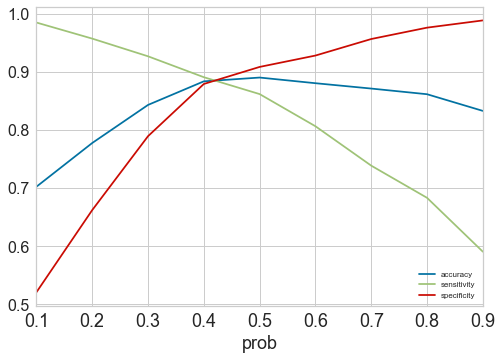

In [216]:
prob_metrics_df.plot.line(x='prob', y=['accuracy','sensitivity','specificity'])
plt.show()

0.4 is the cut-off

### Assigning lead score on the test set

In [217]:
final_score = pd.DataFrame()
final_score['score'] = [round(x[1]*100, 2) for x in y_test_pred_prob]
final_score

score
0     14.95
1     99.38
2     41.53
3      0.51
4     44.64
...     ...
1843  62.60
1844   3.32
1845  94.80
1846  27.37
1847   7.31

[1848 rows x 1 columns]

In [218]:
# getting metrics with 0.4 probability threshold
point_four_metrics = prob_metrics_df[prob_metrics_df['prob'] == 0.4][['accuracy','sensitivity','specificity']]
point_four_metrics = round(point_four_metrics * 100, 2)
point_four_metrics = point_four_metrics.T.rename_axis('metrics').rename(columns={3: 'values'}).reset_index()

### Metrics plot with 0.4 threshold

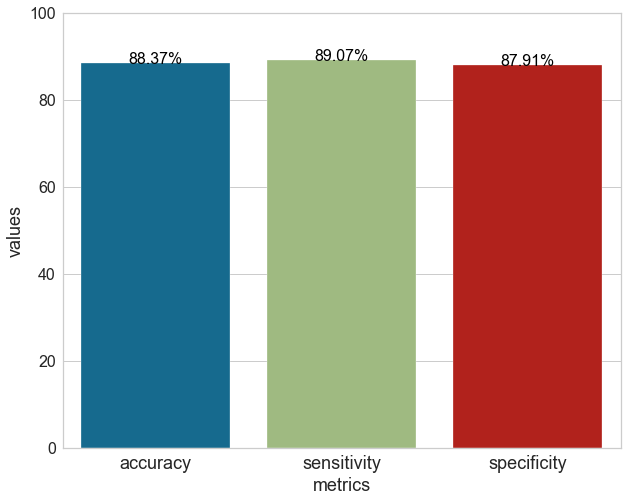

In [219]:
plt.figure(figsize=(10,8))
bar = sns.barplot(x= 'metrics', y= 'values', data=point_four_metrics)

for index, row in point_four_metrics.iterrows():
    bar.text(row.name, row['values'], str(row['values']) + '%', color='black', ha="center")
    
plt.ylim(0, 100)

plt.show()

In [220]:
# getting confusion matrix with 0.4 probability threshold
point_four_conf_mat = confusion_matrix(lead_score['actual'], lead_score[0.4])

### Confusion Matrix with 0.4 threshold

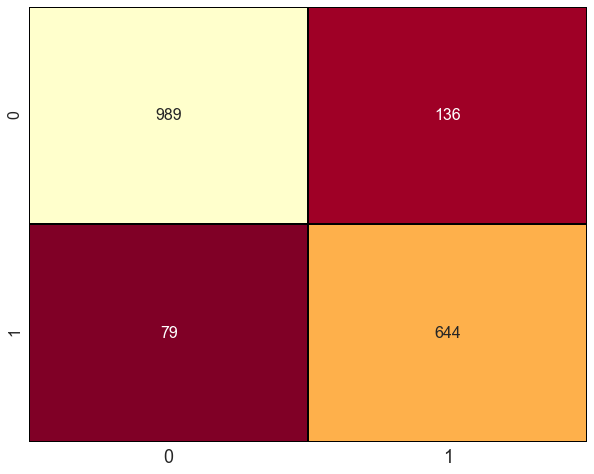

In [221]:
plt.figure(figsize=(10,8))
sns.heatmap(point_four_conf_mat, annot=True, cbar=False, linecolor='black', linewidths=0.8, cmap='YlOrRd_r', fmt = '.0f')
plt.show()